In [191]:
%%capture

#pip install pretty-jupyter lxml_html_clean jinja-markdown setuptools scikit-learn scipy xgboost shap pandas numpy matplotlib seaborn probatus imblearn ipykernel
# jupyter nbconvert --execute --to html --template pj mynotebook.ipynb

%load_ext pretty_jupyter





In [192]:
import warnings
warnings.filterwarnings('ignore')

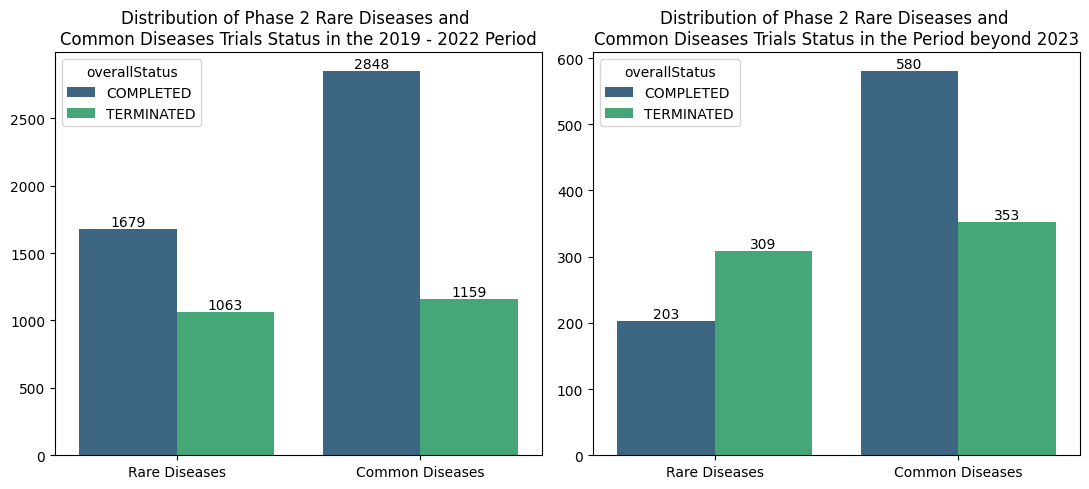

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df_ct_rawhr = pd.read_pickle('clean_data/main_bigger3.pkl')
df_ct_rawhr['overallStatus'] = df_ct_rawhr['overallStatus'].replace({1:'TERMINATED', 0:'COMPLETED'})
df_ct_rawhr = df_ct_rawhr[(df_ct_rawhr['startDate'] >= 2019) & (df_ct_rawhr['startDate'] <= 2022)]
df_ct_rawhr = df_ct_rawhr[(df_ct_rawhr['PHASE2']==True)]

df_ct_rawhr_gen = pd.read_pickle('clean_data/main_bigger3.pkl')
df_ct_rawhr_gen['overallStatus'] = df_ct_rawhr_gen['overallStatus'].replace({1:'TERMINATED', 0:'COMPLETED'})
df_ct_rawhr_gen = df_ct_rawhr_gen[(df_ct_rawhr_gen['startDate'] >= 2022)]
df_ct_rawhr_gen = df_ct_rawhr_gen[(df_ct_rawhr_gen['PHASE2']==True)]

# Calculate value counts for overallStatus in both dataframes based on is_Rare
overall_status_rawhr = df_ct_rawhr.groupby(['is_Rare', 'overallStatus']).size().reset_index(name='count')
overall_status_rawhr_gen = df_ct_rawhr_gen.groupby(['is_Rare', 'overallStatus']).size().reset_index(name='count')

# Replace True/False with "Rare Diseases" and "Common Diseases"
overall_status_rawhr['is_Rare'] = overall_status_rawhr['is_Rare'].replace({True: 'Rare Diseases', False: 'Common Diseases'})
overall_status_rawhr_gen['is_Rare'] = overall_status_rawhr_gen['is_Rare'].replace({True: 'Rare Diseases', False: 'Common Diseases'})

# Ensure "Rare Diseases" comes first
overall_status_rawhr['is_Rare'] = pd.Categorical(overall_status_rawhr['is_Rare'], categories=['Rare Diseases', 'Common Diseases'])
overall_status_rawhr_gen['is_Rare'] = pd.Categorical(overall_status_rawhr_gen['is_Rare'], categories=['Rare Diseases', 'Common Diseases'])

# Plot the bar plots
plt.figure(figsize=(11, 5))

# Bar plot for df_ct_rawhr
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=overall_status_rawhr, x='is_Rare', y='count', hue='overallStatus', palette='viridis')
plt.title('Distribution of Phase 2 Rare Diseases and \nCommon Diseases Trials Status in the 2019 - 2022 Period') 
plt.xticks(rotation=0)
ax1.set(xlabel=None, ylabel=None)  # Hide x and y axis names

# Annotate bars with counts
for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 5), 
                     textcoords = 'offset points')

# Bar plot for df_ct_rawhr_gen
plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=overall_status_rawhr_gen, x='is_Rare', y='count', hue='overallStatus', palette='viridis')
plt.title('Distribution of Phase 2 Rare Diseases and \nCommon Diseases Trials Status in the Period beyond 2023') 
plt.xticks(rotation=0)
ax2.set(xlabel=None, ylabel=None)  # Hide x and y axis names

# Annotate bars with counts
for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 5), 
                     textcoords = 'offset points')

plt.tight_layout()
plt.show()

In [194]:
import plotly.graph_objects as go

# Define the initial nodes without counts
nodes = [
    "Phase 2 trials (8194)", 
    "2019-2022 Period", "2023 and Beyond Period", 
    "Rare Diseases", "Common Diseases", 
    "COMPLETED", "TERMINATED",
    "COMPLETED", "TERMINATED",
    "Rare Diseases", "Common Diseases", 
    "COMPLETED", "TERMINATED",
    "COMPLETED", "TERMINATED"
]

# Define the links with values
links = [
    # From Phase 2 trials to periods
    {"source": 0, "target": 1, "value": 1679+1063+2848+1159},  # 2019-2022 Period
    {"source": 0, "target": 2, "value": 203+309+580+353},  # 2023 and Beyond Period
    
    # From 2019-2022 Period to disease types
    {"source": 1, "target": 3, "value": 1679+1063},  # Rare Diseases
    {"source": 1, "target": 4, "value": 2848+1159},  # Common Diseases
    
    # From Rare Diseases to outcomes
    {"source": 3, "target": 5, "value": 1679},  # COMPLETED
    {"source": 3, "target": 6, "value": 1063},  # TERMINATED
    
    # From Common Diseases to outcomes
    {"source": 4, "target": 7, "value": 2848},  # COMPLETED
    {"source": 4, "target": 8, "value": 1159},  # TERMINATED

    # From 2023 and Beyond Period to disease types
    {"source": 2, "target": 9, "value": 203+309},  # Rare Diseases (2023+)
    {"source": 2, "target": 10, "value": 580+353},  # Common Diseases (2023+)
    
    # From Rare Diseases (2023+) to outcomes
    {"source": 9, "target": 11, "value": 203},  # COMPLETED (2023+)
    {"source": 9, "target": 12, "value": 309},  # TERMINATED (2023+)
    
    # From Common Diseases (2023+) to outcomes
    {"source": 10, "target": 13, "value": 580},  # COMPLETED (2023+)
    {"source": 10, "target": 14, "value": 353},  # TERMINATED (2023+)
]

# Create a dictionary to store the counts for each node
node_counts = {i: 0 for i in range(len(nodes))}

# Update the counts based on the links
for link in links:
    node_counts[link["target"]] += link["value"]

# Update the labels to include the counts except for the first node
updated_nodes = [f"{nodes[i]} ({node_counts[i]})" if i > 0 else nodes[i] for i in range(len(nodes))]

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=18,
        thickness=20,
        line=dict(color="black", width=1),
        label=updated_nodes
    ),
    link=dict(
        source=[link["source"] for link in links],
        target=[link["target"] for link in links],
        value=[link["value"] for link in links]
    )
)])

fig.update_layout(title_text="Sankey Diagram of the distribution of Phase 2 Trials in our dataset", font_size=16)
fig.show()

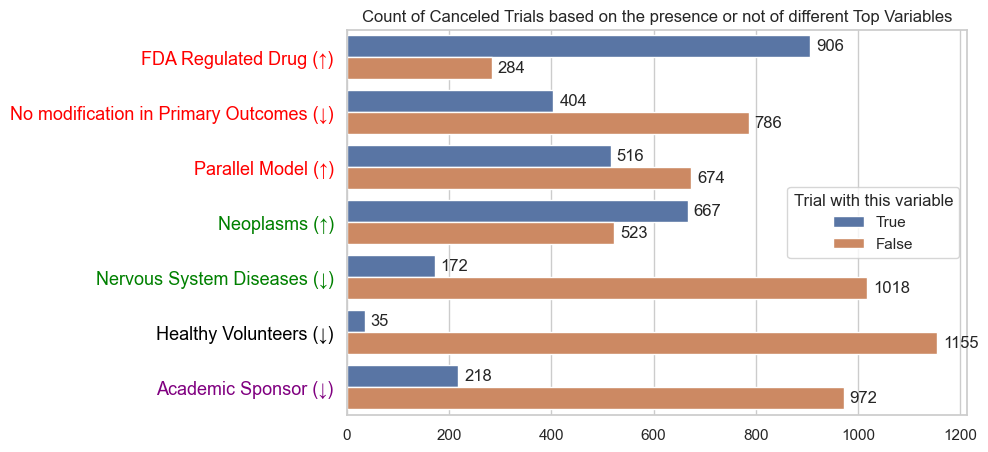

In [370]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Load the data
ct_raw = pd.read_pickle('clean_data/main_bigger3.pkl')

# Filter the data
ct_raw = ct_raw[ct_raw['overallStatus'] == 1]
ct_raw = ct_raw[ct_raw['PHASE2'] == True]
ct_raw = ct_raw[ct_raw['is_Rare'] == True]
ct_rawr = ct_raw[(ct_raw['startDate'] >= 2019) & (ct_raw['startDate'] <= 2022)]

# Select the relevant columns
ct = ct_raw[['isfdaregulateddrug', 'primaryOutcomesSame', 'interventionModel_PARALLEL', 
             'bb_mesh:Neoplasms', 'bb_mesh:Nervous System ', 'healthyVolunteers', 
             'sponsor_class_UNIVERSITY']]

new_names = ['FDA Regulated Drug (↑)', 'No modification in Primary Outcomes (↓)', 'Parallel Model (↑)', 'Neoplasms (↑)',
             'Nervous System Diseases (↓)', 'Healthy Volunteers (↓)', 'Academic Sponsor (↓)']
ct.columns = new_names

# List of variables to count
variables = ['FDA Regulated Drug (↑)', 'No modification in Primary Outcomes (↓)', 'Parallel Model (↑)', 'Neoplasms (↑)',
             'Nervous System Diseases (↓)', 'Healthy Volunteers (↓)', 'Academic Sponsor (↓)']

# Create a DataFrame to store the counts
counts = pd.DataFrame(columns=['Variable', 'Value', 'Count'])

# Count the number of True and False values for each variable
for var in variables:
    true_count = ct[var].sum()
    false_count = len(ct) - true_count
    counts = pd.concat([
        counts, 
        pd.DataFrame({
            'Variable': [var, var], 
            'Trial with this variable': ['True', 'False'], 
            'Count': [true_count, false_count]
        })
    ], ignore_index=True)

# Filter out rows with a count of 0
counts = counts[counts['Count'] > 0]

# Define a colormap for the Y-axis labels
colormap = mcolors.ListedColormap(['red', 'red', 'red', 'green', 'green', 'black', 'purple'])
color_mapping = dict(zip(variables, colormap.colors))

# Set the style for seaborn
sns.set(style="whitegrid")

# Plot the counts
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Count', y='Variable', hue='Trial with this variable', data=counts, orient='h')

# Add numerical labels to each bar, skipping labels for bars with a width of 0
for p in ax.patches:
    width = p.get_width()
    if width > 0:  # Only add labels for bars with a positive width
        ax.text(width + max(counts['Count']) * 0.01, 
                p.get_y() + p.get_height() / 2, 
                f'{int(width)}', 
                va='center')

# Set the color of the Y-axis labels
y_labels = [label.get_text() for label in ax.get_yticklabels()]
colors = [color_mapping[label] for label in y_labels]
for tick_label, color in zip(ax.get_yticklabels(), colors):
    tick_label.set_color(color)

# Remove the Y-axis and X-axis labels
#increase font size of y labels
plt.yticks(fontsize=13)
plt.xticks(fontsize=11)
plt.ylabel('')
plt.xlabel('')
plt.title('Count of Canceled Trials based on the presence or not of different Top Variables')
plt.show()


In [195]:
import warnings
import pandas as pd
ct_raw = pd.read_pickle('clean_data/main_bigger3.pkl')
stop = pd.read_csv('clean_data/why_stop.csv')

warnings.filterwarnings('ignore')
print(ct_raw.shape)
print(ct_raw[ct_raw['is_Rare']==True]['overallStatus'].value_counts())
print(ct_raw[ct_raw['is_Rare']==False]['overallStatus'].value_counts())


"""

# wrongly labelled as enrollment related
exclude_nct_ids = [
    'NCT02409862', 'NCT03048461', 'NCT03436953', 'NCT03752242', 'NCT03789149', 'NCT03801889', 
    'NCT03805841', 'NCT03937791', 'NCT03940248', 'NCT03970109', 'NCT04084366', 'NCT04099888', 
    'NCT04109144', 'NCT04290871', 'NCT04327986', 'NCT04353037', 'NCT04358068', 'NCT04404361', 
    'NCT04429880', 'NCT04455503', 'NCT04465916', 'NCT04515394', 'NCT04555096', 'NCT05087914', 
    'NCT05110599', 'NCT05146882', 'NCT05161533', 'NCT05193279', 'NCT05268926', 'NCT05321498', 
    'NCT05335486', 'NCT05445882', 'NCT05653427', 'NCT03450018', 'NCT04549025', 'NCT05370040', 
    'NCT06400264'
]

# Exclude the specified nct_id values from the stop DataFrame
stop = stop[~stop['nct_id'].isin(exclude_nct_ids)]

mask = (stop['category'] == 'enrollment_accrual_related') & (stop['num_reason'] == 1)

# Get the indices of 'ct_raw' that match the condition in 'stop'
indices_to_exclude = stop[mask]['nct_id'].unique()

# Filter 'ct_raw' to exclude the matching indices
ct_raw = ct_raw[~ct_raw.index.isin(indices_to_exclude)]



print(ct_raw.shape)
print(ct_raw[ct_raw['is_Rare']==True]['overallStatus'].value_counts())
print(ct_raw[ct_raw['is_Rare']==False]['overallStatus'].value_counts())"""

(17433, 610)
overallStatus
0    3634
1    1993
Name: count, dtype: int64
overallStatus
0    9481
1    2325
Name: count, dtype: int64


"\n\n# wrongly labelled as enrollment related\nexclude_nct_ids = [\n    'NCT02409862', 'NCT03048461', 'NCT03436953', 'NCT03752242', 'NCT03789149', 'NCT03801889', \n    'NCT03805841', 'NCT03937791', 'NCT03940248', 'NCT03970109', 'NCT04084366', 'NCT04099888', \n    'NCT04109144', 'NCT04290871', 'NCT04327986', 'NCT04353037', 'NCT04358068', 'NCT04404361', \n    'NCT04429880', 'NCT04455503', 'NCT04465916', 'NCT04515394', 'NCT04555096', 'NCT05087914', \n    'NCT05110599', 'NCT05146882', 'NCT05161533', 'NCT05193279', 'NCT05268926', 'NCT05321498', \n    'NCT05335486', 'NCT05445882', 'NCT05653427', 'NCT03450018', 'NCT04549025', 'NCT05370040', \n    'NCT06400264'\n]\n\n# Exclude the specified nct_id values from the stop DataFrame\nstop = stop[~stop['nct_id'].isin(exclude_nct_ids)]\n\nmask = (stop['category'] == 'enrollment_accrual_related') & (stop['num_reason'] == 1)\n\n# Get the indices of 'ct_raw' that match the condition in 'stop'\nindices_to_exclude = stop[mask]['nct_id'].unique()\n\n# Filt

In [196]:
# print all the columns that are not boolean
non_bool_cols = ct_raw.columns[ct_raw.dtypes != 'bool']
# print the columns type


# Convert all other columns to boolean, except those in non_bool_cols
for col in ct_raw.columns:
    if col not in non_bool_cols:
        ct_raw[col] = ct_raw[col].astype(bool)
        
to_rmv=['enrolled_less_than_orig_enroll', 'less_than_75_orig_enroll','enrollmentCountSame','less_than_90_orig_enroll', 'less_than_50_orig_enroll', 'more_than_50_orig_enroll','more_than_75_orig_enroll','bb_mesh:Rare ']

ct_raw.drop(columns=to_rmv,inplace=True)



In [197]:

ct_raw = ct_raw[ct_raw['PHASE2']==True]
ct_rawr = ct_raw[ct_raw['is_Rare']==True]
ct_rawn = ct_raw[ct_raw['is_Rare']==False]

ct_rawr.drop(columns=['is_Rare','PHASE2'],inplace=True)
ct_rawn.drop(columns=['is_Rare','PHASE2'],inplace=True)









ct_fullr = ct_rawr.copy()
ct_fulln = ct_rawn.copy()



ct_rawr = ct_rawr[(ct_rawr['startDate'] >=2019)&(ct_rawr['startDate'] <=2022)]
ct_rawr.drop(columns=['startDate'],inplace=True)

ct_rawn = ct_rawn[(ct_rawn['startDate'] >=2019)&(ct_rawn['startDate'] <=2022)]
ct_rawn.drop(columns=['startDate'],inplace=True)





In [198]:
"""xxx = ct_rawn[(ct_rawn['Gland and Hormone Related Diseases']==True)]
### plot values 
xxx['Neoplasms'].value_counts()
"""

"xxx = ct_rawn[(ct_rawn['Gland and Hormone Related Diseases']==True)]\n### plot values \nxxx['Neoplasms'].value_counts()\n"

In [199]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score
from collections import OrderedDict
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.cluster import DBSCAN
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, average_precision_score, classification_report, confusion_matrix, 
                             f1_score, precision_recall_curve, precision_score, recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, 
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler,RobustScaler,PowerTransformer,QuantileTransformer
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [200]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
import seaborn as sns
import numpy as np

def LR_model(X, y):
    # Splitting the dataset into training and testing sets
    X_trainx, X_test, y_trainx, y_test = train_test_split(X, y, test_size=0.5, random_state=3)

    ros = RandomOverSampler(random_state=42)
    # Fit RandomOverSampler on the training data
    X_train, y_train = ros.fit_resample(X_trainx, y_trainx)
    feature_names = X_train.columns

    model = LogisticRegression(C=0.30001000000000005, penalty='l1', random_state=0, class_weight='balanced',solver='liblinear')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)

    threshold = 0.53
    y_pred = (y_pred_prob[:, 1] >= threshold).astype(int)

    model_name = 'Logistic Regression'
    accuracy = accuracy_score(y_test, y_pred)
    xprecision = precision_score(y_test, y_pred)
    xrecall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {xprecision:.3f}")
    print(f"Recall: {xrecall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print("Confusion Matrix:")

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for ' + model_name)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob[:, 1])
    pr_auc = auc(recall, precision)

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    print(f"PR-AUC: {pr_auc:.3f}")
    print(f"ROC-AUC: {roc_auc:.3f}")

    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve for ' + model_name)
    plt.legend(loc="lower right")

    plt.subplot(1, 3, 3)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for ' + model_name)
    plt.legend(loc="lower left")

    plt.show()

  
    # Define the scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'log_loss': 'neg_log_loss',
        'auc': 'roc_auc',
        'f1': 'f1',
        'pr_auc': 'average_precision',
        'recall': 'recall',
        'precision' : 'precision'
    }

    # Perform cross-validation
    results = cross_validate(model, X, y, cv=10, scoring=list(scoring.values()), return_train_score=False)

    print('K-fold cross-validation results:')
    metrics_list = []

    # Iterate over the scoring metrics
    for sc in range(len(scoring)):
        metric_name = list(scoring.keys())[sc]
        mean_score = -results['test_%s' % list(scoring.values())[sc]].mean() if list(scoring.values())[sc] == 'neg_log_loss' else results['test_%s' % list(scoring.values())[sc]].mean()
        std_score = results['test_%s' % list(scoring.values())[sc]].std()
        metrics_list.append({'Metric': metric_name, 'Mean Score': mean_score, 'Standard Deviation': std_score})
        print(model.__class__.__name__ + " average %s: %.3f ± %.2f" % (metric_name, mean_score, std_score))

    # Convert the list of metrics to a DataFrame
    cv_df = pd.DataFrame(metrics_list)

    # get a prediction df
    pred_df = pd.DataFrame(y_test)
    pred_df.reset_index(drop=False, inplace=True)

    X_train = X_train.astype(int)
    X_test = X_test.astype(int)
    # append values of y_pred to y_test
    pred_df['predicted'] = y_pred
    results = {
        'pred_df': pred_df,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'accuracy': accuracy,
        'precision': xprecision,
        'recall': xrecall,
        'f1': f1,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'model': model,
        'CV_scoring': cv_df
    }
    return results

def XGB_model(X,y):
    # Splitting the dataset into training and testing sets
    X_trainx, X_test, y_trainx, y_test = train_test_split(X, y, test_size=0.5, random_state=3)

    ros = RandomOverSampler(random_state=42)
    # Fit RandomOverSampler on the training data
    X_train, y_train = ros.fit_resample(X_trainx, y_trainx)
    feature_names = X_train.columns


    model = XGBClassifier(random_state=42, use_label_encoder=True, eval_metric='logloss', class_weight='balanced',
                          learning_rate= 0.1, max_depth= 5, n_estimators= 300, subsample= 0.8)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)


    threshold = 0.6
    y_pred= (y_pred_prob[:, 1] >= threshold).astype(int)

    model_name = 'XGBoost'
    accuracy = accuracy_score(y_test, y_pred)
    xprecision = precision_score(y_test, y_pred)
    xrecall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {xprecision:.3f}")

    print(f"Recall: {xrecall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print("Confusion Matrix:")

    # Plotting the confusion matrix
    plt.figure(figsize=(18,6))
    plt.subplot(1, 3, 1)  # 1 row, 2 columns, 1st subplot
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for '+ model_name)

    # Detailed classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Calculate precision-recall pairs for different probability thresholds
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob[:, 1])
    pr_auc = auc(recall, precision)

    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)


    print(f"PR-AUC: {pr_auc:.3f}")
    print(f"ROC-AUC: {roc_auc:.3f}")



    # Plotting ROC Curve in the first subplot
    plt.subplot(1, 3, 2)  # 1 row, 2 columns, 1st subplot
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve for '+ model_name)
    plt.legend(loc="lower right")

    # Plotting Precision-Recall Curve in the second subplot
    plt.subplot(1, 3, 3)  # 1 row, 2 columns, 2nd subplot
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for '+ model_name)
    plt.legend(loc="lower left")

    plt.show()



    # Define the scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'log_loss': 'neg_log_loss',
        'auc': 'roc_auc',
        'f1': 'f1',
        'pr_auc': 'average_precision',
        'recall': 'recall',
        'precision' : 'precision'
    }

    # Perform cross-validation
    results = cross_validate(model, X, y, cv=10, scoring=list(scoring.values()), return_train_score=False)

    print('K-fold cross-validation results:')
    metrics_list = []

    # Iterate over the scoring metrics
    for sc in range(len(scoring)):
        metric_name = list(scoring.keys())[sc]
        mean_score = -results['test_%s' % list(scoring.values())[sc]].mean() if list(scoring.values())[sc] == 'neg_log_loss' else results['test_%s' % list(scoring.values())[sc]].mean()
        std_score = results['test_%s' % list(scoring.values())[sc]].std()
        metrics_list.append({'Metric': metric_name, 'Mean Score': mean_score, 'Standard Deviation': std_score})
        print(model.__class__.__name__ + " average %s: %.3f ± %.2f" % (metric_name, mean_score, std_score))

    # Convert the list of metrics to a DataFrame
    cv_df = pd.DataFrame(metrics_list)

    # get a prediction df
    pred_df = pd.DataFrame(y_test)
    pred_df.reset_index(drop=False, inplace=True)

    X_train = X_train.astype(int)
    X_test = X_test.astype(int)
    # append values of y_pred to y_test
    pred_df['predicted'] = y_pred
    results = {
        'pred_df': pred_df,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'accuracy': accuracy,
        'precision': xprecision,
        'recall': xrecall,
        'f1': f1,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'model': model,
        'CV_scoring': cv_df
    }
    return results

In [201]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import cross_validate

def plot_validation(dict, ct_full):
    # Filter dataframe for startDate 2023 and 2024
    df_filtered = ct_full[ct_full['startDate'].isin([2023, 2024])]
    df_filtered.drop('startDate', axis=1, inplace=True)
    
    X = df_filtered.drop('overallStatus', axis=1)
    y = df_filtered['overallStatus']
    
    model = dict['model']
    metrics = ['precision','f1','auc','pr_auc','accuracy', 'recall', 'log_loss']
    # Define the scoring metrics
    scoring = {
        'precision' : 'precision',
        'f1': 'f1',
        'auc': 'roc_auc',
        'pr_auc': 'average_precision',
        'accuracy': 'accuracy',
        'recall': 'recall',
        'log_loss': 'neg_log_loss'
    }

    # Perform cross-validation
    results = cross_validate(model, X, y, cv=10, scoring=list(scoring.values()), return_train_score=False)

    print('K-fold cross-validation results:')
    metrics_list = []

    # Iterate over the scoring metrics
    for sc in range(len(scoring)):
        metric_name = list(scoring.keys())[sc]
        mean_score = -results['test_%s' % list(scoring.values())[sc]].mean() if list(scoring.values())[sc] == 'neg_log_loss' else results['test_%s' % list(scoring.values())[sc]].mean()
        std_score = results['test_%s' % list(scoring.values())[sc]].std()
        metrics_list.append({'Metric': metric_name, 'Mean Score': mean_score, 'Standard Deviation': std_score})
        print(model.__class__.__name__ + " average %s: %.3f ± %.2f" % (metric_name, mean_score, std_score))
    
    # Create and print the DataFrame with metrics
    metrics_df = pd.DataFrame(metrics_list)
    print(metrics_df)

In [202]:
## print LR coefficients
def get_coeff(model,feature_names,col_key_name):

    coefficients = model.coef_[0]  # Coefficients for the features

    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    coef_df['Absolute Coefficient'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)
    coef_df['Absolute_Coefficient'] = coef_df['Coefficient'].abs()
    
    if col_key_name == 'top30':
        # Sort the DataFrame based on the absolute values in descending order and take the top 30
        top_30 = coef_df.sort_values(by='Absolute_Coefficient', ascending=False).head(30)

        # Plotting with feature names as y-axis labels
        plt.figure(figsize=(10, 8))
        top_30.plot(kind='barh', x='Feature', y='Coefficient', color='skyblue')
        plt.xlabel('Coefficient Value')
        plt.title('Top 30 Absolute Coefficient Values')
        plt.gca().invert_yaxis()  # To display the highest value at the top
        plt.show()

    
    # Existing code for creating lists for each prefix
    prefixes = ["continent", "country", "condition_keyword:", "mesh","bb_mesh", "org_name", "lead_sponsor","float"]
    columns_by_prefix = {prefix: [] for prefix in prefixes}

    # Populate the lists with column names that start with the respective prefixes
    for col in ct_raw.columns:
        matched = False
        for prefix in prefixes:
            if col.startswith(prefix):
                columns_by_prefix[prefix].append(col)
                matched = True
                break
        if not matched and col != 'overallStatus' and col != 'startDate':
            # If the column doesn't match any prefix, add it to a 'remaining' list
            if 'remaining' not in columns_by_prefix:
                columns_by_prefix['remaining'] = []
            columns_by_prefix['remaining'].append(col)

    # Create a new ordered dictionary with 'remaining' first, if it exists
    ordered_columns_by_prefix = OrderedDict()
    if 'remaining' in columns_by_prefix:
        ordered_columns_by_prefix['remaining'] = columns_by_prefix['remaining']
    for prefix in prefixes:
        ordered_columns_by_prefix[prefix] = columns_by_prefix[prefix]

    # Use ordered_columns_by_prefix for ordered access

    # Step 1: Define a mapping of old keys to new keys
    key_mapping = {
        'remaining': 'main',
        'continent': 'Continents compared to Western Europe',
        'country': 'Countries compared to France',
    }

    # Step 2: Iterate over the old dictionary to create a new one with the new keys
    new_ordered_columns_by_prefix = {key_mapping.get(old_key, old_key): value for old_key, value in ordered_columns_by_prefix.items()}

    # Now, new_ordered_columns_by_prefix contains the updated keys
    for name, prefixes in new_ordered_columns_by_prefix.items():
        if name == col_key_name:
            # Filter coef_df based on whether 'Feature' starts with any of the specified prefixes
            relevant_columns = [col for col in coef_df['Feature'] if any(col.startswith(prefix) for prefix in prefixes)]
            
            # Now, filter coef_df to only include rows where 'Feature' is in relevant_columns
            filtered_coef_df = coef_df[coef_df['Feature'].isin(relevant_columns)]
            filtered_coef_df = filtered_coef_df[filtered_coef_df['Absolute Coefficient'] > 0]
            filtered_coef_df = filtered_coef_df.sort_values(by='Coefficient')

            filtered_coef_df_positive = filtered_coef_df[filtered_coef_df['Coefficient'] > 0]
            filtered_coef_df_negative = filtered_coef_df[filtered_coef_df['Coefficient'] < 0]

            # Check if filtered_coef_df_positive is not empty
            if not filtered_coef_df_positive.empty:
                plt.figure(figsize=(10, 12))
                plt.rcParams.update({'font.size': 16})
                plt.barh(filtered_coef_df_positive['Feature'], filtered_coef_df_positive['Coefficient'])
                plt.xlabel('Coefficient Value')
                plt.ylabel('Feature')
                plt.title(f'{name} Feature Coefficients that increase probability of early Termination')
                plt.grid(True)
                plt.show()

            # Check if filtered_coef_df_negative is not empty
            if not filtered_coef_df_negative.empty:
                plt.figure(figsize=(10, 12))
                plt.rcParams.update({'font.size': 16})
                plt.barh(filtered_coef_df_negative['Feature'], filtered_coef_df_negative['Coefficient'])
                plt.xlabel('Coefficient Value')
                plt.ylabel('Feature')
                plt.title(f'{name} Feature Coefficients that decrease probability of early Termination')
                plt.grid(True)
                plt.show()
    if col_key_name == "float":
            # Filter coef_df based on whether 'Feature' starts with any of the specified prefixes
            
            # Now, filter coef_df to only include rows where 'Feature' is in relevant_columns
            filtered_coef_df = coef_df[coef_df['Feature'].isin(non_bool_cols)]
            filtered_coef_df = filtered_coef_df[filtered_coef_df['Absolute Coefficient'] > 0]
            filtered_coef_df = filtered_coef_df.sort_values(by='Coefficient')

            # Check if filtered_coef_df_positive is not empty
            if not filtered_coef_df.empty:
                plt.figure(figsize=(10, 12))
                plt.rcParams.update({'font.size': 16})
                plt.barh(filtered_coef_df['Feature'], filtered_coef_df['Coefficient'])
                plt.xlabel('Coefficient Value')
                plt.ylabel('Feature')
                plt.title(f'{name} Feature Coefficients that increase probability of early Termination')
                plt.grid(True)
                plt.show()
    if col_key_name == "masking":
        # Filter coef_df based on whether 'Feature' starts with any of the specified prefixes
        
        # Now, filter coef_df to only include rows where 'Feature' is in relevant_columns
        filtered_coef_df = coef_df[coef_df['Feature'].isin(masking_col)]
        filtered_coef_df = filtered_coef_df[filtered_coef_df['Absolute Coefficient'] > 0]
        filtered_coef_df = filtered_coef_df.sort_values(by='Coefficient')

        # Check if filtered_coef_df_positive is not empty
        if not filtered_coef_df.empty:
            plt.figure(figsize=(10, 12))
            plt.rcParams.update({'font.size': 16})
            plt.barh(filtered_coef_df['Feature'], filtered_coef_df['Coefficient'])
            plt.xlabel('Coefficient Value')
            plt.ylabel('Feature')
            plt.title(f'{name} Feature Coefficients that increase probability of early Termination')
            plt.grid(True)
            plt.show()
          

In [203]:
# list of all columns startin with the prefixe "continent"
continent_col = [col for col in ct_raw.columns if col.startswith('continent')]
country_col = [col for col in ct_raw.columns if col.startswith('country')]
mesh_col = [col for col in ct_raw.columns if col.startswith('mesh')]
org_col = [col for col in ct_raw.columns if col.startswith('org_name')]
lead_col = [col for col in ct_raw.columns if col.startswith('lead_sponsor_')]
bb_mesh = [col for col in ct_raw.columns if col.startswith('bb_mesh')]
### ordinal columns

phases_col = ['PHASE1','PHASE2','PHASE3']
enrollment_col_r=['original_enrollment_count','enrolled_less_than_orig_enroll', 'less_than_90_orig_enroll', 'less_than_75_orig_enroll', 'less_than_50_orig_enroll', 'more_than_50_orig_enroll']
exp_drug_col =['experimental_only','exp_against_placebo','exp_against_active_comp']
collaborators_col = [col for col in ct_raw.columns if col.startswith('collaborators =_')]
centers_col = [col for col in ct_raw.columns if col.startswith('total_centers_count =_')]
enrollment_col = [col for col in ct_raw.columns if col.startswith('enrollment_count_cat_')]
entity_col = [col for col in ct_raw.columns if any(col.startswith(prefix) for prefix in ['sponsor_class_', 'org_study_class'])]

intervention_col = [col for col in ct_raw.columns if col.startswith('interventionModel_')]

primarypurpose_col = [col for col in ct_raw.columns if any(col.startswith(prefix) for prefix in ['primaryPurpose', 'intervention_type_'])]
masking_1 = [col for col in ct_raw.columns if any(col.startswith(prefix) for prefix in ['mask_type_'])]
masking_2 = [col for col in ct_raw.columns if any(col.endswith(suffix) for suffix in ['_masked'])]
masking_col = masking_1+masking_2

excluded_cols = masking_col+phases_col +bb_mesh+ collaborators_col + centers_col + enrollment_col + continent_col + country_col + mesh_col + org_col + lead_col + entity_col + intervention_col + primarypurpose_col
main_col = [col for col in ct_raw.columns[1:] if col not in excluded_cols]
categ_col = collaborators_col+centers_col+enrollment_col

# drop columns from categ_col
#ct_raw.drop(columns=categ_col, inplace=True)

In [204]:
# List of DataFrames
dfs = [ct_rawr, ct_fullr, ct_rawn, ct_fulln]

# Function to drop columns with all the same values, except for 'overallStatus'
def drop_constant_columns(df):
    # Identify columns with more than one unique value or the column 'overallStatus'
    cols_to_keep = df.nunique() > 1
    cols_to_keep['overallStatus'] = True
    return df.loc[:, cols_to_keep]

# Apply the function to each DataFrame
ct_rawr, ct_fullr, ct_rawn, ct_fulln = [drop_constant_columns(df) for df in dfs]

In [205]:
%%jmd 
# Logistic Regression

# Logistic Regression

In [206]:
%%jmd
## Logistic Regression Model
[//]: <> (-.- tabset tabset-pills)

## Logistic Regression Model
<span class='pj-token' style='display: none;'>tabset|O_O|tabset-pills</span>

- Logistic Regression with RandomOverSampler
- C=0.30001000000000005, penalty='l1', random_state=0, solver='liblinear'
- threshold set to 0.53
- The goal of this model is to maximize the amount of correct predictions rather than high accuracy

In [207]:
%%jmd
### Rare Diseases phase 2

### Rare Diseases phase 2

Accuracy: 0.675
Precision: 0.559
Recall: 0.640
F1 Score: 0.597
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       857
           1       0.56      0.64      0.60       514

    accuracy                           0.68      1371
   macro avg       0.66      0.67      0.66      1371
weighted avg       0.69      0.68      0.68      1371

PR-AUC: 0.619
ROC-AUC: 0.741


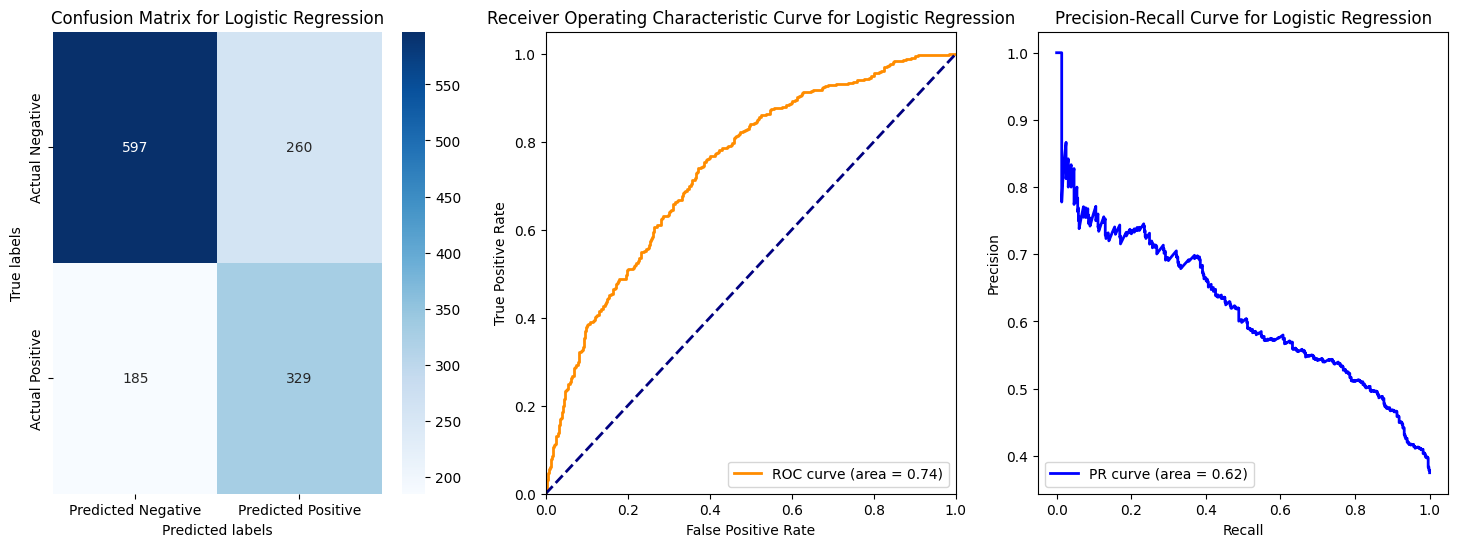

K-fold cross-validation results:
LogisticRegression average accuracy: 0.680 ± 0.05
LogisticRegression average log_loss: 0.596 ± 0.06
LogisticRegression average auc: 0.749 ± 0.06
LogisticRegression average f1: 0.618 ± 0.04
LogisticRegression average pr_auc: 0.664 ± 0.07
LogisticRegression average recall: 0.666 ± 0.06
LogisticRegression average precision: 0.583 ± 0.06


In [208]:
# Assuming 'overallStatus' is your target variable and the rest are features

X = ct_rawr.drop('overallStatus', axis=1)
y = ct_rawr['overallStatus']
logreg_noise = LR_model(X,y)

In [209]:
plot_validation(logreg_noise, ct_fullr)

K-fold cross-validation results:
LogisticRegression average precision: 0.872 ± 0.06
LogisticRegression average f1: 0.758 ± 0.13
LogisticRegression average auc: 0.744 ± 0.10
LogisticRegression average pr_auc: 0.900 ± 0.05
LogisticRegression average accuracy: 0.696 ± 0.14
LogisticRegression average recall: 0.685 ± 0.18
LogisticRegression average log_loss: 0.575 ± 0.14
      Metric  Mean Score  Standard Deviation
0  precision    0.872457            0.063090
1         f1    0.758364            0.130913
2        auc    0.743846            0.099072
3     pr_auc    0.900465            0.048625
4   accuracy    0.696405            0.144491
5     recall    0.685256            0.176077
6   log_loss    0.574721            0.142875


In [210]:
%%jmd
### Common Diseases phase 2

### Common Diseases phase 2

Accuracy: 0.701
Precision: 0.492
Recall: 0.642
F1 Score: 0.557
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.73      0.77      1417
           1       0.49      0.64      0.56       587

    accuracy                           0.70      2004
   macro avg       0.66      0.68      0.67      2004
weighted avg       0.73      0.70      0.71      2004

PR-AUC: 0.561
ROC-AUC: 0.751


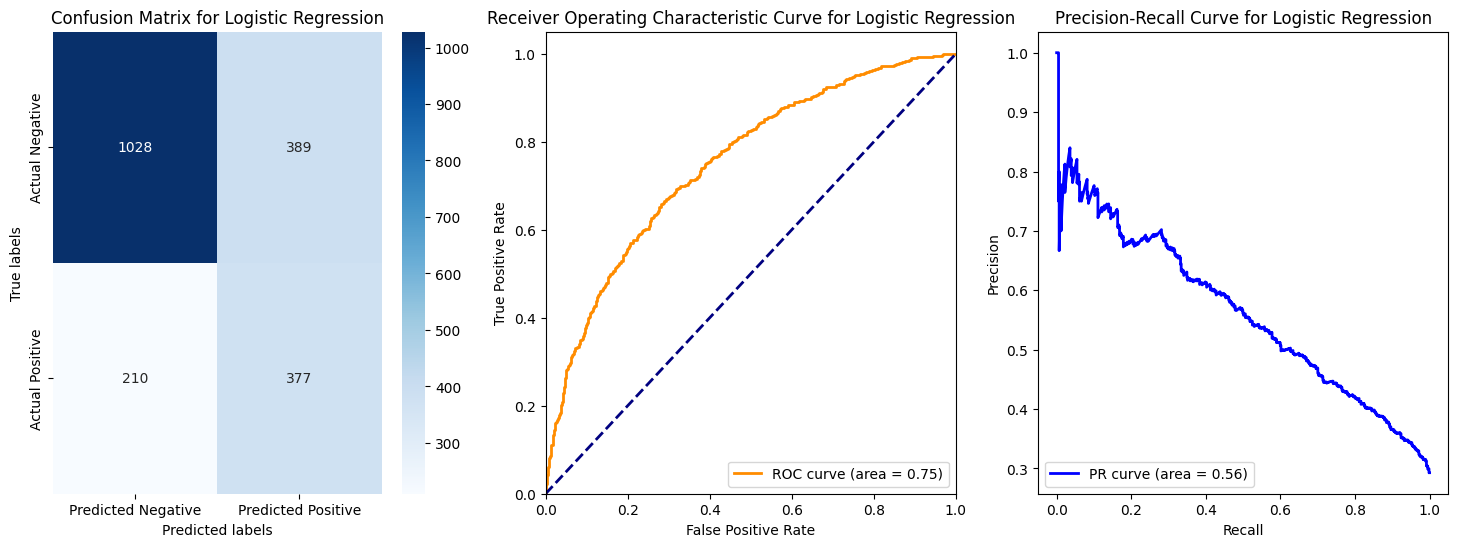

K-fold cross-validation results:
LogisticRegression average accuracy: 0.700 ± 0.05
LogisticRegression average log_loss: 0.582 ± 0.06
LogisticRegression average auc: 0.755 ± 0.04
LogisticRegression average f1: 0.566 ± 0.03
LogisticRegression average pr_auc: 0.584 ± 0.06
LogisticRegression average recall: 0.674 ± 0.07
LogisticRegression average precision: 0.497 ± 0.06


In [211]:
# Assuming 'overallStatus' is your target variable and the rest are features
X1 = ct_rawn.drop('overallStatus', axis=1)
y1 = ct_rawn['overallStatus']
logreg_noise1 = LR_model(X1,y1)

In [212]:
plot_validation(logreg_noise1, ct_fullr)

K-fold cross-validation results:
LogisticRegression average precision: 0.872 ± 0.06
LogisticRegression average f1: 0.758 ± 0.13
LogisticRegression average auc: 0.744 ± 0.10
LogisticRegression average pr_auc: 0.900 ± 0.05
LogisticRegression average accuracy: 0.696 ± 0.14
LogisticRegression average recall: 0.685 ± 0.18
LogisticRegression average log_loss: 0.575 ± 0.14
      Metric  Mean Score  Standard Deviation
0  precision    0.872457            0.063090
1         f1    0.758364            0.130913
2        auc    0.743846            0.099072
3     pr_auc    0.900465            0.048625
4   accuracy    0.696405            0.144491
5     recall    0.685256            0.176077
6   log_loss    0.574721            0.142875


In [213]:
# https://ing-bank.github.io/probatus/api/model_interpret.html
# pip install probatus
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from probatus.interpret import ShapModelInterpreter
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# Set the default figure background color to white
plt.rcParams['figure.facecolor'] = 'white'

# Initialize JavaScript visualization in Jupyter notebooks
shap.initjs()


In [214]:
def get_basic_shap(model, X_train, X_test):
    
    # Create a SHAP explainer object
    explainer = shap.Explainer(model, X_train)

    # Calculate SHAP values for the test set
    shap_values = explainer(X_test)
    
    return shap_values

In [215]:
%%jmd 
### Phase 2 RD

### Phase 2 RD

In [216]:
%%jmd 
#### Example Visualization of individual predictions
[//]: <> (-.- tabset tabset-pills)

#### Example Visualization of individual predictions
<span class='pj-token' style='display: none;'>tabset|O_O|tabset-pills</span>

In [217]:
shap_values = get_basic_shap(logreg_noise['model'], logreg_noise['X_train'], logreg_noise['X_test'])

pred_df = logreg_noise['pred_df']

In [218]:
%%jmd 
### phase 2 CD

### phase 2 CD

In [219]:
%%jmd 
#### Example Visualization of individual predictions
[//]: <> (-.- tabset tabset-pills)

#### Example Visualization of individual predictions
<span class='pj-token' style='display: none;'>tabset|O_O|tabset-pills</span>

In [220]:
shap_values = get_basic_shap(logreg_noise1['model'], logreg_noise1['X_train'], logreg_noise1['X_test'])

pred_df = logreg_noise1['pred_df']

In [221]:
%%jmd
## Overview of SHAP values importance by category

## Overview of SHAP values importance by category

In [222]:
%%jmd
## Extreme Gradient Boosting Model
[//]: <> (-.- tabset tabset-pills)

## Extreme Gradient Boosting Model
<span class='pj-token' style='display: none;'>tabset|O_O|tabset-pills</span>

- Extreme Gradient Boosting with RandomOverSampler
- random_state=42, use_label_encoder=True, eval_metric='logloss',learning_rate= 0.1, max_depth= 5, n_estimators= 300, subsample= 0.8
- threshold set to 0.60
- The goal of this model is to maximize the amount of correct predictions rather than high accuracy

In [223]:
%%jmd
### phase 2 RD

### phase 2 RD

Accuracy: 0.730
Precision: 0.662
Recall: 0.572
F1 Score: 0.614
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       857
           1       0.66      0.57      0.61       514

    accuracy                           0.73      1371
   macro avg       0.71      0.70      0.70      1371
weighted avg       0.72      0.73      0.73      1371

PR-AUC: 0.658
ROC-AUC: 0.770


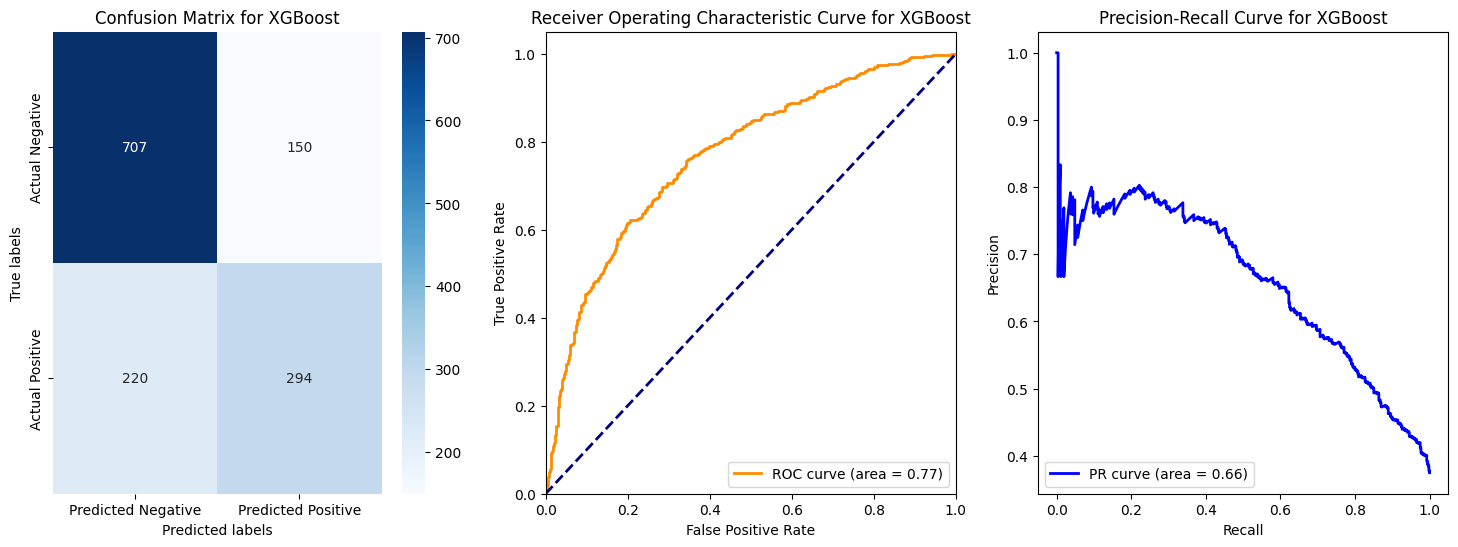

K-fold cross-validation results:
XGBClassifier average accuracy: 0.693 ± 0.04
XGBClassifier average log_loss: 0.625 ± 0.07
XGBClassifier average auc: 0.737 ± 0.05
XGBClassifier average f1: 0.574 ± 0.04
XGBClassifier average pr_auc: 0.642 ± 0.07
XGBClassifier average recall: 0.532 ± 0.05
XGBClassifier average precision: 0.633 ± 0.08


In [224]:
# Assuming 'overallStatus' is your target variable and the rest are features
X = ct_rawr.drop('overallStatus', axis=1)
y = ct_rawr['overallStatus']
xgb_noise = XGB_model(X,y)

In [225]:
%%jmd
### phase 2 CD

### phase 2 CD

Accuracy: 0.782
Precision: 0.672
Recall: 0.503
F1 Score: 0.575
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1417
           1       0.67      0.50      0.58       587

    accuracy                           0.78      2004
   macro avg       0.74      0.70      0.71      2004
weighted avg       0.77      0.78      0.77      2004

PR-AUC: 0.661
ROC-AUC: 0.803


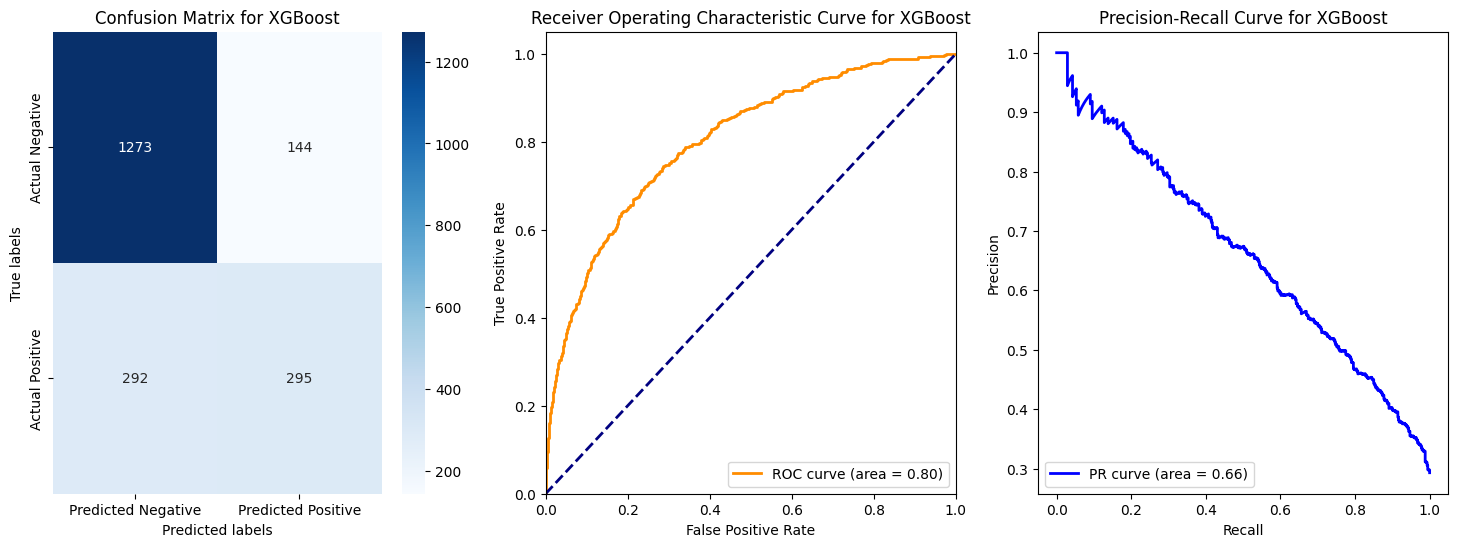

K-fold cross-validation results:
XGBClassifier average accuracy: 0.760 ± 0.03
XGBClassifier average log_loss: 0.528 ± 0.05
XGBClassifier average auc: 0.762 ± 0.05
XGBClassifier average f1: 0.508 ± 0.07
XGBClassifier average pr_auc: 0.605 ± 0.06
XGBClassifier average recall: 0.434 ± 0.08
XGBClassifier average precision: 0.639 ± 0.10


In [226]:

X1 = ct_rawn.drop('overallStatus', axis=1)
y1 = ct_rawn['overallStatus']
xgb_noise1 = XGB_model(X1,y1)

In [227]:
indiv = xgb_noise
shap_values = get_basic_shap(indiv['model'], indiv['X_train'], indiv['X_test'])

pred_df = indiv['pred_df']

In [228]:
indiv = xgb_noise1
shap_values = get_basic_shap(indiv['model'], indiv['X_train'], indiv['X_test'])

pred_df = indiv['pred_df']

 99%|===================| 1992/2004 [00:11<00:00]       

In [229]:
%%jmd
## Overview of SHAP values importance by category

## Overview of SHAP values importance by category

In [230]:
%%jmd
### phase 2 RD
[//]: <> (-.- tabset tabset-pills)

### phase 2 RD
<span class='pj-token' style='display: none;'>tabset|O_O|tabset-pills</span>

In [231]:
# Filter main_col to only include items that are in the columns of ct_rawr
org_col = [item for item in org_col if item in ct_rawr.columns]
lead_col = [item for item in lead_col if item in ct_rawr.columns]
continent_col = [item for item in continent_col if item in ct_rawr.columns]
country_col = [item for item in country_col if item in ct_rawr.columns]
mesh_col = [item for item in mesh_col if item in ct_rawr.columns]
bb_mesh = [item for item in bb_mesh if item in ct_rawr.columns]
phases_col = [item for item in phases_col if item in ct_rawr.columns]
enrollment_col_r = [item for item in enrollment_col_r if item in ct_rawr.columns]
main_col = [item for item in main_col if item in ct_rawr.columns]

In [232]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(feature_importance, top_n=30, threshold=0.5, var='main', model='Rare Diseases'):
    """
    Plots a horizontal bar plot of the mean_abs_shap_value_test column from the feature_importance DataFrame.
    
    Parameters:
    feature_importance (pd.DataFrame): DataFrame containing the feature importance values.
    top_n (int): Number of top features to display.
    threshold (float): Maximum value for the x-axis.
    var (str): Variable type.
    model (str): Model name.
    """
    # Sort the DataFrame by mean_abs_shap_value_test in descending order
    feature_importance = feature_importance.sort_values(by='mean_abs_shap_value_test', ascending=False)
    feature_importance = feature_importance.head(top_n)
    
    # Create the plot
    plt.figure(figsize=(8, 4))
    plt.barh(feature_importance.index, feature_importance['mean_abs_shap_value_test'])
    
    # Add labels and title
    plt.xlabel('Mean(|SHAP value|) average impact on model output magnitude')
    plt.ylabel('')
    plt.title('SHAP Feature Importance on ' + model + ' Test Set for ' + var + ' variables')
    
    # Set x-axis ticks
    if threshold <= 0.2:
        x_ticks = np.arange(0, threshold + 0.02, 0.02)
    else:
        x_ticks = np.arange(0, threshold + 0.05, 0.05)
    plt.xticks(x_ticks)
    
    # Add vertical grid lines
    plt.grid(axis='x', alpha=0.7)
    
    # Limit x range
    plt.xlim(0, threshold)
    
    # Invert y-axis to have the highest values at the top
    plt.gca().invert_yaxis()
    
    # Show the plot
    plt.show()

# Example usage:
# Assuming feature_importance is already defined
# plot_feature_importance(feature_importance, 10, 0.5)

In [233]:
shap_int = xgb_noise
shap_interpreter_r = ShapModelInterpreter(shap_int['model'])
feature_importance_r = shap_interpreter_r.fit_compute(shap_int['X_train'],shap_int['X_test'], shap_int['y_train'], shap_int['y_test'])
 
shap_int1 = xgb_noise1
shap_interpreter = ShapModelInterpreter(shap_int1['model'])
feature_importance = shap_interpreter.fit_compute(shap_int1['X_train'],shap_int1['X_test'], shap_int1['y_train'], shap_int1['y_test'])

100%|===================| 2003/2004 [00:11<00:00]        

In [234]:
feature_importance_r

mean_abs_shap_value_test  \
isfdaregulateddrug                                                  0.442332   
multi_city                                                          0.423210   
bb_mesh:Neoplasms                                                   0.339797   
primaryOutcomesSame                                                 0.323693   
original_enrollment_count                                           0.281926   
...                                                                      ...   
lead_sponsor_University of North Carolina, Chap...                  0.000000   
lead_sponsor_University of Oxford                                   0.000000   
lead_sponsor_University of Pennsylvania                             0.000000   
lead_sponsor_University of Texas Southwestern M...                  0.000000   
lead_sponsor_argenx                                                 0.000000   

                                                    mean_abs_shap_value_train  \
isfdaregulateddrug                                                   0.399893   
multi_city                                                           0.393140   
bb_mesh:Neoplasms                                                    0.357121   
primaryOutcomesSame                                                  0.344586   
original_enrollment_count                                            0.316751   
...                                                                       ...   
lead_sponsor_University of North Carolina, Chap...                   0.000000   
lead_sponsor_University of Oxford                                    0.000000   
lead_sponsor_University of Pennsylvania                              0.000000   
lead_sponsor_University of Texas Southwestern M...                   0.000000   
lead_sponsor_argenx                                                  0.000000   

                                                    mean_shap_value_test  \
isfdaregulateddrug                                             -0.076845   
multi_city                                                     -0.017839   
bb_mesh:Neoplasms                                              -0.020598   
primaryOutcomesSame                                             0.041907   
original_enrollment_count                                      -0.011596   
...                                                                  ...   
lead_sponsor_University of North Carolina, Chap...              0.000000   
lead_sponsor_University of Oxford                               0.000000   
lead_sponsor_University of Pennsylvania                         0.000000   
lead_sponsor_University of Texas Southwestern M...              0.000000   
lead_sponsor_argenx                                             0.000000   

                                                    mean_shap_value_train  
isfdaregulateddrug                                              -0.017668  
multi_city                                                       0.028915  
bb_mesh:Neoplasms                                               -0.037809  
primaryOutcomesSame                                              0.057773  
original_enrollment_count                                       -0.009782  
...                                                                   ...  
lead_sponsor_University of North Carolina, Chap...               0.000000  
lead_sponsor_University of Oxford                                0.000000  
lead_sponsor_University of Pennsylvania                          0.000000  
lead_sponsor_University of Texas Southwestern M...               0.000000  
lead_sponsor_argenx                                              0.000000  

[510 rows x 4 columns]

In [235]:
%%jmd
### Top 30 features

### Top 30 features

In [236]:
%%jmd
##### Rare Diseases

##### Rare Diseases

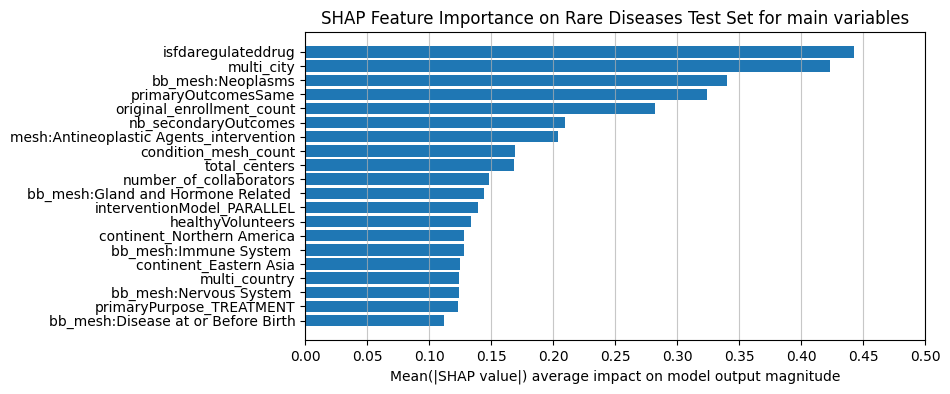

In [237]:
plot_feature_importance(feature_importance_r,20,0.5)

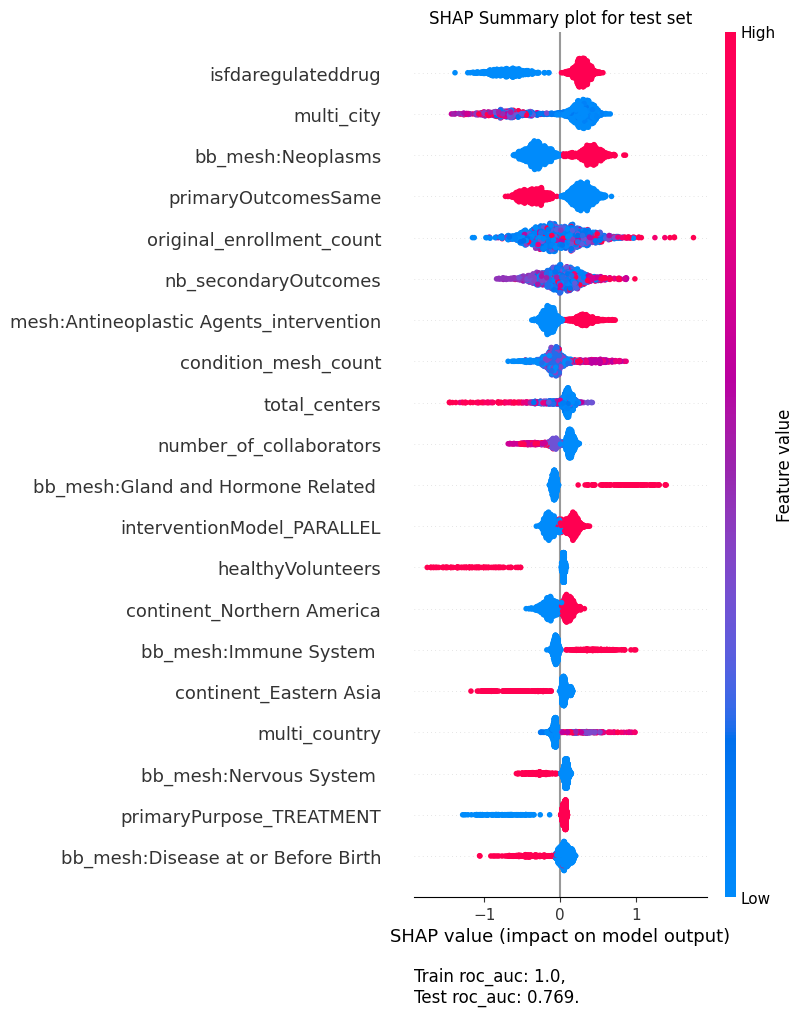

In [238]:

ax2 = shap_interpreter_r.plot('summary', max_display=20)

In [239]:
%%jmd
##### Common Diseases

##### Common Diseases

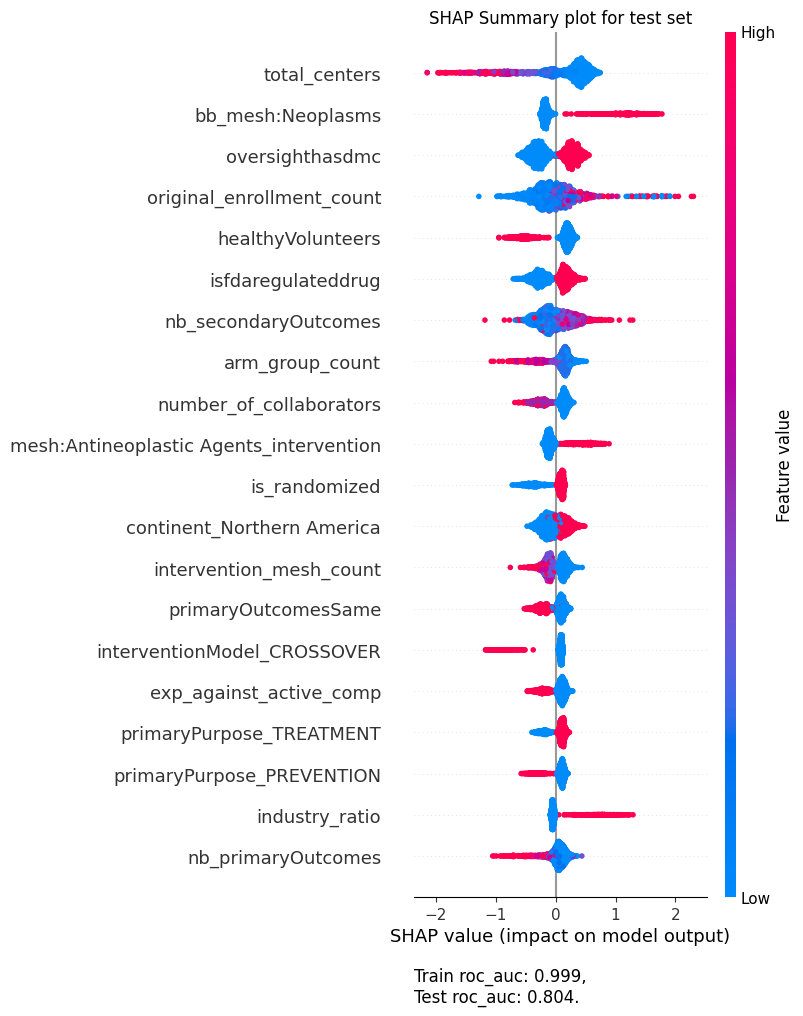

In [240]:
ax1 = shap_interpreter.plot('summary',max_display=20)


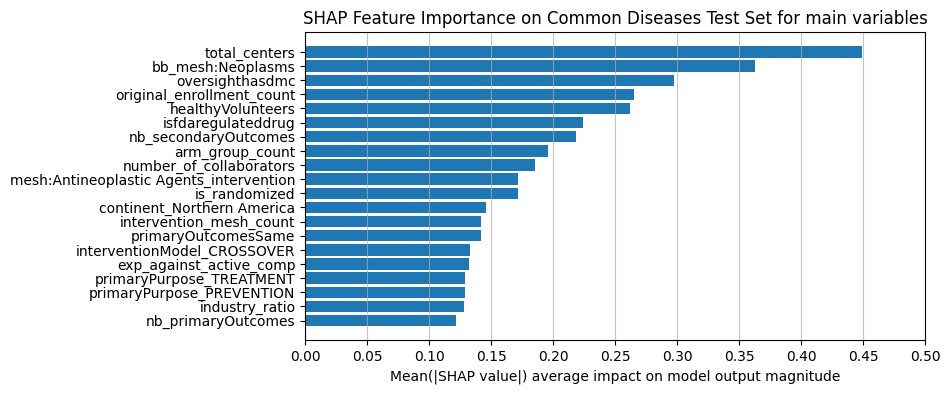

In [241]:

plot_feature_importance(feature_importance,20,0.5,model='Common Diseases')

In [242]:
%%jmd
### General Protocol variables

### General Protocol variables

In [243]:
main_colx =['oversighthasdmc',
 'isfdaregulateddrug',
 'nb_primaryOutcomes',
 'nb_secondaryOutcomes',
 'original_enrollment_count',
 'conditions_count',
 'condition_mesh_count',
 'intervention_mesh_count',
 'primaryOutcomesSame',
 'secondaryOutcomesSame',
 'orgFullNameSame',
 'responsiblePartySame',
 'leadSponsorSame',
 'PRINCIPAL_INVESTIGATOR_responsibleParty',
 'SPONSOR_INVESTIGATOR_responsibleParty']
main_col_dict = {'oversighthasdmc':'Data Monitoring Committee',
 'isfdaregulateddrug':'FDA Regulated Drug',
 'nb_primaryOutcomes':'Number of Primary Outcomes',
 'nb_secondaryOutcomes':'Number of Secondary Outcomes',
 'original_enrollment_count':'Theorical Enrollment Count',
 'conditions_count':'Number of Conditions Keywords',
 'condition_mesh_count':'Number of MeSH Terms for Conditions',
 'intervention_mesh_count':'Number of MeSH Terms for Interventions',
 'primaryOutcomesSame':'No modification in Primary Outcomes',
 'secondaryOutcomesSame':'No modification in Secondary Outcomes',
 'orgFullNameSame':'No change of study organization',
 'responsiblePartySame':'No change of responsible party',
 'leadSponsorSame':'No change of lead sponsor',
 'PRINCIPAL_INVESTIGATOR_responsibleParty':'PI as responsible party',
 'SPONSOR_INVESTIGATOR_responsibleParty':'Sponsor-PI as responsible party'}

## rename the indexes in feature_importance_r with the dict 
feature_importance_r.rename(index=main_col_dict,inplace=True)
## replace the columns names with the dict in shap_interpreter_r.X_test 
shap_interpreter_r.X_test.columns = shap_interpreter_r.X_test.columns.to_series().replace(main_col_dict).values
shap_interpreter_r.column_names = [main_col_dict.get(col, col) for col in shap_interpreter_r.column_names]

## rename the indexes in feature_importance_r with the dict 
feature_importance.rename(index=main_col_dict,inplace=True)
## replace the columns names with the dict in shap_interpreter_r.X_test 
shap_interpreter.X_test.columns = shap_interpreter.X_test.columns.to_series().replace(main_col_dict).values
shap_interpreter.column_names = [main_col_dict.get(col, col) for col in shap_interpreter.column_names]

## replace the main_colx with the dict in shap_interpreter_r.X_train
main_colx = [main_col_dict.get(item,item) for item in main_colx]
#rename columns names with the dict
ct_rawr = ct_rawr.rename(columns=main_col_dict)
ct_rawn = ct_rawn.rename(columns=main_col_dict)

In [244]:
%%jmd
#### Rare Diseases

#### Rare Diseases

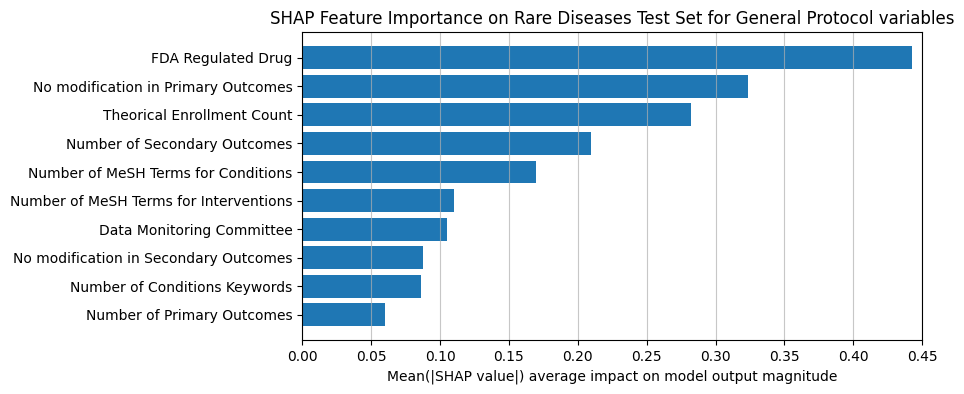

In [245]:
plot_feature_importance(feature_importance_r.loc[main_colx],10,0.45,var='General Protocol')

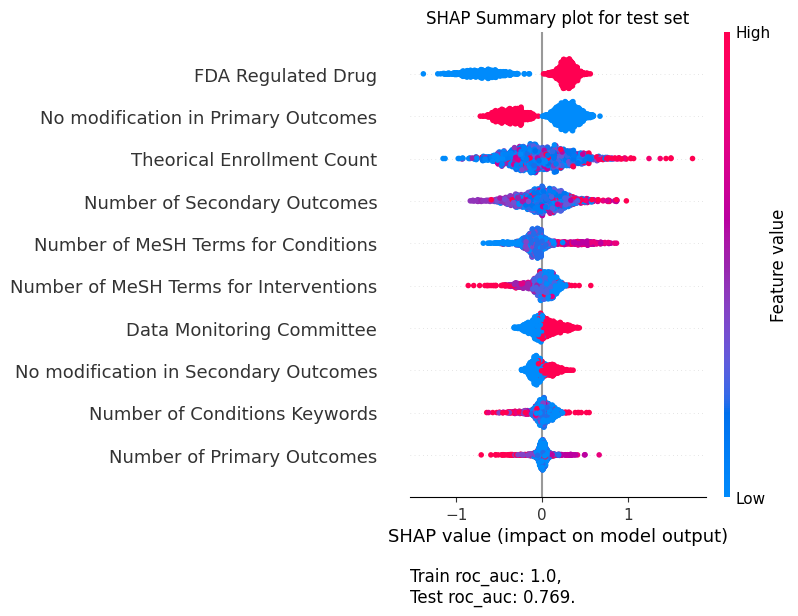

In [246]:
ax1 = shap_interpreter_r.plot('summary', target_columns=main_colx,max_display=10)

In [247]:
%%jmd 
#### Common Diseases

#### Common Diseases

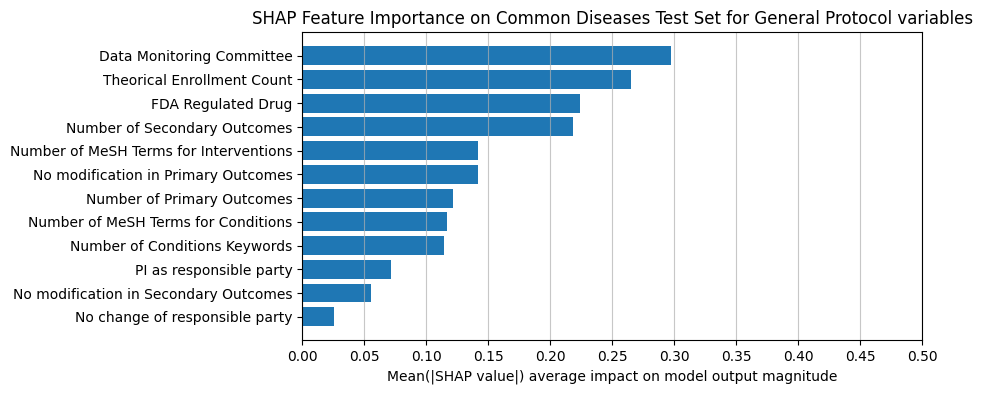

In [248]:
plot_feature_importance(feature_importance.loc[main_colx],12,0.5,var='General Protocol',model='Common Diseases')

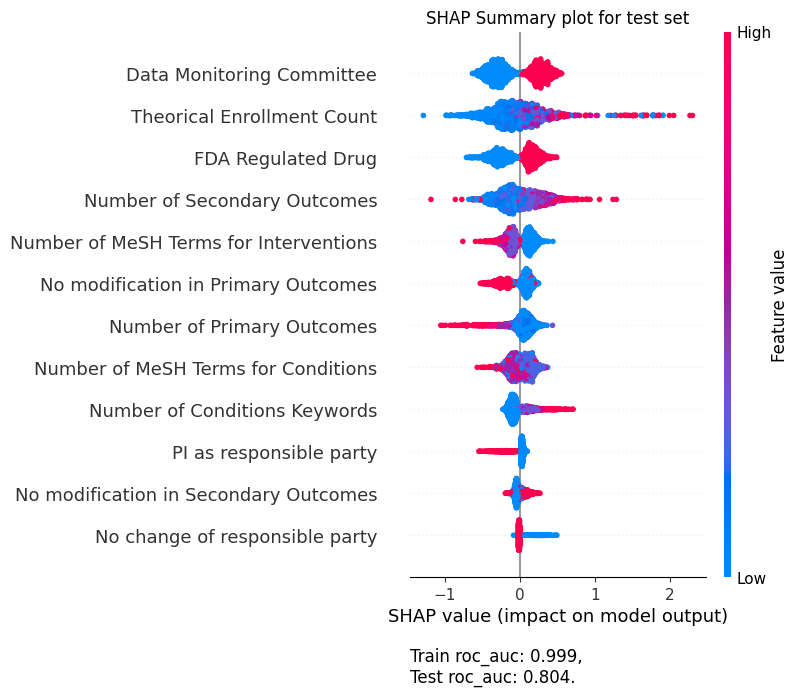

In [249]:
ax1 = shap_interpreter.plot('summary', target_columns=main_colx,max_display=12)

In [250]:
%%jmd
### Multi-phases and Experimental Type

### Multi-phases and Experimental Type

In [251]:
%%jmd
#### Rare Diseases

#### Rare Diseases

In [252]:
phases_col=['PHASE1','PHASE3']
xxx=exp_drug_col+phases_col

In [253]:
xxx_dict = {'experimental_only':'Experimental Drug Alone',
    'exp_against_placebo':'Experimental Drug against Placebo',
    'exp_against_active_comp':'Experimental Drug \n against Active Comparator',
    'PHASE1':'Phase 1/2',
    'PHASE3':'Phase 2/3'}

dictionnari = xxx_dict
## rename the indexes in feature_importance_r with the dict 
feature_importance_r.rename(index=dictionnari,inplace=True)
## replace the columns names with the dict in shap_interpreter_r.X_test 
shap_interpreter_r.X_test.columns = shap_interpreter_r.X_test.columns.to_series().replace(dictionnari).values
shap_interpreter_r.column_names = [dictionnari.get(col, col) for col in shap_interpreter_r.column_names]

## rename the indexes in feature_importance_r with the dict 
feature_importance.rename(index=dictionnari,inplace=True)
## replace the columns names with the dict in shap_interpreter_r.X_test 
shap_interpreter.X_test.columns = shap_interpreter.X_test.columns.to_series().replace(dictionnari).values
shap_interpreter.column_names = [dictionnari.get(col, col) for col in shap_interpreter.column_names]

## replace the main_colx with the dict in shap_interpreter_r.X_train
xxx = [dictionnari.get(item,item) for item in dictionnari]
ct_rawr = ct_rawr.rename(columns=dictionnari)
ct_rawn = ct_rawn.rename(columns=dictionnari)

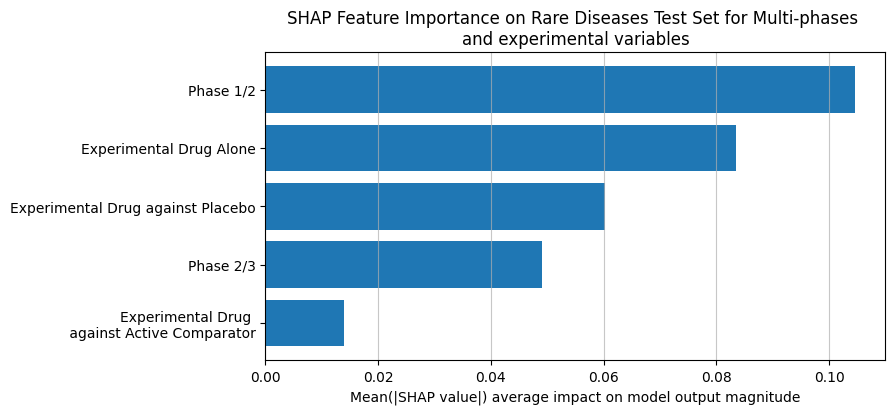

In [254]:
plot_feature_importance(feature_importance_r.loc[xxx],12,0.11,var='Multi-phases \nand experimental',model='Rare Diseases')

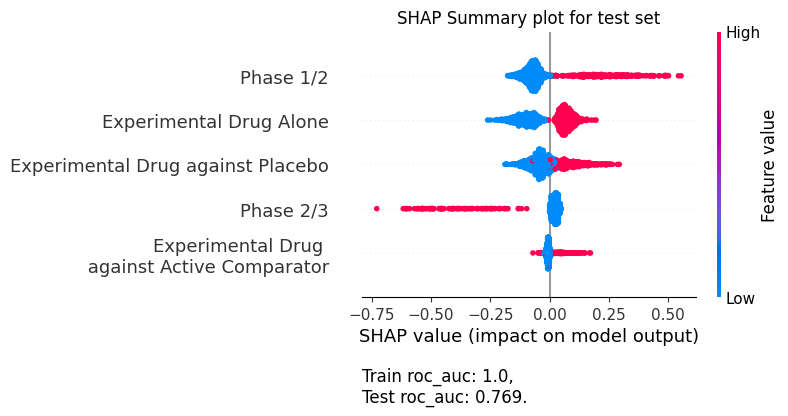

In [255]:
ax1 = shap_interpreter_r.plot('summary', target_columns=xxx,max_display=50)

In [256]:
%%jmd 
#### Common Diseases

#### Common Diseases

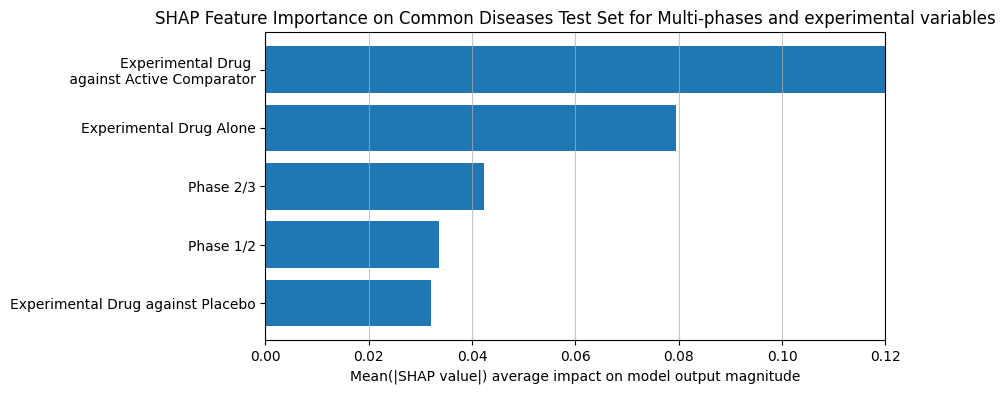

In [257]:
plot_feature_importance(feature_importance.loc[xxx],12,0.12,var='Multi-phases and experimental',model='Common Diseases')

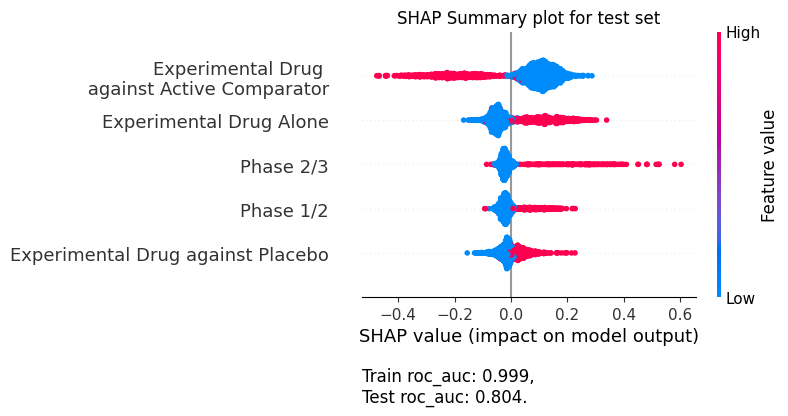

In [258]:
ax1 = shap_interpreter.plot('summary', target_columns=xxx,max_display=50)

In [259]:
%%jmd
### Intervention models and eligibility variables

### Intervention models and eligibility variables

In [260]:
%%jmd 
#### Rare Diseases

#### Rare Diseases

In [261]:
elig_dict = {'interventionModel_CROSSOVER' : 'Cross-over Model',
 'interventionModel_PARALLEL':'Parallel Model',
 'interventionModel_SEQUENTIAL':'Sequential Model',
 'interventionModel_SINGLE_GROUP':'Single Group Model',
 'FEMALE_ONLY':'Female Only',
 'healthyVolunteers':'Healthy Volunteers eligible',
 'include_elderly':'Elderly eligible',
 'include_children':'Children eligible',
 'ci_pregnancy':'Pregnancy exclusion criteria',
 'arm_group_count':'count of arm groups','is_randomized':'Randomization'}
 
 


dictionnari = elig_dict
## rename the indexes in feature_importance_r with the dict 
feature_importance_r.rename(index=dictionnari,inplace=True)
## replace the columns names with the dict in shap_interpreter_r.X_test 
shap_interpreter_r.X_test.columns = shap_interpreter_r.X_test.columns.to_series().replace(dictionnari).values
shap_interpreter_r.column_names = [dictionnari.get(col, col) for col in shap_interpreter_r.column_names]

## rename the indexes in feature_importance_r with the dict 
feature_importance.rename(index=dictionnari,inplace=True)
## replace the columns names with the dict in shap_interpreter_r.X_test 
shap_interpreter.X_test.columns = shap_interpreter.X_test.columns.to_series().replace(dictionnari).values
shap_interpreter.column_names = [dictionnari.get(col, col) for col in shap_interpreter.column_names]

elig_col = list(elig_dict.values())
elig_col
ct_rawr = ct_rawr.rename(columns=dictionnari)
ct_rawn = ct_rawn.rename(columns=dictionnari)

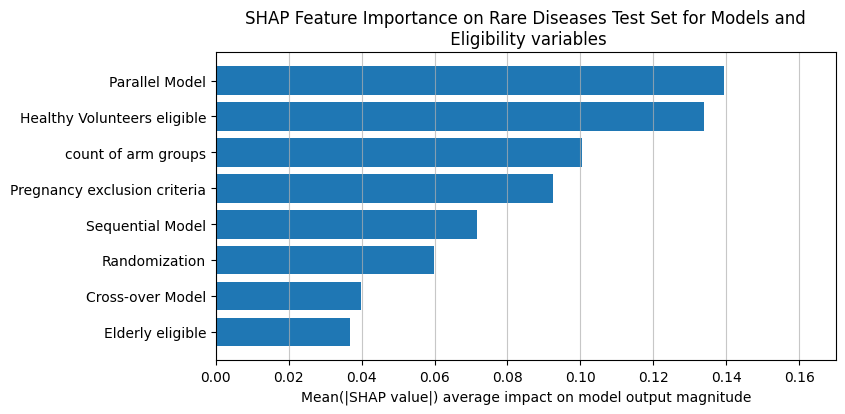

In [262]:
plot_feature_importance(feature_importance_r.loc[elig_col],8,0.17,var='Models and\n Eligibility',model='Rare Diseases')

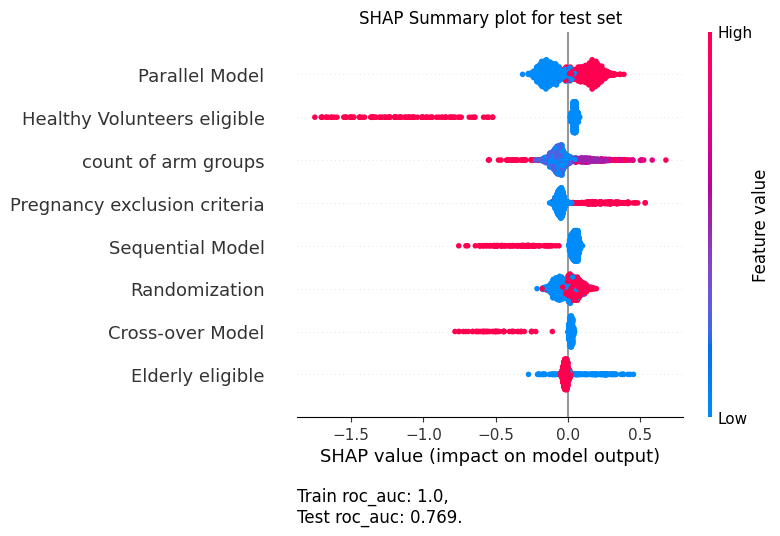

In [263]:
ax1 = shap_interpreter_r.plot('summary', target_columns=elig_col,max_display=8)

In [264]:
%%jmd 
#### Common Diseases

#### Common Diseases

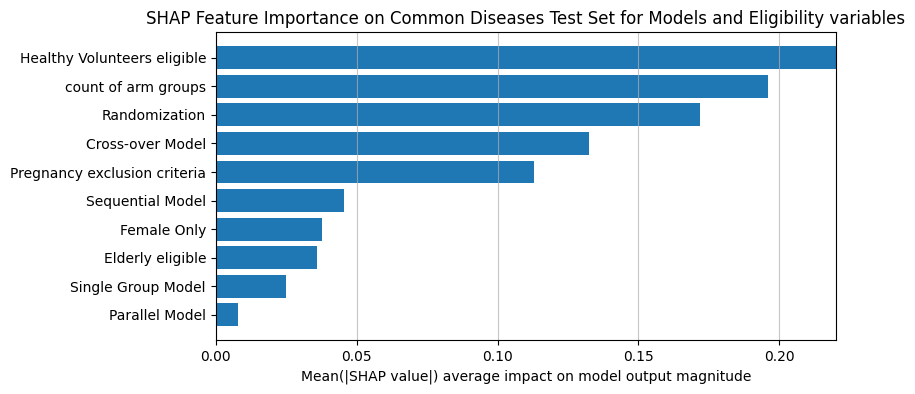

In [265]:
plot_feature_importance(feature_importance.loc[elig_col],10,0.22,var='Models and Eligibility',model='Common Diseases')

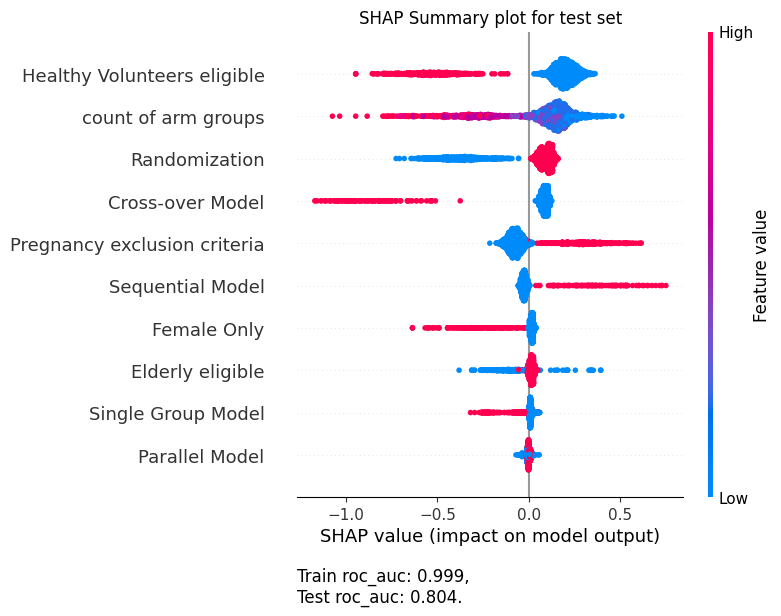

In [266]:
ax1 = shap_interpreter.plot('summary', target_columns=elig_col,max_display=10)

In [267]:
%%jmd
### Entity Classes

### Entity Classes

In [268]:
%%jmd
### Locations Variables

### Locations Variables

In [269]:
%%jmd
#### Rare Diseases

#### Rare Diseases

In [270]:
continent_dict = {'continent_Australia and New Zealand': 'Australia and New Zealand',
 'continent_Central America': 'Central America',
 'continent_Central Asia': 'Central Asia',
 'continent_Eastern Africa': 'Eastern Africa',
 'continent_Eastern Asia': 'Eastern Asia',
 'continent_Eastern Europe': 'Eastern Europe',
 'continent_Northern Africa': 'Northern Africa',
 'continent_Northern America': 'Northern America',
 'continent_Northern Europe': 'Northern Europe',
 'continent_South America': 'South America',
 'continent_South-Eastern Asia': 'South-Eastern Asia',
 'continent_Southern Africa': 'Southern Africa',
 'continent_Southern Asia': 'Southern Asia',
 'continent_Southern Europe': 'Southern Europe',
 'continent_Western Africa': 'Western Africa',
 'continent_Western Asia':  'Western Asia',
 'country_China': 'China',
 'country_United States': 'United States',
 'total_centers'  : 'Count of Centers',
 'multi_city' : 'Centers in dinstinct Cities',
 'multi_country': 'Centers in distinct Countries',
 'multi_subregion':'Centers in distinct Subregions'}


 
 


dictionnari = continent_dict
## rename the indexes in feature_importance_r with the dict 
feature_importance_r.rename(index=dictionnari,inplace=True)
## replace the columns names with the dict in shap_interpreter_r.X_test 
shap_interpreter_r.X_test.columns = shap_interpreter_r.X_test.columns.to_series().replace(dictionnari).values
shap_interpreter_r.column_names = [dictionnari.get(col, col) for col in shap_interpreter_r.column_names]

## rename the indexes in feature_importance_r with the dict 
feature_importance.rename(index=dictionnari,inplace=True)
## replace the columns names with the dict in shap_interpreter_r.X_test 
shap_interpreter.X_test.columns = shap_interpreter.X_test.columns.to_series().replace(dictionnari).values
shap_interpreter.column_names = [dictionnari.get(col, col) for col in shap_interpreter.column_names]

continent_col = list(dictionnari.values())
continent_col
ct_rawr = ct_rawr.rename(columns=dictionnari)
ct_rawn = ct_rawn.rename(columns=dictionnari)

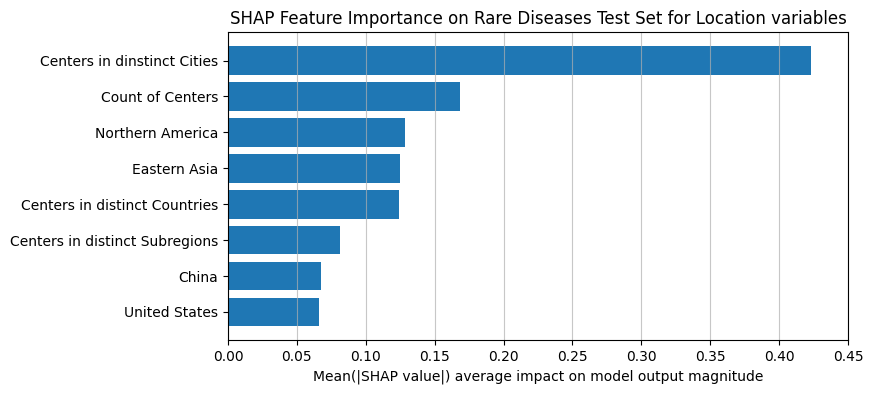

In [271]:
plot_feature_importance(feature_importance_r.loc[continent_col],8,0.45,var='Location',model='Rare Diseases')

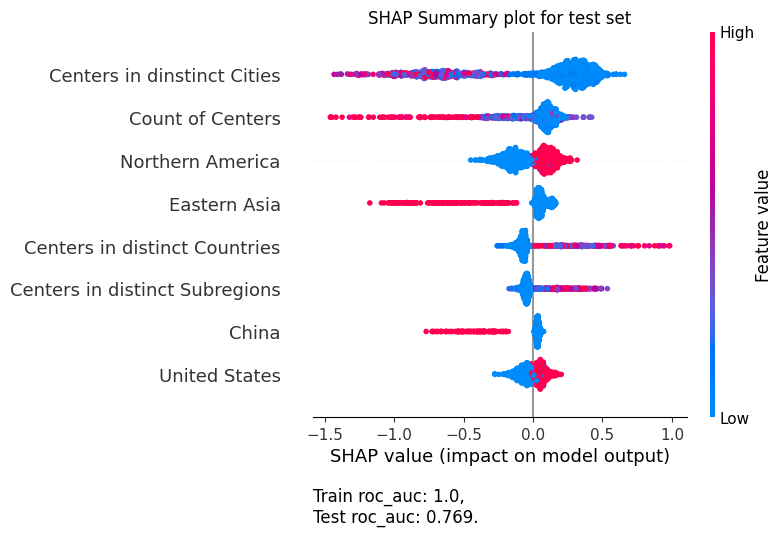

In [272]:
ax1 = shap_interpreter_r.plot('summary', target_columns=continent_col,max_display=8)

In [273]:
%%jmd
#### Common Diseases

#### Common Diseases

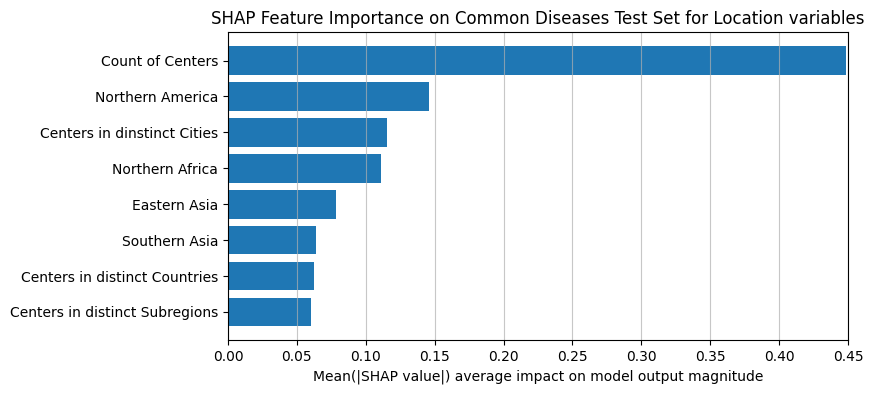

In [274]:
plot_feature_importance(feature_importance.loc[continent_col],8,0.45,var='Location',model='Common Diseases')

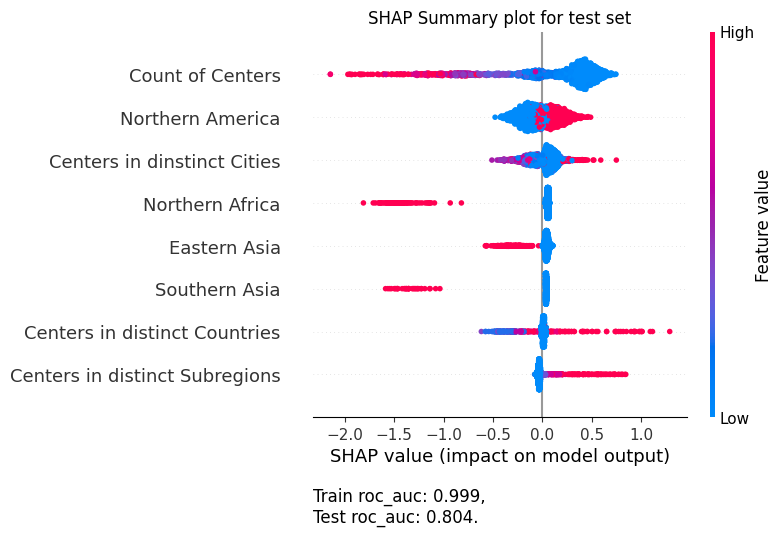

In [275]:
ax1 = shap_interpreter.plot('summary', target_columns=continent_col,max_display=8)

In [276]:
%%jmd
### Entity and entity classes variables

### Entity and entity classes variables

In [277]:
%%jmd 
#### Rare Diseases

#### Rare Diseases

In [278]:
entity_dict = {'org_study_class_HOSPITAL':'Medical org study class',
 'org_study_class_INDUSTRY':'Industry org study class',
 'org_study_class_NETWORK':'Network org study class',
 'org_study_class_NIH':'NIH org study class',
 'org_study_class_UNIVERSITY':'Academic org study class',
 'sponsor_class_HOSPITAL' : 'Medical Lead Sponsor class',
 'sponsor_class_INDUSTRY':'Industry Lead Sponsor class',
 'sponsor_class_NETWORK':'Network Lead Sponsor class',
 'sponsor_class_NIH':'NIH Lead Sponsor class',
 'sponsor_class_UNIVERSITY':'Academic Lead Sponsor class',
 'number_of_collaborators':'Number of Collaborators',
 'industry_ratio':'Percentage of Industrial Collaborators',}


 
 


dictionnari = entity_dict
## rename the indexes in feature_importance_r with the dict 
feature_importance_r.rename(index=dictionnari,inplace=True)
## replace the columns names with the dict in shap_interpreter_r.X_test 
shap_interpreter_r.X_test.columns = shap_interpreter_r.X_test.columns.to_series().replace(dictionnari).values
shap_interpreter_r.column_names = [dictionnari.get(col, col) for col in shap_interpreter_r.column_names]

## rename the indexes in feature_importance_r with the dict 
feature_importance.rename(index=dictionnari,inplace=True)
## replace the columns names with the dict in shap_interpreter_r.X_test 
shap_interpreter.X_test.columns = shap_interpreter.X_test.columns.to_series().replace(dictionnari).values
shap_interpreter.column_names = [dictionnari.get(col, col) for col in shap_interpreter.column_names]

entity_col = list(dictionnari.values())
entity_col
ct_rawr = ct_rawr.rename(columns=dictionnari)
ct_rawn = ct_rawn.rename(columns=dictionnari)

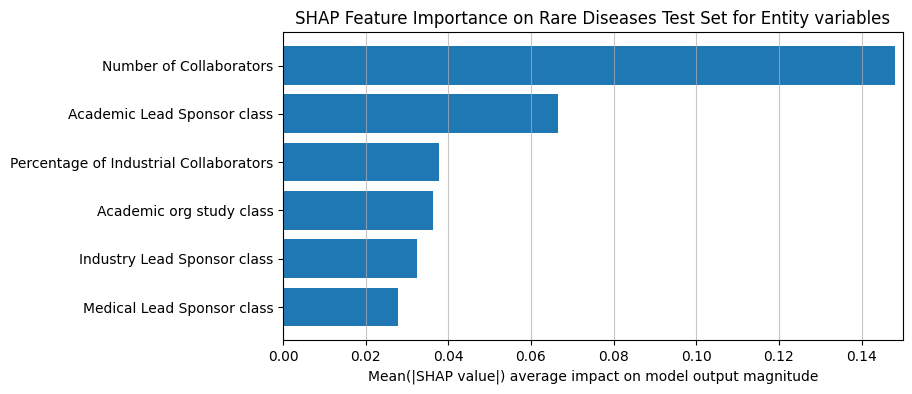

In [279]:
plot_feature_importance(feature_importance_r.loc[entity_col],6,0.15,var='Entity',model='Rare Diseases')

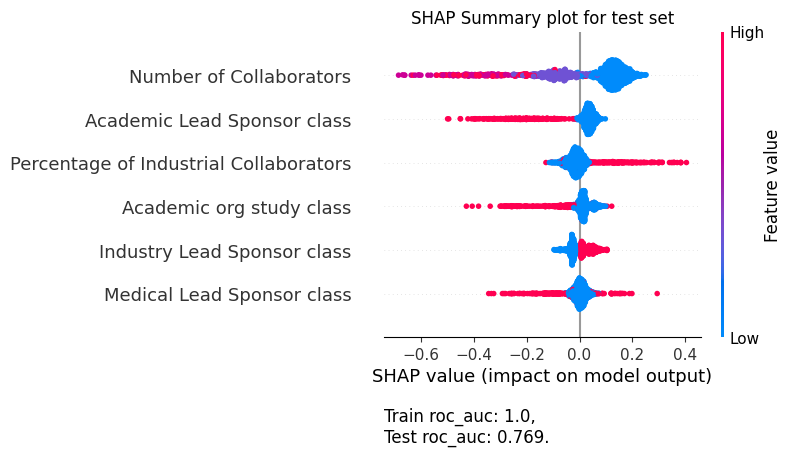

In [280]:
ax1 = shap_interpreter_r.plot('summary', target_columns=entity_col,max_display=6)

In [281]:
%%jmd 
#### Common Diseases

#### Common Diseases

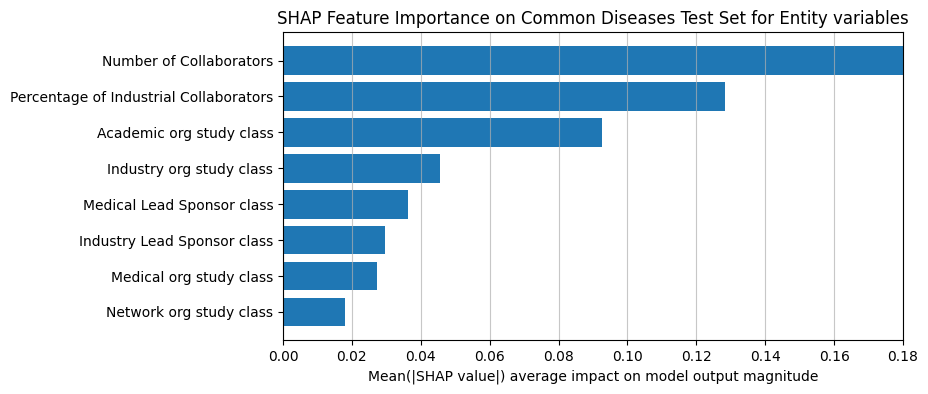

In [282]:
plot_feature_importance(feature_importance.loc[entity_col],8,0.18,var='Entity',model='Common Diseases')

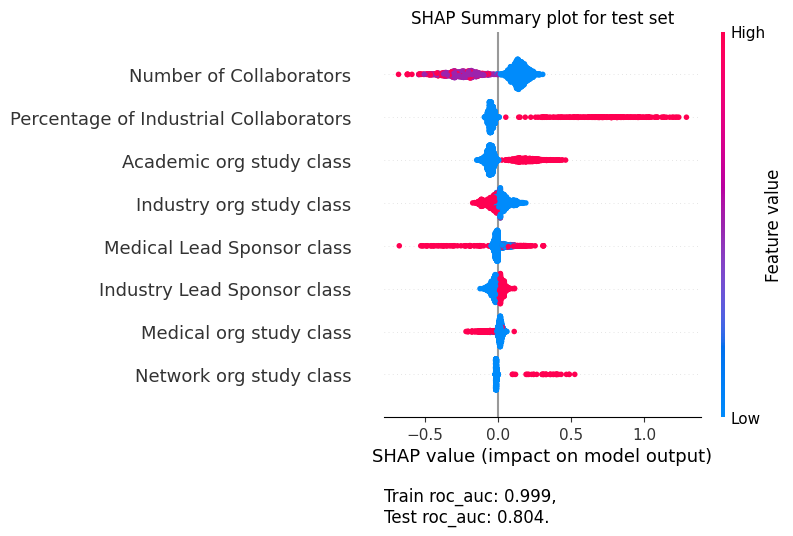

In [283]:
ax1 = shap_interpreter.plot('summary', target_columns=entity_col,max_display=8)

In [284]:
%%jmd
### browsebranch Mesh terms


### browsebranch Mesh terms

In [285]:
%%jmd 
#### Rare Diseases

#### Rare Diseases

In [286]:
bb_dict = {'bb_mesh:Blood and Lymph ': 'Blood and Lymph Conditions',
 'bb_mesh:Digestive System ':'Digestive System Diseases',
 'bb_mesh:Disease at or Before Birth':'Diseases and Abnormalities at or Before Birth',
 'bb_mesh:Gland and Hormone Related ':'Gland and Hormone Related Diseases',
 'bb_mesh:Heart and Blood ': 'Heart and Blood Diseases',
 'bb_mesh:Immune System ':'Immune System Diseases',
 'bb_mesh:Infections':'Infections',
 'bb_mesh:Musculoskeletal ':'Musculoskeletal Diseases',
 'bb_mesh:Neoplasms':'Neoplasms',
 'bb_mesh:Nervous System ':'Nervous System Diseases',
 'bb_mesh:Nutritional and Metabolic ':'Nutritional and Metabolic Diseases',
 'bb_mesh:Respiratory Tract':'Respiratory Tract (Lung and Bronchial) Diseases',
 'bb_mesh:Skin and Connective Tissue ':'Skin and Connective Tissue Diseases',
 'bb_mesh:Urinary Tract, Sexual Organs, and Pregnancy ':'Urinary Tract, Sexual Organs, and Pregnancy Conditions'}


 
 


dictionnari = bb_dict
## rename the indexes in feature_importance_r with the dict 
feature_importance_r.rename(index=dictionnari,inplace=True)
## replace the columns names with the dict in shap_interpreter_r.X_test 
shap_interpreter_r.X_test.columns = shap_interpreter_r.X_test.columns.to_series().replace(dictionnari).values
shap_interpreter_r.column_names = [dictionnari.get(col, col) for col in shap_interpreter_r.column_names]

## rename the indexes in feature_importance_r with the dict 
feature_importance.rename(index=dictionnari,inplace=True)
## replace the columns names with the dict in shap_interpreter_r.X_test 
shap_interpreter.X_test.columns = shap_interpreter.X_test.columns.to_series().replace(dictionnari).values
shap_interpreter.column_names = [dictionnari.get(col, col) for col in shap_interpreter.column_names]

bb_mesh = list(dictionnari.values())
bb_mesh
ct_rawr = ct_rawr.rename(columns=dictionnari)
ct_rawn = ct_rawn.rename(columns=dictionnari)

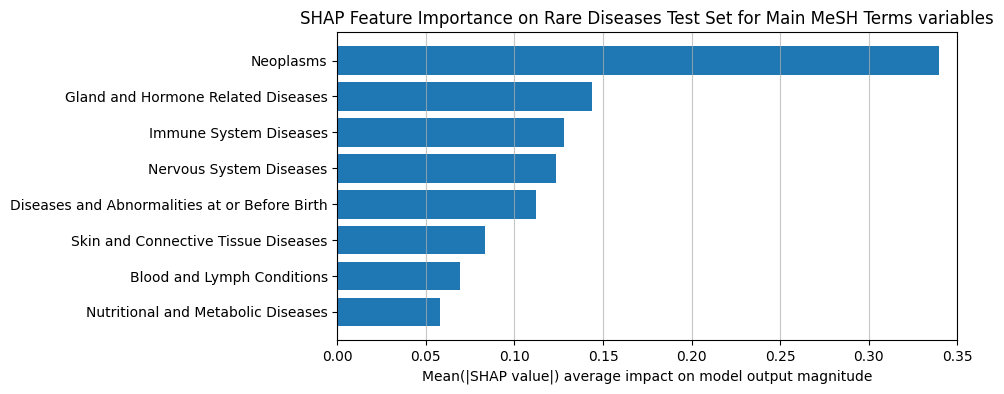

In [287]:
plot_feature_importance(feature_importance_r.loc[bb_mesh],8,0.35,var='Main MeSH Terms',model='Rare Diseases')

In [330]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate the value counts for each condition
www=ct_rawr.copy()
www['overallStatus'] = www['overallStatus'].replace({1: 'TERMINATED', 0: 'COMPLETED'})

neoplasms_counts = www[www['Neoplasms'] == 1]['overallStatus'].value_counts()
gland_counts = www[www['Gland and Hormone Related Diseases'] == 1]['overallStatus'].value_counts()
immune_counts = www[www['Immune System Diseases'] == 1]['overallStatus'].value_counts()
nerv_counts = www[www['Nervous System Diseases'] == 1]['overallStatus'].value_counts()
birth_counts = www[www['Diseases and Abnormalities at or Before Birth'] == 1]['overallStatus'].value_counts()
skin_counts = www[www['Skin and Connective Tissue Diseases'] == 1]['overallStatus'].value_counts()
blood_count = www[www['Blood and Lymph Conditions'] == 1]['overallStatus'].value_counts()
nutri_count = www[www['Nutritional and Metabolic Diseases'] == 1]['overallStatus'].value_counts()


# Create a DataFrame to align the counts
counts_df = pd.DataFrame({
    'Neoplasms': neoplasms_counts,
    'Gland and Hormone \nRelated Diseases': gland_counts,
    'Immune System\n Diseases': immune_counts,
    'Skin and Connective \nTissue Diseases': skin_counts,
    'Blood and Lymph \nConditions': blood_count,
    'Nutritional and Metabolic \nDiseases': nutri_count,
    'Diseases and Abnormalities \nat or Before Birth': birth_counts,
}).fillna(0)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 5))

# Define the bar width and positions
bar_width = 0.25
index = np.arange(len(counts_df.columns))  # Three conditions

# Plot the grouped bars for each overallStatus category
for i, status in enumerate(counts_df.index):
    bars = ax.bar(index + i * bar_width, counts_df.loc[status], bar_width, label=status)
    # Annotate the actual count on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height-50, f'{int(height)}', ha='center', va='bottom')

# Set the labels and title
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.set_title('Rare Diseases Phase 2 Trials Status by Condition')
ax.set_xticks(index + bar_width * (len(counts_df.index) - 1) / 2)
ax.set_xticklabels(counts_df.columns)

# Add a legend
ax.legend(title='Overall Status')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


KeyError: 'Neoplasms'

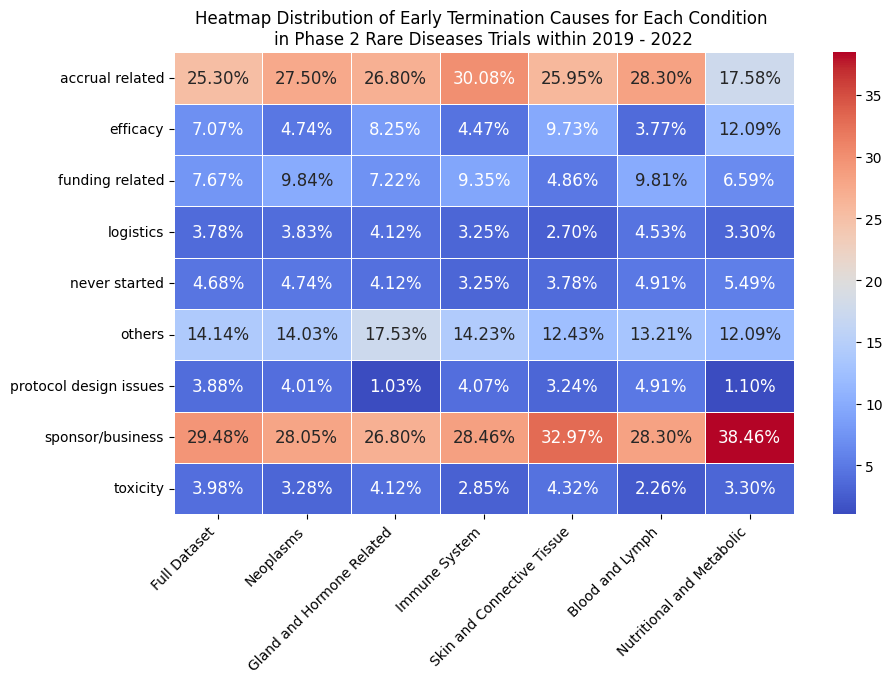

In [289]:


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
dfx = pd.read_csv('clean_data/why_stop.csv')
dfx['category'] = dfx['category'].replace('enrollment_accrual_related','accrual related')
dfx['category'] = dfx['category'].replace('inadequate_study_design_or_study_redesign','protocol design issues')
dfx['category'] = dfx['category'].replace('negligence_or_recommandation_of_legalities','others')
dfx['category'] = dfx['category'].replace('pi_related','others')
dfx['category'] = dfx['category'].replace('trial_no_longer_needed','others')
dfx['category'] = dfx['category'].replace('added_by_error','others')
dfx['category'] = dfx['category'].replace('organizational_issues','others')
dfx['category'] = dfx['category'].replace('study_competition','others')
dfx['category'] = dfx['category'].replace('completed_early_or_truncated_completion','others')
dfx['category'] = dfx['category'].replace('business_or_sponsor_reason','sponsor/business')
dfx['category'] = dfx['category'].replace('never_started','never started')
dfx['category'] = dfx['category'].replace('funding_related','funding related')
dfx['category'] = dfx['category'].replace('safety_ethics_aes','toxicity')




avg = www.index.to_list()
neo = www[www['Neoplasms'] == 1].index.to_list()
gland = www[www['Gland and Hormone Related Diseases'] == 1].index.to_list()
immune = www[www['Immune System Diseases'] == 1].index.to_list()
nerve = www[www['Nervous System Diseases'] == 1].index.to_list()
birth = www[www['Diseases and Abnormalities at or Before Birth'] == 1].index.to_list()
skin = www[www['Skin and Connective Tissue Diseases'] == 1].index.to_list()
blood = www[www['Blood and Lymph Conditions'] == 1].index.to_list()
nutri = www[www['Nutritional and Metabolic Diseases'] == 1].index.to_list()


# Assuming neo, gland, and immune are lists of nct_ids
avg_df = dfx[dfx['nct_id'].isin(avg)]
neo_df = dfx[dfx['nct_id'].isin(neo)]
gland_df = dfx[dfx['nct_id'].isin(gland)]
immune_df = dfx[dfx['nct_id'].isin(immune)]
nerve_df = dfx[dfx['nct_id'].isin(nerve)]
birth_df = dfx[dfx['nct_id'].isin(birth)]
skin_df = dfx[dfx['nct_id'].isin(skin)]
blood_df = dfx[dfx['nct_id'].isin(blood)]
nutri_df = dfx[dfx['nct_id'].isin(nutri)]
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the percentage of each category in each DataFrame
def calculate_percentage(df, category_col='category'):
    return df[category_col].value_counts(normalize=True) * 100


percentages = {
    'Full Dataset': calculate_percentage(avg_df),
    'Neoplasms': calculate_percentage(neo_df),
    'Gland and Hormone Related': calculate_percentage(gland_df),
    'Immune System': calculate_percentage(immune_df),
    'Skin and Connective Tissue': calculate_percentage(skin_df),
    'Blood and Lymph': calculate_percentage(blood_df),
    'Nutritional and Metabolic': calculate_percentage(nutri_df)
}

# Convert the dictionary to a DataFrame
percentages_df = pd.DataFrame(percentages).fillna(0)

# Format the percentages to two decimal places and add the percentage symbol
formatted_percentages_df = percentages_df.applymap(lambda x: f'{x:.2f}%')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(percentages_df.apply(lambda x: x / x.sum() * 100), annot=formatted_percentages_df, fmt='', cmap='coolwarm', linewidths=0.5, annot_kws={"fontsize": 12})
plt.title('Heatmap Distribution of Early Termination Causes for Each Condition \nin Phase 2 Rare Diseases Trials within 2019 - 2022')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()



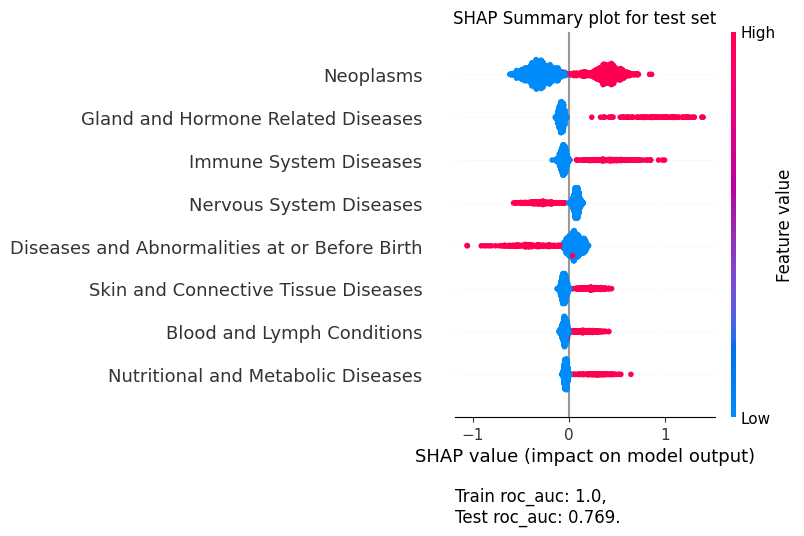

In [290]:
ax1 = shap_interpreter_r.plot('summary', target_columns=bb_mesh,max_display=8)

In [291]:
%%jmd 
#### Common Diseases

#### Common Diseases

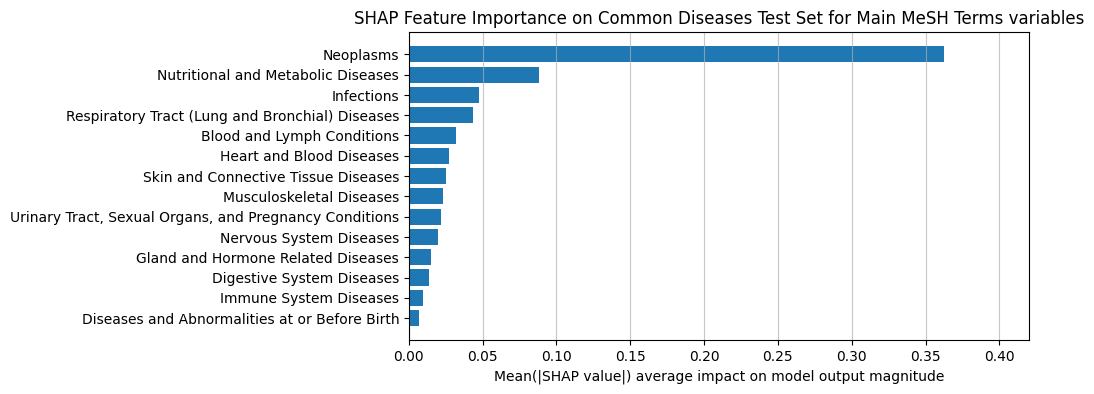

In [292]:
plot_feature_importance(feature_importance.loc[bb_mesh],20,0.42,var='Main MeSH Terms',model='Common Diseases')

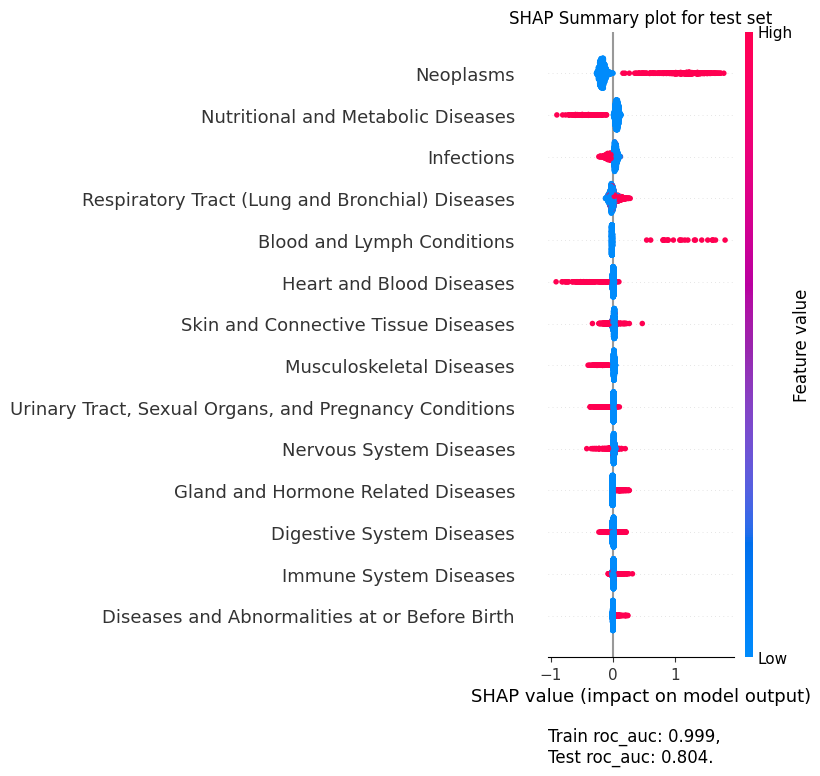

In [293]:
ax1 = shap_interpreter.plot('summary', target_columns=bb_mesh,max_display=20)

In [294]:
%%jmd
#### Organizations names


#### Organizations names

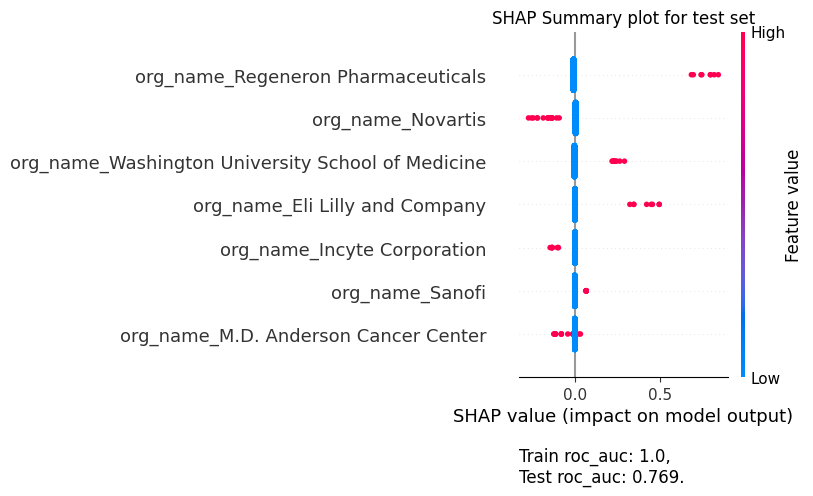

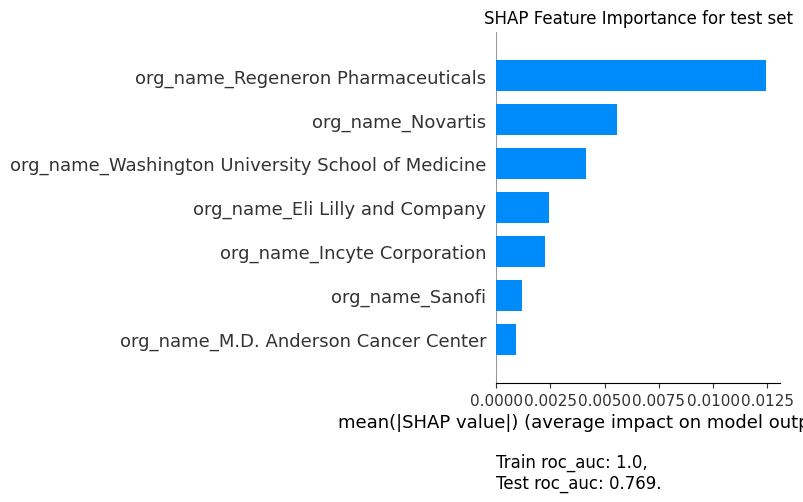

In [295]:
ax1 = shap_interpreter_r.plot('summary', target_columns=org_col,max_display=7)
ax2 = shap_interpreter_r.plot('importance', target_columns=org_col,max_display=7)

In [296]:
%%jmd
#### Lead Sponsor names


#### Lead Sponsor names

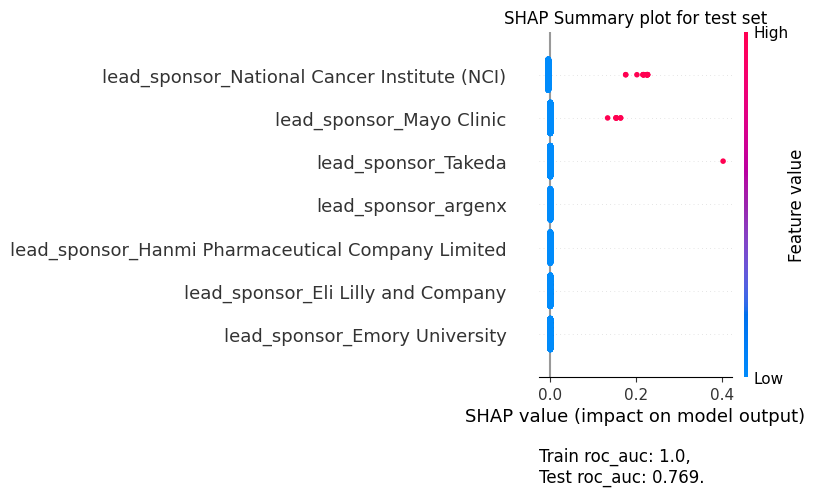

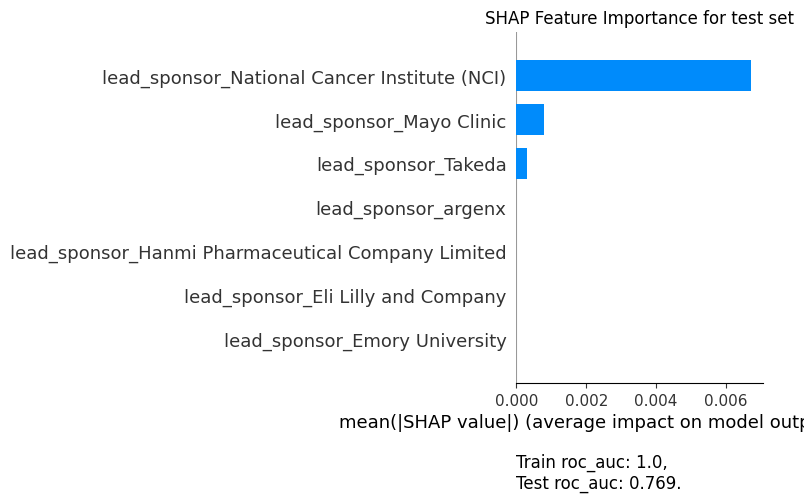

In [297]:
ax1 = shap_interpreter_r.plot('summary', target_columns=lead_col,max_display=7)
ax2 = shap_interpreter_r.plot('importance',target_columns=lead_col,max_display=7)

In [298]:

xgb_noise['name'] = 'XGB RD'
logreg_noise['name'] = 'LR RD'
xgb_noise1['name'] = 'XGB CD'
logreg_noise1['name'] = 'LR1 CD'



In [299]:
%%jmd 
# Overall Summary - All Rare Diseases
[//]: <> (-.- tabset tabset-pills)

# Overall Summary - All Rare Diseases
<span class='pj-token' style='display: none;'>tabset|O_O|tabset-pills</span>

In [300]:
# Function to format metrics
def format_metric_with_std(row, metric):
    return f"{row[metric]:.3f} ± {row[metric + ' Std']:.2f}"


In [301]:
%%jmd 
## Model Evaluation based on 10 fold Cross-Validation

## Model Evaluation based on 10 fold Cross-Validation

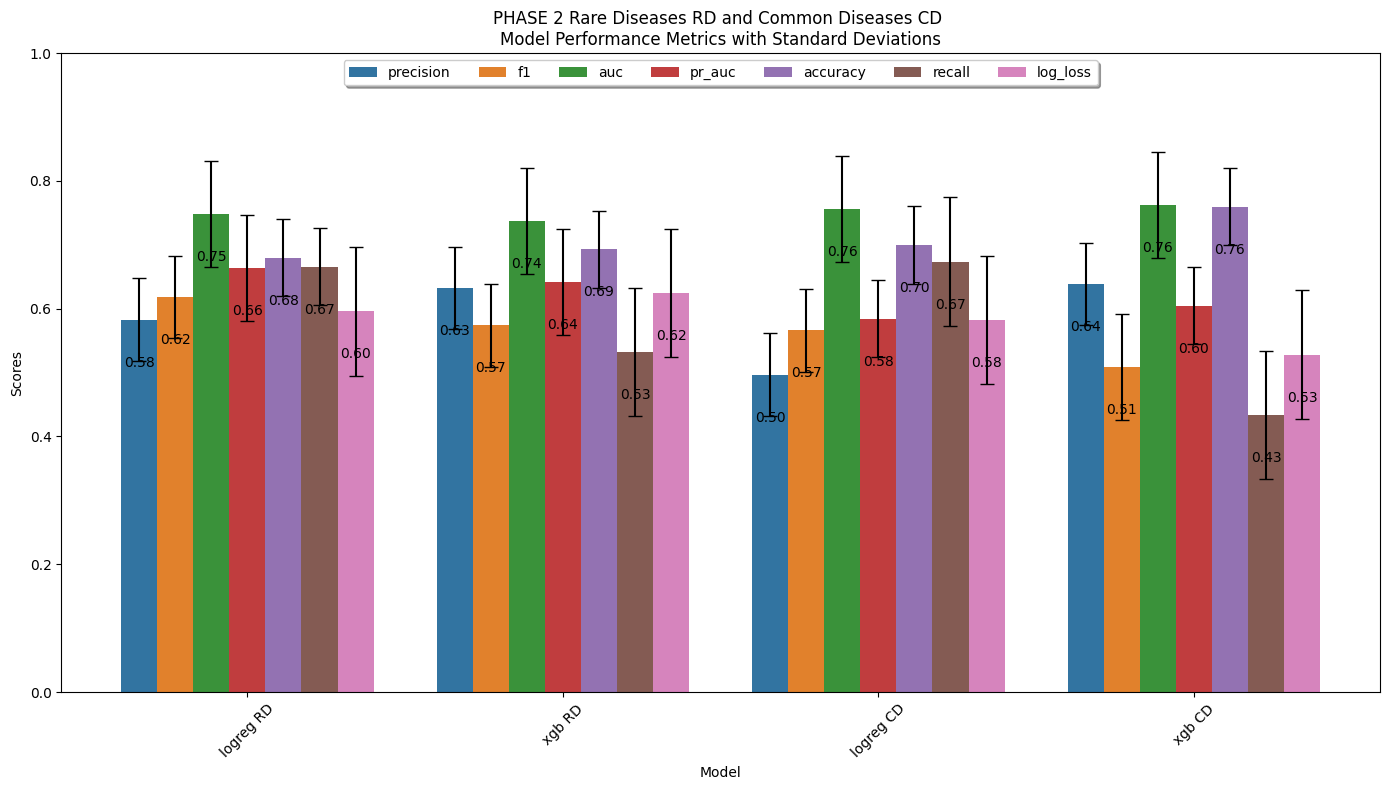

Model     precision            f1           auc        pr_auc  \
0  logreg RD  0.583 ± 0.06  0.618 ± 0.04  0.749 ± 0.06  0.664 ± 0.07   
1     xgb RD  0.633 ± 0.08  0.574 ± 0.04  0.737 ± 0.05  0.642 ± 0.07   
2  logreg CD  0.497 ± 0.06  0.566 ± 0.03  0.755 ± 0.04  0.584 ± 0.06   
3     xgb CD  0.639 ± 0.10  0.508 ± 0.07  0.762 ± 0.05  0.605 ± 0.06   

       accuracy        recall      log_loss  
0  0.680 ± 0.05  0.666 ± 0.06  0.596 ± 0.06  
1  0.693 ± 0.04  0.532 ± 0.05  0.625 ± 0.07  
2  0.700 ± 0.05  0.674 ± 0.07  0.582 ± 0.06  
3  0.760 ± 0.03  0.434 ± 0.08  0.528 ± 0.05

In [302]:
# Step 1: Create the DataFrame with Accuracy, Log-Loss, ROC-AUC, F1, PR-AUC, Recall, Precision, and their standard deviations

dictionaries = [logreg_noise['CV_scoring'], xgb_noise['CV_scoring'],logreg_noise1['CV_scoring'], xgb_noise1['CV_scoring']]
dictionary_name = ['logreg RD',  'xgb RD','logreg CD',  'xgb CD']
metrics = ['precision','f1','auc','pr_auc','accuracy', 'recall', 'log_loss']
cv_data = {
    'Model': dictionary_name  # ['logreg', 'xgb']
}
# Dynamically populate the DataFrame columns for each metric and its standard deviation
for metric in metrics:
    cv_data[metric] = [d[d['Metric'] == metric]['Mean Score'].values[0] for d in dictionaries]
    cv_data[f'{metric} Std'] = [d[d['Metric'] == metric]['Standard Deviation'].values[0] for d in dictionaries]

# Create the DataFrame from the constructed dictionary
df_models_cv = pd.DataFrame(cv_data)


# Step 2: Plot function to include all metrics with error bars
def plot_selected_scores_seaborn():
    # Define the metrics to plot
    metrics = ['precision','f1','auc','pr_auc','accuracy', 'recall', 'log_loss']
    
    # Create standard deviation metric names
    std_metrics = [f'{metric} Std' for metric in metrics]
    
    # Melt the DataFrame to make it suitable for Seaborn's barplot
    df_melted = df_models_cv.melt(id_vars="Model", value_vars=metrics, var_name="Score", value_name="Value")
    df_melted_std = df_models_cv.melt(id_vars="Model", value_vars=std_metrics, var_name="Score Std", value_name="Std")
    
    # Merge the melted DataFrames to have both Value and Std in the same DataFrame
    df_melted['Std'] = df_melted_std['Std']
    
    # Set the figure size
    plt.figure(figsize=(14, 8))
    
    # Create a bar plot with error bars
    barplot = sns.barplot(x='Model', y='Value', hue='Score', data=df_melted, ci=None)
    
    # Add error bars for each bar
    for i, bar in enumerate(barplot.patches):
        if bar.get_height() > 0:
            # Determine the corresponding model and metric (score)
            model = df_melted.iloc[i // len(metrics)]['Model']
            score = df_melted.iloc[i // len(metrics)]['Score']
            # Retrieve the corresponding standard deviation
            std = df_melted[(df_melted['Model'] == model) & (df_melted['Score'] == score)]['Std'].values[0]
            # Add the error bar
            barplot.errorbar(bar.get_x() + bar.get_width() / 2, bar.get_height(), yerr=std, fmt='none', c='black', capsize=5)

    # Annotate numerical values on top of each bar
    for p in barplot.patches:
        if p.get_height() > 0:
            barplot.annotate(format(p.get_height(), '.2f'), 
                            (p.get_x() + p.get_width() / 2., p.get_height() -.1), 
                            ha='center', va='bottom', 
                            xytext=(0, 10), 
                            textcoords='offset points')
    
    # Final touches for the plot
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.xlabel('Model')  # X-axis label
    plt.ylabel('Scores')  # Y-axis label
    plt.ylim(0, 1)  # Y-axis limit (assuming scores are normalized between 0 and 1)
    plt.title('PHASE 2 Rare Diseases RD and Common Diseases CD \nModel Performance Metrics with Standard Deviations')  # Title
    plt.tight_layout()  # Adjust layout to fit elements properly
    plt.legend(loc='upper center', shadow=True, ncol=7)
    plt.show()  # Display the plot

# Call the function to generate and display the plot
plot_selected_scores_seaborn()
# Create a new DataFrame with formatted metrics
formatted_data = {
    'Model': df_models_cv['Model']
}
for metric in metrics:
    formatted_data[metric] = df_models_cv.apply(lambda row: format_metric_with_std(row, metric), axis=1)
df_formatted = pd.DataFrame(formatted_data)
df_formatted

In [303]:

xgb_noise['name'] = 'XGB RD'
logreg_noise['name'] = 'LR RD'
xgb_noise1['name'] = 'XGB CD'
logreg_noise1['name'] = 'LR1 CD'



In [304]:
%%jmd 
# Overall Summary - All Rare Diseases
[//]: <> (-.- tabset tabset-pills)

# Overall Summary - All Rare Diseases
<span class='pj-token' style='display: none;'>tabset|O_O|tabset-pills</span>

In [305]:
# Function to format metrics
def format_metric_with_std(row, metric):
    return f"{row[metric]:.3f} ± {row[metric + ' Std']:.2f}"


In [306]:
%%jmd 
## Model Evaluation based on 10 fold Cross-Validation

## Model Evaluation based on 10 fold Cross-Validation

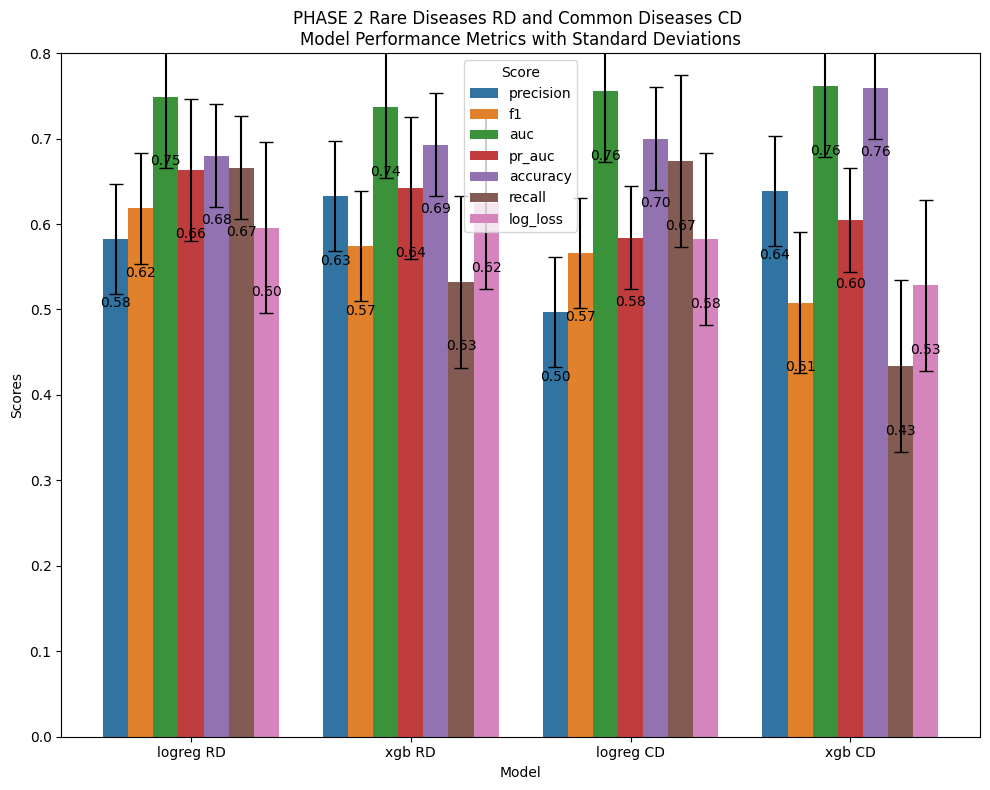

Model     precision            f1           auc        pr_auc  \
0  logreg RD  0.583 ± 0.06  0.618 ± 0.04  0.749 ± 0.06  0.664 ± 0.07   
1     xgb RD  0.633 ± 0.08  0.574 ± 0.04  0.737 ± 0.05  0.642 ± 0.07   
2  logreg CD  0.497 ± 0.06  0.566 ± 0.03  0.755 ± 0.04  0.584 ± 0.06   
3     xgb CD  0.639 ± 0.10  0.508 ± 0.07  0.762 ± 0.05  0.605 ± 0.06   

       accuracy        recall      log_loss  
0  0.680 ± 0.05  0.666 ± 0.06  0.596 ± 0.06  
1  0.693 ± 0.04  0.532 ± 0.05  0.625 ± 0.07  
2  0.700 ± 0.05  0.674 ± 0.07  0.582 ± 0.06  
3  0.760 ± 0.03  0.434 ± 0.08  0.528 ± 0.05

In [307]:
# Step 1: Create the DataFrame with Accuracy, Log-Loss, ROC-AUC, F1, PR-AUC, Recall, Precision, and their standard deviations

dictionaries = [logreg_noise['CV_scoring'], xgb_noise['CV_scoring'],logreg_noise1['CV_scoring'], xgb_noise1['CV_scoring']]
dictionary_name = ['logreg RD',  'xgb RD','logreg CD',  'xgb CD']
metrics = ['precision','f1','auc','pr_auc','accuracy', 'recall', 'log_loss']
cv_data = {
    'Model': dictionary_name  # ['logreg', 'xgb']
}
# Dynamically populate the DataFrame columns for each metric and its standard deviation
for metric in metrics:
    cv_data[metric] = [d[d['Metric'] == metric]['Mean Score'].values[0] for d in dictionaries]
    cv_data[f'{metric} Std'] = [d[d['Metric'] == metric]['Standard Deviation'].values[0] for d in dictionaries]

# Create the DataFrame from the constructed dictionary
df_models_cv = pd.DataFrame(cv_data)


# Step 2: Plot function to include all metrics with error bars
def plot_selected_scores_seaborn():
    # Define the metrics to plot
    metrics = ['precision','f1','auc','pr_auc','accuracy', 'recall', 'log_loss']
    
    # Create standard deviation metric names
    std_metrics = [f'{metric} Std' for metric in metrics]
    
    # Melt the DataFrame to make it suitable for Seaborn's barplot
    df_melted = df_models_cv.melt(id_vars="Model", value_vars=metrics, var_name="Score", value_name="Value")
    df_melted_std = df_models_cv.melt(id_vars="Model", value_vars=std_metrics, var_name="Score Std", value_name="Std")
    
    # Merge the melted DataFrames to have both Value and Std in the same DataFrame
    df_melted['Std'] = df_melted_std['Std']
    
    # Set the figure size
    plt.figure(figsize=(10, 8))
    
    # Create a bar plot with error bars
    barplot = sns.barplot(x='Model', y='Value', hue='Score', data=df_melted, ci=None)
    
    # Add error bars for each bar
    for i, bar in enumerate(barplot.patches):
        if bar.get_height() > 0:
            # Determine the corresponding model and metric (score)
            model = df_melted.iloc[i // len(metrics)]['Model']
            score = df_melted.iloc[i // len(metrics)]['Score']
            # Retrieve the corresponding standard deviation
            std = df_melted[(df_melted['Model'] == model) & (df_melted['Score'] == score)]['Std'].values[0]
            # Add the error bar
            barplot.errorbar(bar.get_x() + bar.get_width() / 2, bar.get_height(), yerr=std, fmt='none', c='black', capsize=5)

    # Annotate numerical values on top of each bar
    for p in barplot.patches:
        if p.get_height() > 0:
            barplot.annotate(format(p.get_height(), '.2f'), 
                            (p.get_x() + p.get_width() / 2., p.get_height() -.1), 
                            ha='center', va='bottom', 
                            xytext=(0, 10), 
                            textcoords='offset points')
    
    # Final touches for the plot
    plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
    plt.xlabel('Model')  # X-axis label
    plt.ylabel('Scores')  # Y-axis label
    plt.ylim(0, 0.8)  # Y-axis limit (assuming scores are normalized between 0 and 1)
    plt.title('PHASE 2 Rare Diseases RD and Common Diseases CD \nModel Performance Metrics with Standard Deviations')  # Title
    plt.tight_layout()  # Adjust layout to fit elements properly
    plt.show()  # Display the plot

# Call the function to generate and display the plot
plot_selected_scores_seaborn()
# Create a new DataFrame with formatted metrics
formatted_data = {
    'Model': df_models_cv['Model']
}
for metric in metrics:
    formatted_data[metric] = df_models_cv.apply(lambda row: format_metric_with_std(row, metric), axis=1)
df_formatted = pd.DataFrame(formatted_data)
df_formatted

In [308]:
top_col_r = ['FDA Regulated Drug','No modification in Primary Outcomes','No modification in Secondary Outcomes',
             'Theorical Enrollment Count',
             'Neoplasms','Experimental Drug Alone',
             'Healthy Volunteers eligible',
             'Parallel Model','Pregnancy exclusion criteria',
             'count of arm groups','Number of Collaborators','Academic Lead Sponsor class','Academic org study class',
             'Centers in dinstinct Cities','Count of Centers']

top_col = ['Data Monitoring Committee','Theorical Enrollment Count','FDA Regulated Drug',
           'Neoplasms','Gland and Hormone Related Diseases','Immune System Diseases','Nervous System Diseases','Experimental Drug against Active Comparator',
           'Pregnancy exclusion criteria','count of arm groups','Randomization','Healthy Volunteers eligible','Cross-over Model', 'Number of Collaborators','Percentage of Industrial Collaborators',
           'Academic Lead Sponsor class','Academic org study class',
           'Centers in dinstinct Cities','Count of Centers']
rd_top = ['FDA Regulated Drug', 'Centers in dinstinct Cities',
       'No modification in Primary Outcomes', 'Neoplasms',
       'Theorical Enrollment Count', 'Number of Secondary Outcomes',
       'Count of Centers',
       'Number of MeSH Terms for Conditions', 'Healthy Volunteers eligible',
       'Centers in distinct Countries',
       'Diseases and Abnormalities at or Before Birth', 'Parallel Model',
       'Gland and Hormone Related Diseases', 'Northern America',
       'Immune System Diseases', 
       'Number of Collaborators', 'Nervous System Diseases',
       'count of arm groups', 'United States', 'Eastern Asia',
       'Number of MeSH Terms for Interventions',
       'Skin and Connective Tissue Diseases', 
       'Pregnancy exclusion criteria', 'Experimental Drug Alone',
       'Data Monitoring Committee', 'Randomization',
       'No modification in Secondary Outcomes', 'Phase 1/2',
       'Number of Conditions Keywords', 'China',
         'Centers in distinct Subregions', 'Experimental Drug against Placebo','Academic Lead Sponsor class',
       'Number of Primary Outcomes', 'Northern Africa', 
       'Phase 2/3']
# merge the two lists and remove duplicates
all_top_col = list(set(top_col + top_col_r+rd_top))
#all_top_col

In [309]:
rd = feature_importance_r[feature_importance_r['mean_abs_shap_value_test'] >= 0.05][['mean_abs_shap_value_test']]
rd.index
rd_col = ['Centers in dinstinct Cities', 'FDA Regulated Drug', 'Neoplasms',
       'No modification in Primary Outcomes', 'Theorical Enrollment Count',
       'Count of Centers', 
       'Gland and Hormone Related Diseases', 'Number of Collaborators',
       'Immune System Diseases', 'Healthy Volunteers eligible',
       'Nervous System Diseases', 'Parallel Model', 'Experimental Drug Alone',
       'Skin and Connective Tissue Diseases', 'Phase 1/2',
       'Data Monitoring Committee', 
       'Diseases and Abnormalities at or Before Birth', 'Pregnancy exclusion criteria',
       'Experimental Drug against Placebo', 'count of arm groups','Randomization', 'Sequential Model',
       'Phase 2/3', 
       'Academic Lead Sponsor class','Academic org study class',]
pos_col = ['Centers in dinstinct Cities','No modification in Primary Outcomes', 
       'Count of Centers','Number of Collaborators','Healthy Volunteers eligible', 
       'Diseases and Abnormalities at or Before Birth','Sequential Model',
       'Phase 2/3', 
       'Academic Lead Sponsor class','Academic org study class',]
neg_col = ['FDA Regulated Drug', 'Neoplasms','Gland and Hormone Related Diseases','Immune System Diseases',
           'Nervous System Diseases', 'Parallel Model', 'Experimental Drug Alone',
       'Skin and Connective Tissue Diseases', 'Phase 1/2','Pregnancy exclusion criteria',
       'Data Monitoring Committee', ]
unk_col = ['Theorical Enrollment Count','Experimental Drug against Placebo',
           'count of arm groups','Randomization',]

In [310]:
#ax1 = shap_interpreter_r.plot('summary', target_columns=rd_col,max_display=80)

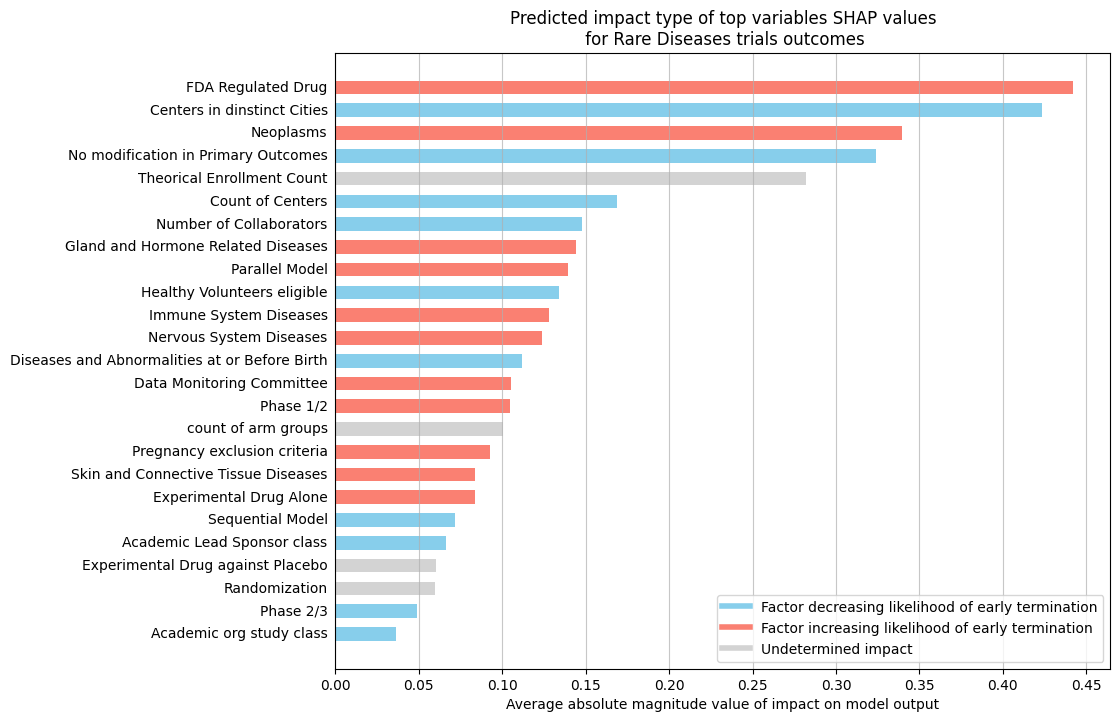

In [311]:

# Filter the DataFrames
x = feature_importance_r[feature_importance_r.index.isin(pos_col)]
y = feature_importance_r[feature_importance_r.index.isin(neg_col)]
z = feature_importance_r[feature_importance_r.index.isin(unk_col)]

# Concatenate the DataFrames
combined_df = pd.concat([x, y, z])

# Sort the combined DataFrame by 'mean_abs_shap_value_test' in descending order
combined_df = combined_df.sort_values(by='mean_abs_shap_value_test', ascending=False)

# Create the plot
plt.figure(figsize=(10, 8))

# Define bar width and positions
bar_width = 0.6
spacing_factor = 1  # Increase this factor to add more space between ticks
indices = np.arange(len(combined_df)) * spacing_factor

# Define color mapping for each original DataFrame
color_mapping = {**{feature: 'skyblue' for feature in x.index},
                 **{feature: 'salmon' for feature in y.index},
                 **{feature: 'lightgray' for feature in z.index}}

# Plot values for the combined DataFrame with specific colors
bar_colors = [color_mapping[feature] for feature in combined_df.index]
plt.barh(indices, combined_df['mean_abs_shap_value_test'], bar_width, color=bar_colors)

plt.xlabel('Average absolute magnitude value of impact on model output')
plt.title('Predicted impact type of top variables SHAP values\n for Rare Diseases trials outcomes')

# Invert the y-axis to have the highest values at the top
plt.gca().invert_yaxis()

# Set x-axis precision to 0.05
x_ticks = np.arange(0, 0.5, 0.05)
plt.xticks(x_ticks)

# Add grid for x and y axes
plt.grid(axis='x', alpha=0.7)

# Customize y-axis labels
for i, feature in enumerate(combined_df.index):
    plt.text(-0.01, i * spacing_factor, feature, ha='right', va='center', color='black', transform=plt.gca().get_yaxis_transform())

# Hide the numbers on the y-axis
plt.gca().get_yaxis().set_ticks([])

# Add a legend for the color coding
custom_lines = [
    plt.Line2D([0], [0], color='skyblue', lw=4, label='Factor decreasing likelihood of early termination'),
    plt.Line2D([0], [0], color='salmon', lw=4, label='Factor increasing likelihood of early termination'),
    plt.Line2D([0], [0], color='lightgray', lw=4, label='Undetermined impact'),
]
plt.legend(handles=custom_lines, loc='lower right')

# Show the plot
plt.show()

In [121]:
all_top_col = [
 'Gland and Hormone Related Diseases',
 'Pregnancy exclusion criteria',
 'No modification in Secondary Outcomes',
 'Experimental Drug against Placebo',
 'Percentage of Industrial Collaborators',
 'Centers in distinct Countries',
 'Diseases and Abnormalities at or Before Birth',
 'Theorical Enrollment Count',
 'Phase 1/2',
 'Phase 2/3',
 'Academic Lead Sponsor class',
 'count of arm groups',
 'Skin and Connective Tissue Diseases',
 'Data Monitoring Committee',
 'Experimental Drug Alone',
 'Count of Centers',
 'Number of Collaborators',
 'No modification in Primary Outcomes',
 'Cross-over Model',
 'Experimental Drug against Active Comparator',
 'Healthy Volunteers eligible',
 'Parallel Model',
 'FDA Regulated Drug',
 'Immune System Diseases',
 'Neoplasms',
 'Randomization',
 'Academic org study class',
 'Nervous System Diseases',
 'Centers in dinstinct Cities',
 'Sequential Model',]

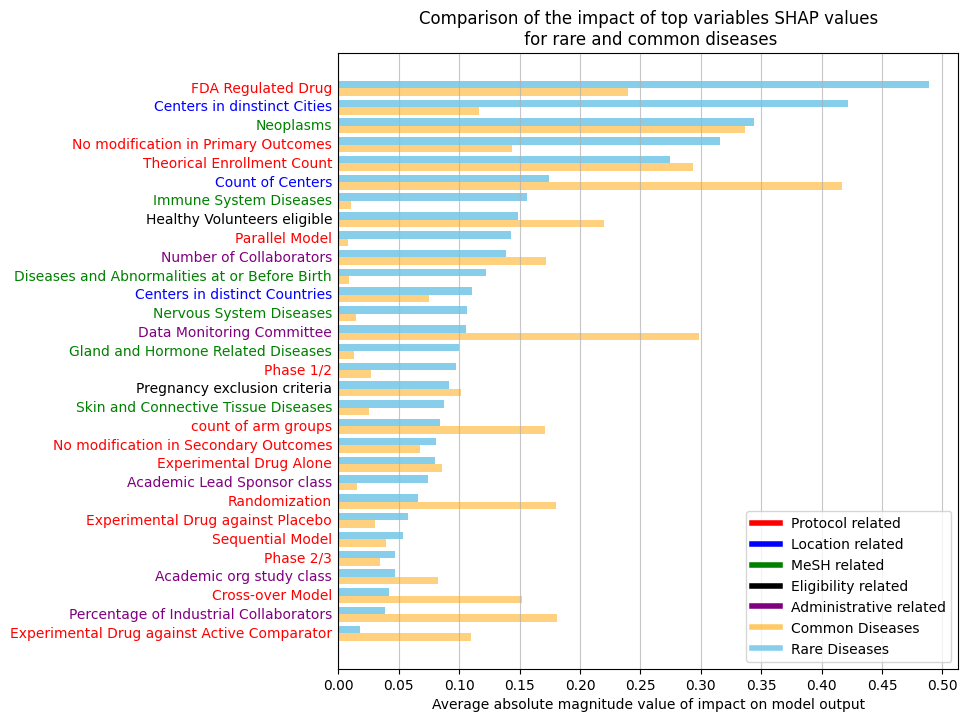

In [122]:
import matplotlib.pyplot as plt
import numpy as np


x=feature_importance_r[feature_importance_r.index.isin(all_top_col)]
y=feature_importance[feature_importance.index.isin(all_top_col)]
# create barh plot with values of mean_abs_shap_value_test
# first sort x by mean_abs_shap_value_test
y = y.sort_values(by='mean_abs_shap_value_test')
x = x.sort_values(by='mean_abs_shap_value_test')
x.rename(columns={'mean_abs_shap_value_test':'mean_abs_shap_value_test_rare_diseases'},inplace=True)
y.rename(columns={'mean_abs_shap_value_test':'mean_abs_shap_value_test_common_diseases'},inplace=True)
# merge x and y on index
feature_merge = pd.merge(x['mean_abs_shap_value_test_rare_diseases'], y['mean_abs_shap_value_test_common_diseases'], left_index=True, right_index=True)
feature_merge.sort_values(by='mean_abs_shap_value_test_rare_diseases',ascending=False,inplace=True)


#feature_merge = feature_merge.sort_values(by='mean_abs_shap_value_test_common_diseases', ascending=False)
# Create the plot
plt.figure(figsize=(8, 8))

# Define bar width and positions
bar_width = 0.6
spacing_factor = 1.5  # Increase this factor to add more space between ticks
indices = np.arange(len(feature_merge)) * spacing_factor

# Plot values for rare diseases
plt.barh(indices - bar_width/2, feature_merge['mean_abs_shap_value_test_rare_diseases'], bar_width, color='skyblue', label='Rare Diseases')

# Plot values for common diseases
plt.barh(indices + bar_width/2, feature_merge['mean_abs_shap_value_test_common_diseases'], bar_width, color='orange',alpha=.5, label='Common Diseases')

plt.xlabel('Average absolute magnitude value of impact on model output')
#plt.ylabel('Feature')

plt.title('Comparison of the impact of top variables SHAP values\n for rare and common diseases')
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest values at the top

# Set x-axis precision to 0.05
x_ticks = np.arange(0, feature_merge[['mean_abs_shap_value_test_rare_diseases', 'mean_abs_shap_value_test_common_diseases']].max().max() + 0.02, 0.05)
plt.xticks(x_ticks)

# Add grid for x and y axes
plt.grid(axis='x', alpha=0.7)

# Define color coding for specific features
color_mapping = {
    'FDA Regulated Drug': 'red',
    'No modification in Primary Outcomes': 'red',
    'No modification in Secondary Outcomes': 'red',
    'Centers in dinstinct Cities': 'blue',
    'Neoplasms': 'green',
    'Theorical Enrollment Count': 'red',
    'Count of Centers': 'blue',
    'Immune System Diseases': 'green',
    'healthyVolunteers': 'black',
    'Parallel Model': 'red',
    'Gland and Hormone Related Diseases': 'green',
    'Number of Collaborators': 'purple',
    'Data Monitoring Committee': 'purple',
    'Nervous System Diseases': 'green',
    'Experimental Drug Alone': 'red',
    'Pregnancy exclusion criteria': 'black',
    'count of arm groups': 'red',
    'Academic Lead Sponsor class': 'purple',
    'Randomization': 'red',
    'Percentage of Industrial Collaborators': 'purple',
    'Academic org study class': 'purple',
    'Cross-over Model': 'red',
    'Experimental Drug against Active Comparator': 'red',
    'Skin and Connective Tissue Diseases' : 'green',
'Diseases and Abnormalities at or Before Birth' : 'green',
'Phase 1/2' : 'red',
'Phase 2/3' : 'red',
'Centers in distinct Countries' : 'blue',
'Experimental Drug against Placebo' : 'red',
'Sequential Model' : 'red',
}

# Customize y-axis labels with color coding
for i, feature in enumerate(feature_merge.index):
    color = color_mapping.get(feature, 'black')  # Default color is black
    plt.text(-0.01, indices[i], feature, ha='right', va='center', color=color, transform=plt.gca().get_yaxis_transform())

# Hide the numbers on the y-axis
plt.gca().get_yaxis().set_ticks([])

# Add a legend for the color coding
custom_lines = [
    plt.Line2D([0], [0], color='red', lw=4, label='Protocol related'),
    plt.Line2D([0], [0], color='blue', lw=4, label='Location related'),
    plt.Line2D([0], [0], color='green', lw=4, label='MeSH related'),
    plt.Line2D([0], [0], color='black', lw=4, label='Eligibility related'),
    plt.Line2D([0], [0], color='purple', lw=4, label='Administrative related'),
    plt.Line2D([0], [0], color='orange',alpha=.6, lw=4, label='Common Diseases'),
    plt.Line2D([0], [0], color='skyblue', lw=4, label='Rare Diseases'),
]
plt.legend(handles=custom_lines, loc='lower right')

# Show the plot
plt.show()


In [123]:
new_rare=feature_importance_r[feature_importance_r['mean_abs_shap_value_test']>=0.05][['mean_abs_shap_value_test']].index.to_list()



Accuracy: 0.675
Precision: 0.557
Recall: 0.644
F1 Score: 0.597
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.73       857
           1       0.56      0.64      0.60       514

    accuracy                           0.67      1371
   macro avg       0.66      0.67      0.66      1371
weighted avg       0.69      0.67      0.68      1371

PR-AUC: 0.603
ROC-AUC: 0.735


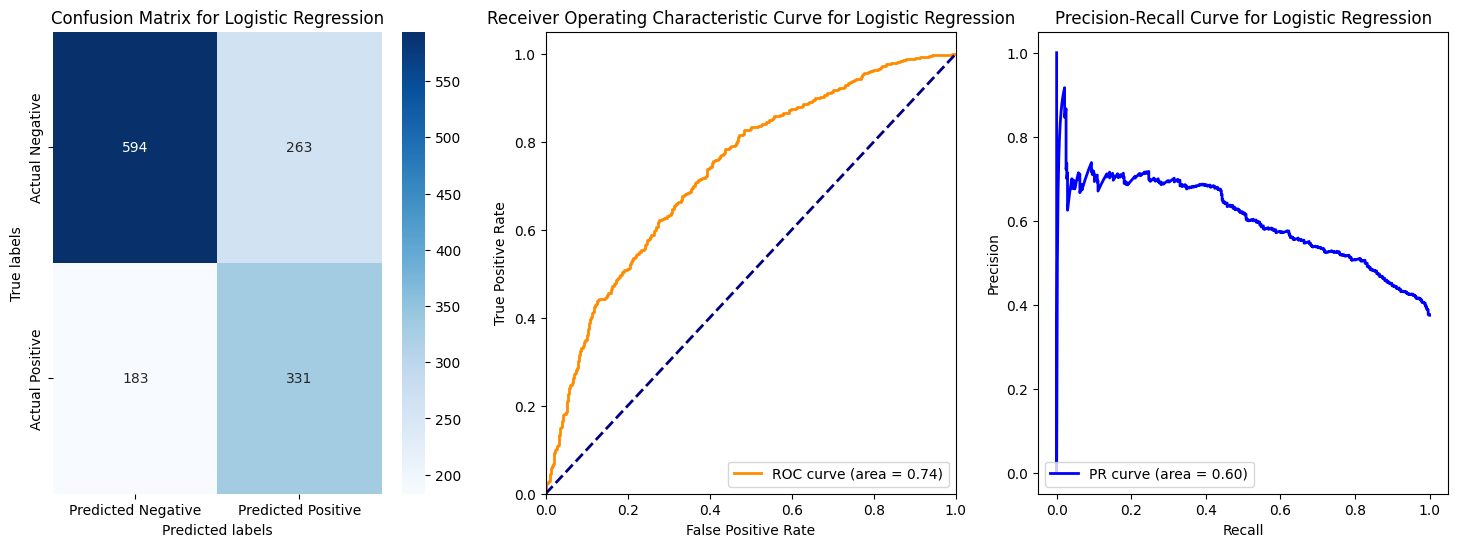

K-fold cross-validation results:
LogisticRegression average accuracy: 0.688 ± 0.05
LogisticRegression average log_loss: 0.601 ± 0.05
LogisticRegression average auc: 0.743 ± 0.06
LogisticRegression average f1: 0.626 ± 0.05
LogisticRegression average pr_auc: 0.651 ± 0.07
LogisticRegression average recall: 0.672 ± 0.08
LogisticRegression average precision: 0.592 ± 0.07


In [124]:
X = ct_rawr.drop('overallStatus', axis=1)
y = ct_rawr['overallStatus']
X = X[new_rare]
logreg_rare = LR_model(X,y)

Accuracy: 0.686
Precision: 0.471
Recall: 0.600
F1 Score: 0.528
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      1417
           1       0.47      0.60      0.53       587

    accuracy                           0.69      2004
   macro avg       0.64      0.66      0.65      2004
weighted avg       0.71      0.69      0.70      2004

PR-AUC: 0.524
ROC-AUC: 0.733


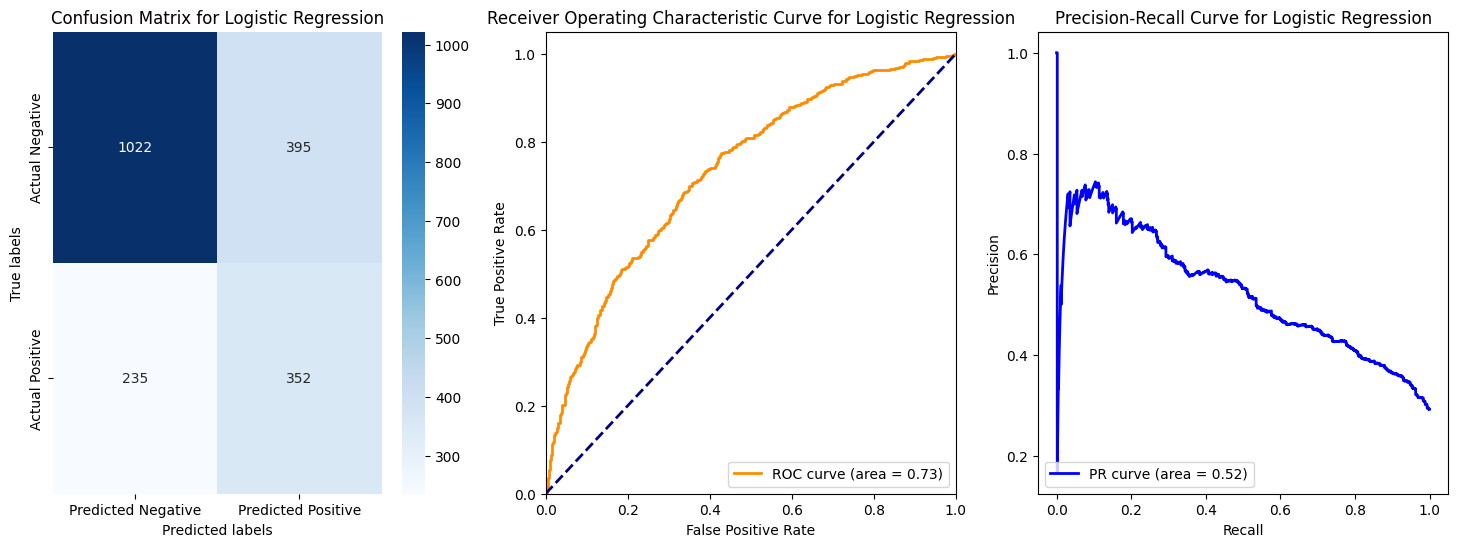

K-fold cross-validation results:
LogisticRegression average accuracy: 0.690 ± 0.05
LogisticRegression average log_loss: 0.601 ± 0.05
LogisticRegression average auc: 0.738 ± 0.04
LogisticRegression average f1: 0.550 ± 0.03
LogisticRegression average pr_auc: 0.558 ± 0.06
LogisticRegression average recall: 0.651 ± 0.06
LogisticRegression average precision: 0.485 ± 0.06


In [125]:
X = ct_rawn.drop('overallStatus', axis=1)
y = ct_rawn['overallStatus']
X = X[new_rare]
logreg_n = LR_model(X,y)

Accuracy: 0.726
Precision: 0.656
Recall: 0.564
F1 Score: 0.607
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       857
           1       0.66      0.56      0.61       514

    accuracy                           0.73      1371
   macro avg       0.71      0.69      0.70      1371
weighted avg       0.72      0.73      0.72      1371

PR-AUC: 0.654
ROC-AUC: 0.770


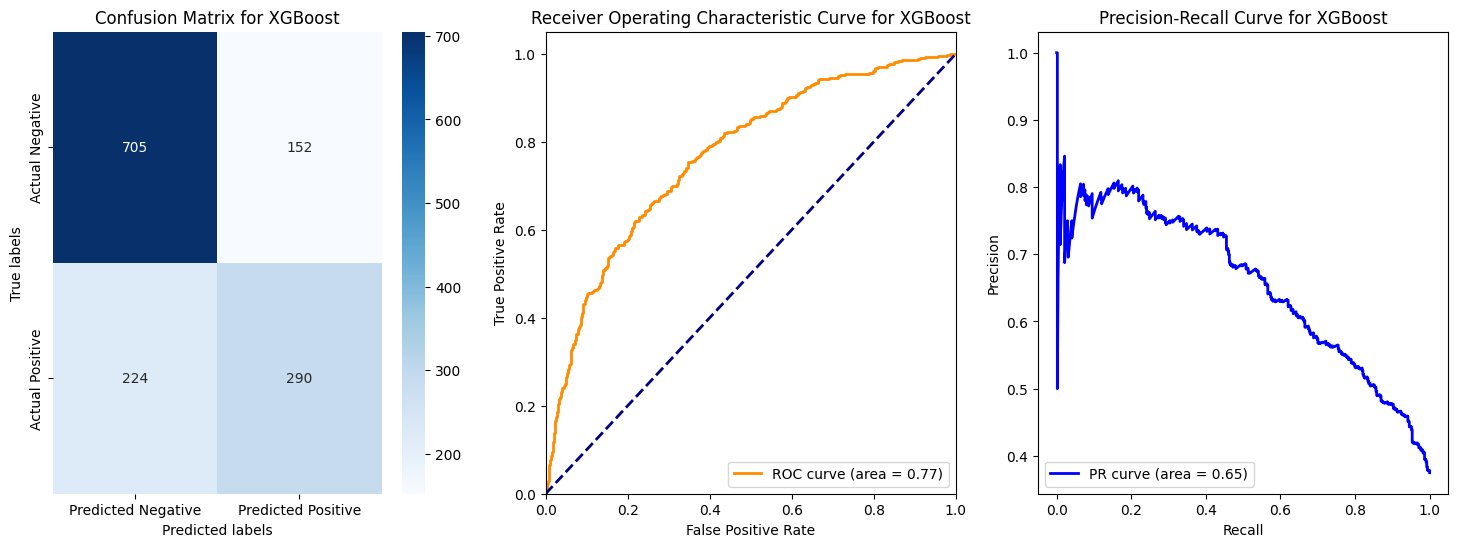

K-fold cross-validation results:
XGBClassifier average accuracy: 0.688 ± 0.05
XGBClassifier average log_loss: 0.662 ± 0.08
XGBClassifier average auc: 0.724 ± 0.05
XGBClassifier average f1: 0.564 ± 0.05
XGBClassifier average pr_auc: 0.632 ± 0.07
XGBClassifier average recall: 0.520 ± 0.06
XGBClassifier average precision: 0.625 ± 0.09


In [126]:
X = ct_rawr.drop('overallStatus', axis=1)
y = ct_rawr['overallStatus']
X = X[new_rare]
xgb_rare = XGB_model(X,y)

Accuracy: 0.766
Precision: 0.654
Recall: 0.431
F1 Score: 0.520
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      1417
           1       0.65      0.43      0.52       587

    accuracy                           0.77      2004
   macro avg       0.72      0.67      0.68      2004
weighted avg       0.75      0.77      0.75      2004

PR-AUC: 0.627
ROC-AUC: 0.775


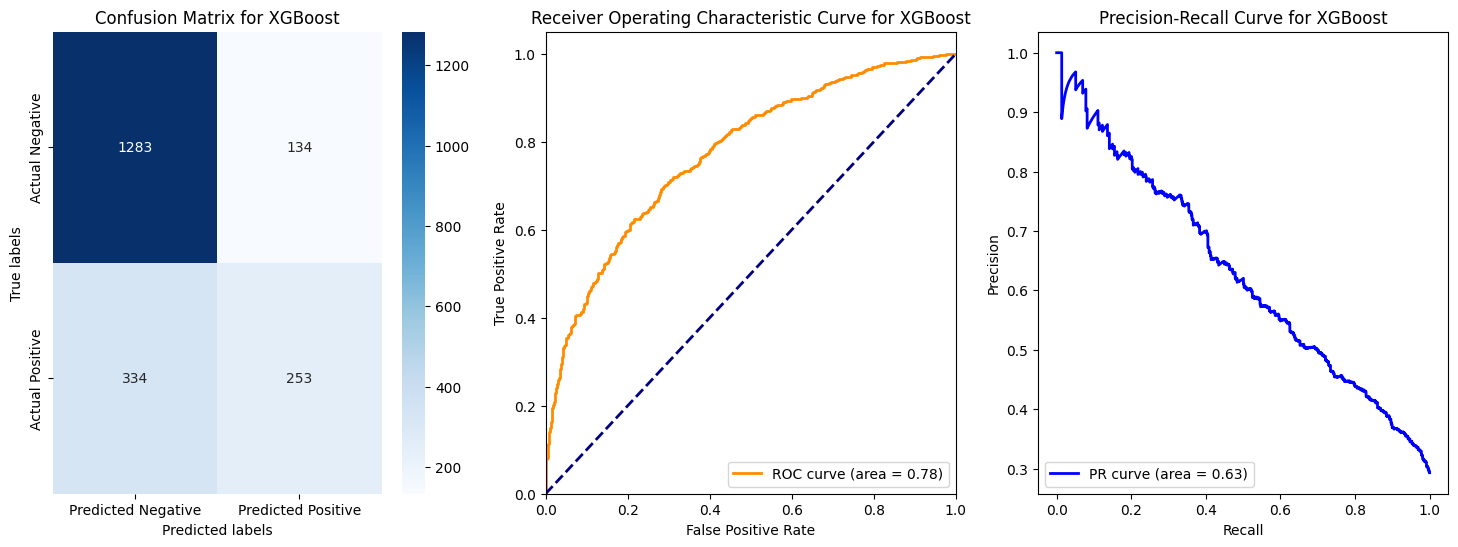

K-fold cross-validation results:
XGBClassifier average accuracy: 0.752 ± 0.03
XGBClassifier average log_loss: 0.542 ± 0.05
XGBClassifier average auc: 0.752 ± 0.04
XGBClassifier average f1: 0.494 ± 0.06
XGBClassifier average pr_auc: 0.597 ± 0.06
XGBClassifier average recall: 0.424 ± 0.08
XGBClassifier average precision: 0.609 ± 0.08


In [127]:
X = ct_rawn.drop('overallStatus', axis=1)
y = ct_rawn['overallStatus']
X = X[new_rare]
xgb_n = XGB_model(X,y)

In [128]:

xgb_noise['name'] = 'XGB RD'
xgb_rare['name'] = 'XGB RD Top Features'

logreg_rare['name'] = 'LR RD Top Features'
logreg_noise['name'] = 'LR RD'

xgb_noise1['name'] = 'XGB CD'
xgb_n['name'] = 'XGB CD Top Features'

logreg_n['name'] = 'LR CD Top Features'
logreg_noise1['name'] = 'LR CD'



In [129]:
%%jmd 
# Overall Summary - All Rare Diseases
[//]: <> (-.- tabset tabset-pills)

# Overall Summary - All Rare Diseases
<span class='pj-token' style='display: none;'>tabset|O_O|tabset-pills</span>

In [130]:
%%jmd 
## Model Evaluation based on 10 fold Cross-Validation

## Model Evaluation based on 10 fold Cross-Validation

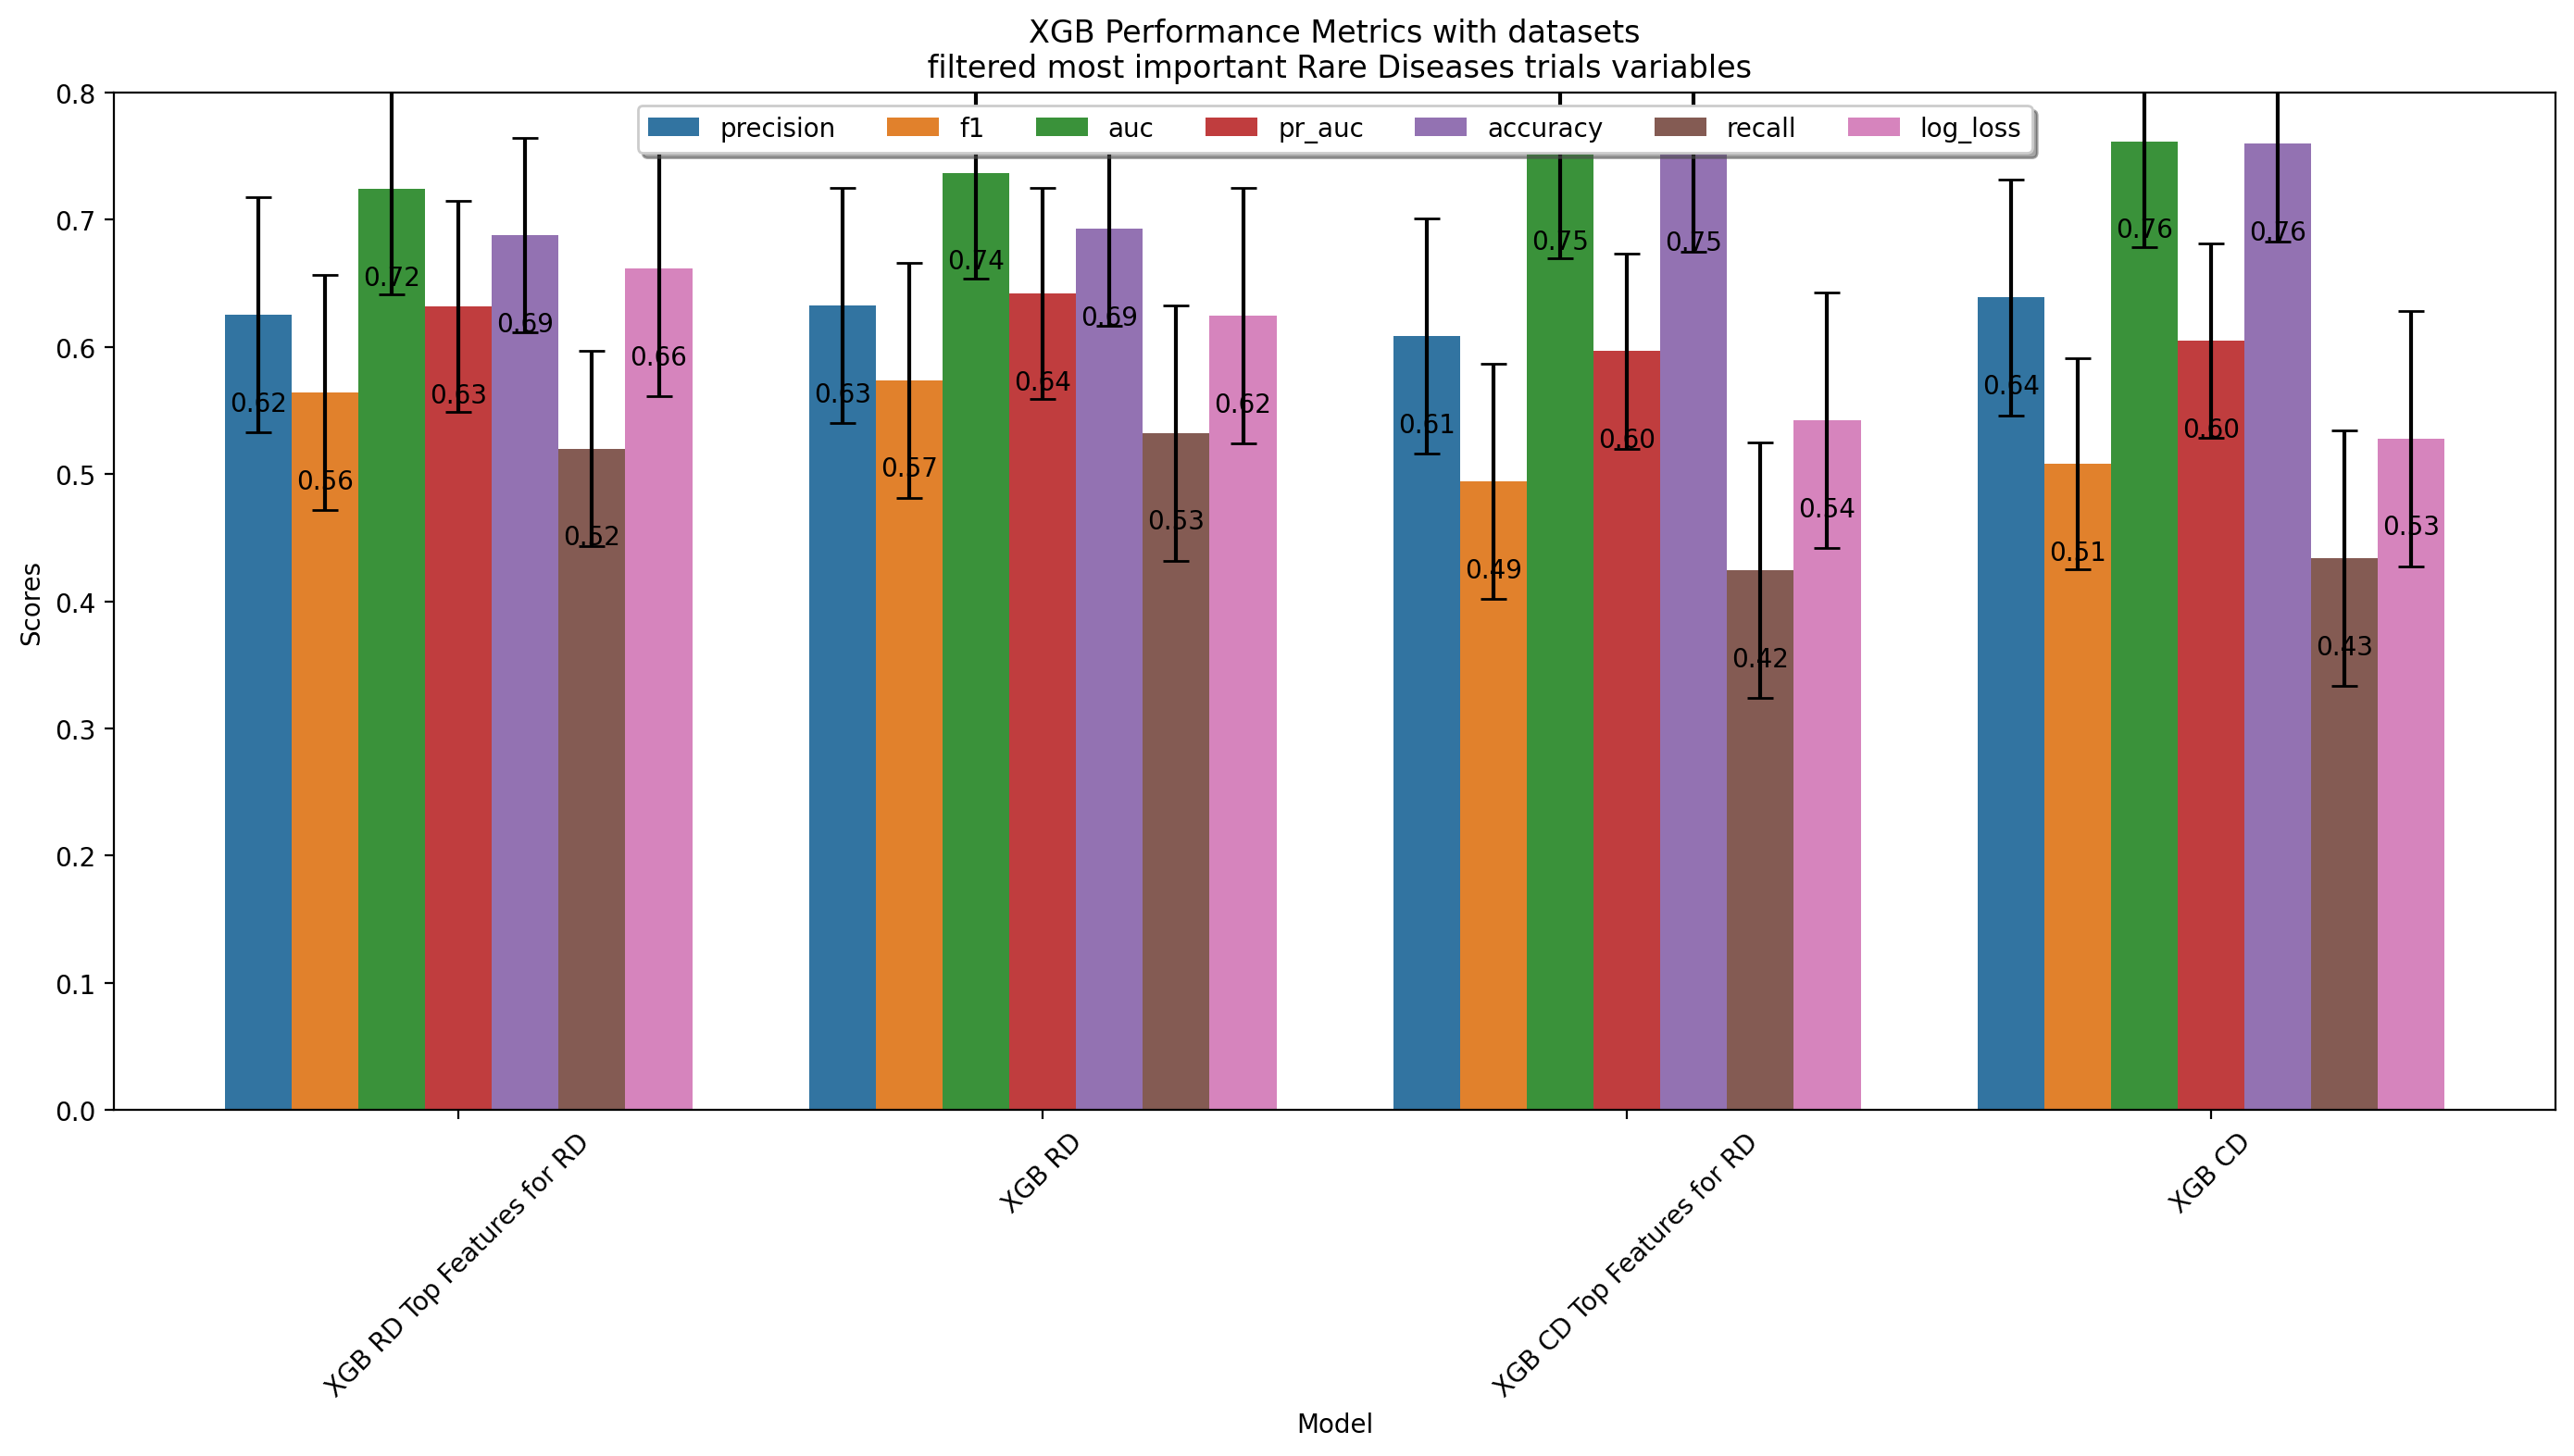

Model     precision            f1           auc  \
0  XGB RD Top Features for RD  0.625 ± 0.09  0.564 ± 0.05  0.724 ± 0.05   
1                      XGB RD  0.633 ± 0.08  0.574 ± 0.04  0.737 ± 0.05   
2  XGB CD Top Features for RD  0.609 ± 0.08  0.494 ± 0.06  0.752 ± 0.04   
3                      XGB CD  0.639 ± 0.10  0.508 ± 0.07  0.762 ± 0.05   

         pr_auc      accuracy        recall      log_loss  
0  0.632 ± 0.07  0.688 ± 0.05  0.520 ± 0.06  0.662 ± 0.08  
1  0.642 ± 0.07  0.693 ± 0.04  0.532 ± 0.05  0.625 ± 0.07  
2  0.597 ± 0.06  0.752 ± 0.03  0.424 ± 0.08  0.542 ± 0.05  
3  0.605 ± 0.06  0.760 ± 0.03  0.434 ± 0.08  0.528 ± 0.05

In [149]:
# Step 1: Create the DataFrame with Accuracy, Log-Loss, ROC-AUC, F1, PR-AUC, Recall, Precision, and their standard deviations

dictionaries = [xgb_rare['CV_scoring'], xgb_noise['CV_scoring'],xgb_n['CV_scoring'], xgb_noise1['CV_scoring']]
dictionary_name = ['XGB RD Top Features for RD',  'XGB RD','XGB CD Top Features for RD',  'XGB CD']
metrics = ['precision','f1','auc','pr_auc','accuracy', 'recall', 'log_loss']
cv_data = {
    'Model': dictionary_name  # ['logreg', 'xgb']
}
# Dynamically populate the DataFrame columns for each metric and its standard deviation
for metric in metrics:
    cv_data[metric] = [d[d['Metric'] == metric]['Mean Score'].values[0] for d in dictionaries]
    cv_data[f'{metric} Std'] = [d[d['Metric'] == metric]['Standard Deviation'].values[0] for d in dictionaries]

# Create the DataFrame from the constructed dictionary
df_models_cv = pd.DataFrame(cv_data)


# Step 2: Plot function to include all metrics with error bars
def plot_selected_scores_seaborn():
    # Define the metrics to plot
    metrics = ['precision','f1','auc','pr_auc','accuracy', 'recall', 'log_loss']
    
    # Create standard deviation metric names
    std_metrics = [f'{metric} Std' for metric in metrics]
    
    # Melt the DataFrame to make it suitable for Seaborn's barplot
    df_melted = df_models_cv.melt(id_vars="Model", value_vars=metrics, var_name="Score", value_name="Value")
    df_melted_std = df_models_cv.melt(id_vars="Model", value_vars=std_metrics, var_name="Score Std", value_name="Std")
    
    # Merge the melted DataFrames to have both Value and Std in the same DataFrame
    df_melted['Std'] = df_melted_std['Std']
    
    # Set the figure size
    plt.figure(figsize=(14, 8))
    
    # Create a bar plot with error bars
    barplot = sns.barplot(x='Model', y='Value', hue='Score', data=df_melted, ci=None)
    
    # Add error bars for each bar
    for i, bar in enumerate(barplot.patches):
        if bar.get_height() > 0:
            # Determine the corresponding model and metric (score)
            model = df_melted.iloc[i // len(metrics)]['Model']
            score = df_melted.iloc[i // len(metrics)]['Score']
            # Retrieve the corresponding standard deviation
            std = df_melted[(df_melted['Model'] == model) & (df_melted['Score'] == score)]['Std'].values[0]
            # Add the error bar
            barplot.errorbar(bar.get_x() + bar.get_width() / 2, bar.get_height(), yerr=std, fmt='none', c='black', capsize=5)

    # Annotate numerical values on top of each bar
    for p in barplot.patches:
        if p.get_height() > 0:
            barplot.annotate(format(p.get_height(), '.2f'), 
                            (p.get_x() + p.get_width() / 2., p.get_height() -.1), 
                            ha='center', va='bottom', 
                            xytext=(0, 10), 
                            textcoords='offset points')
    
    # Final touches for the plot
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.xlabel('Model')  # X-axis label
    plt.ylabel('Scores')  # Y-axis label
    plt.ylim(0, .8)  # Y-axis limit (assuming scores are normalized between 0 and 1)
    plt.title('XGB Performance Metrics with datasets\n filtered most important Rare Diseases trials variables')  # Title
    plt.tight_layout()  # Adjust layout to fit elements properly
    plt.legend(loc='upper center', shadow=True, ncol=7)
    plt.show()  # Display the plot

# Call the function to generate and display the plot
plot_selected_scores_seaborn()
# Create a new DataFrame with formatted metrics
formatted_data = {
    'Model': df_models_cv['Model']
}
for metric in metrics:
    formatted_data[metric] = df_models_cv.apply(lambda row: format_metric_with_std(row, metric), axis=1)
df_formatted = pd.DataFrame(formatted_data)
df_formatted

In [132]:
%%jmd 
## Model Evaluation based on 10 fold Cross-Validation

## Model Evaluation based on 10 fold Cross-Validation

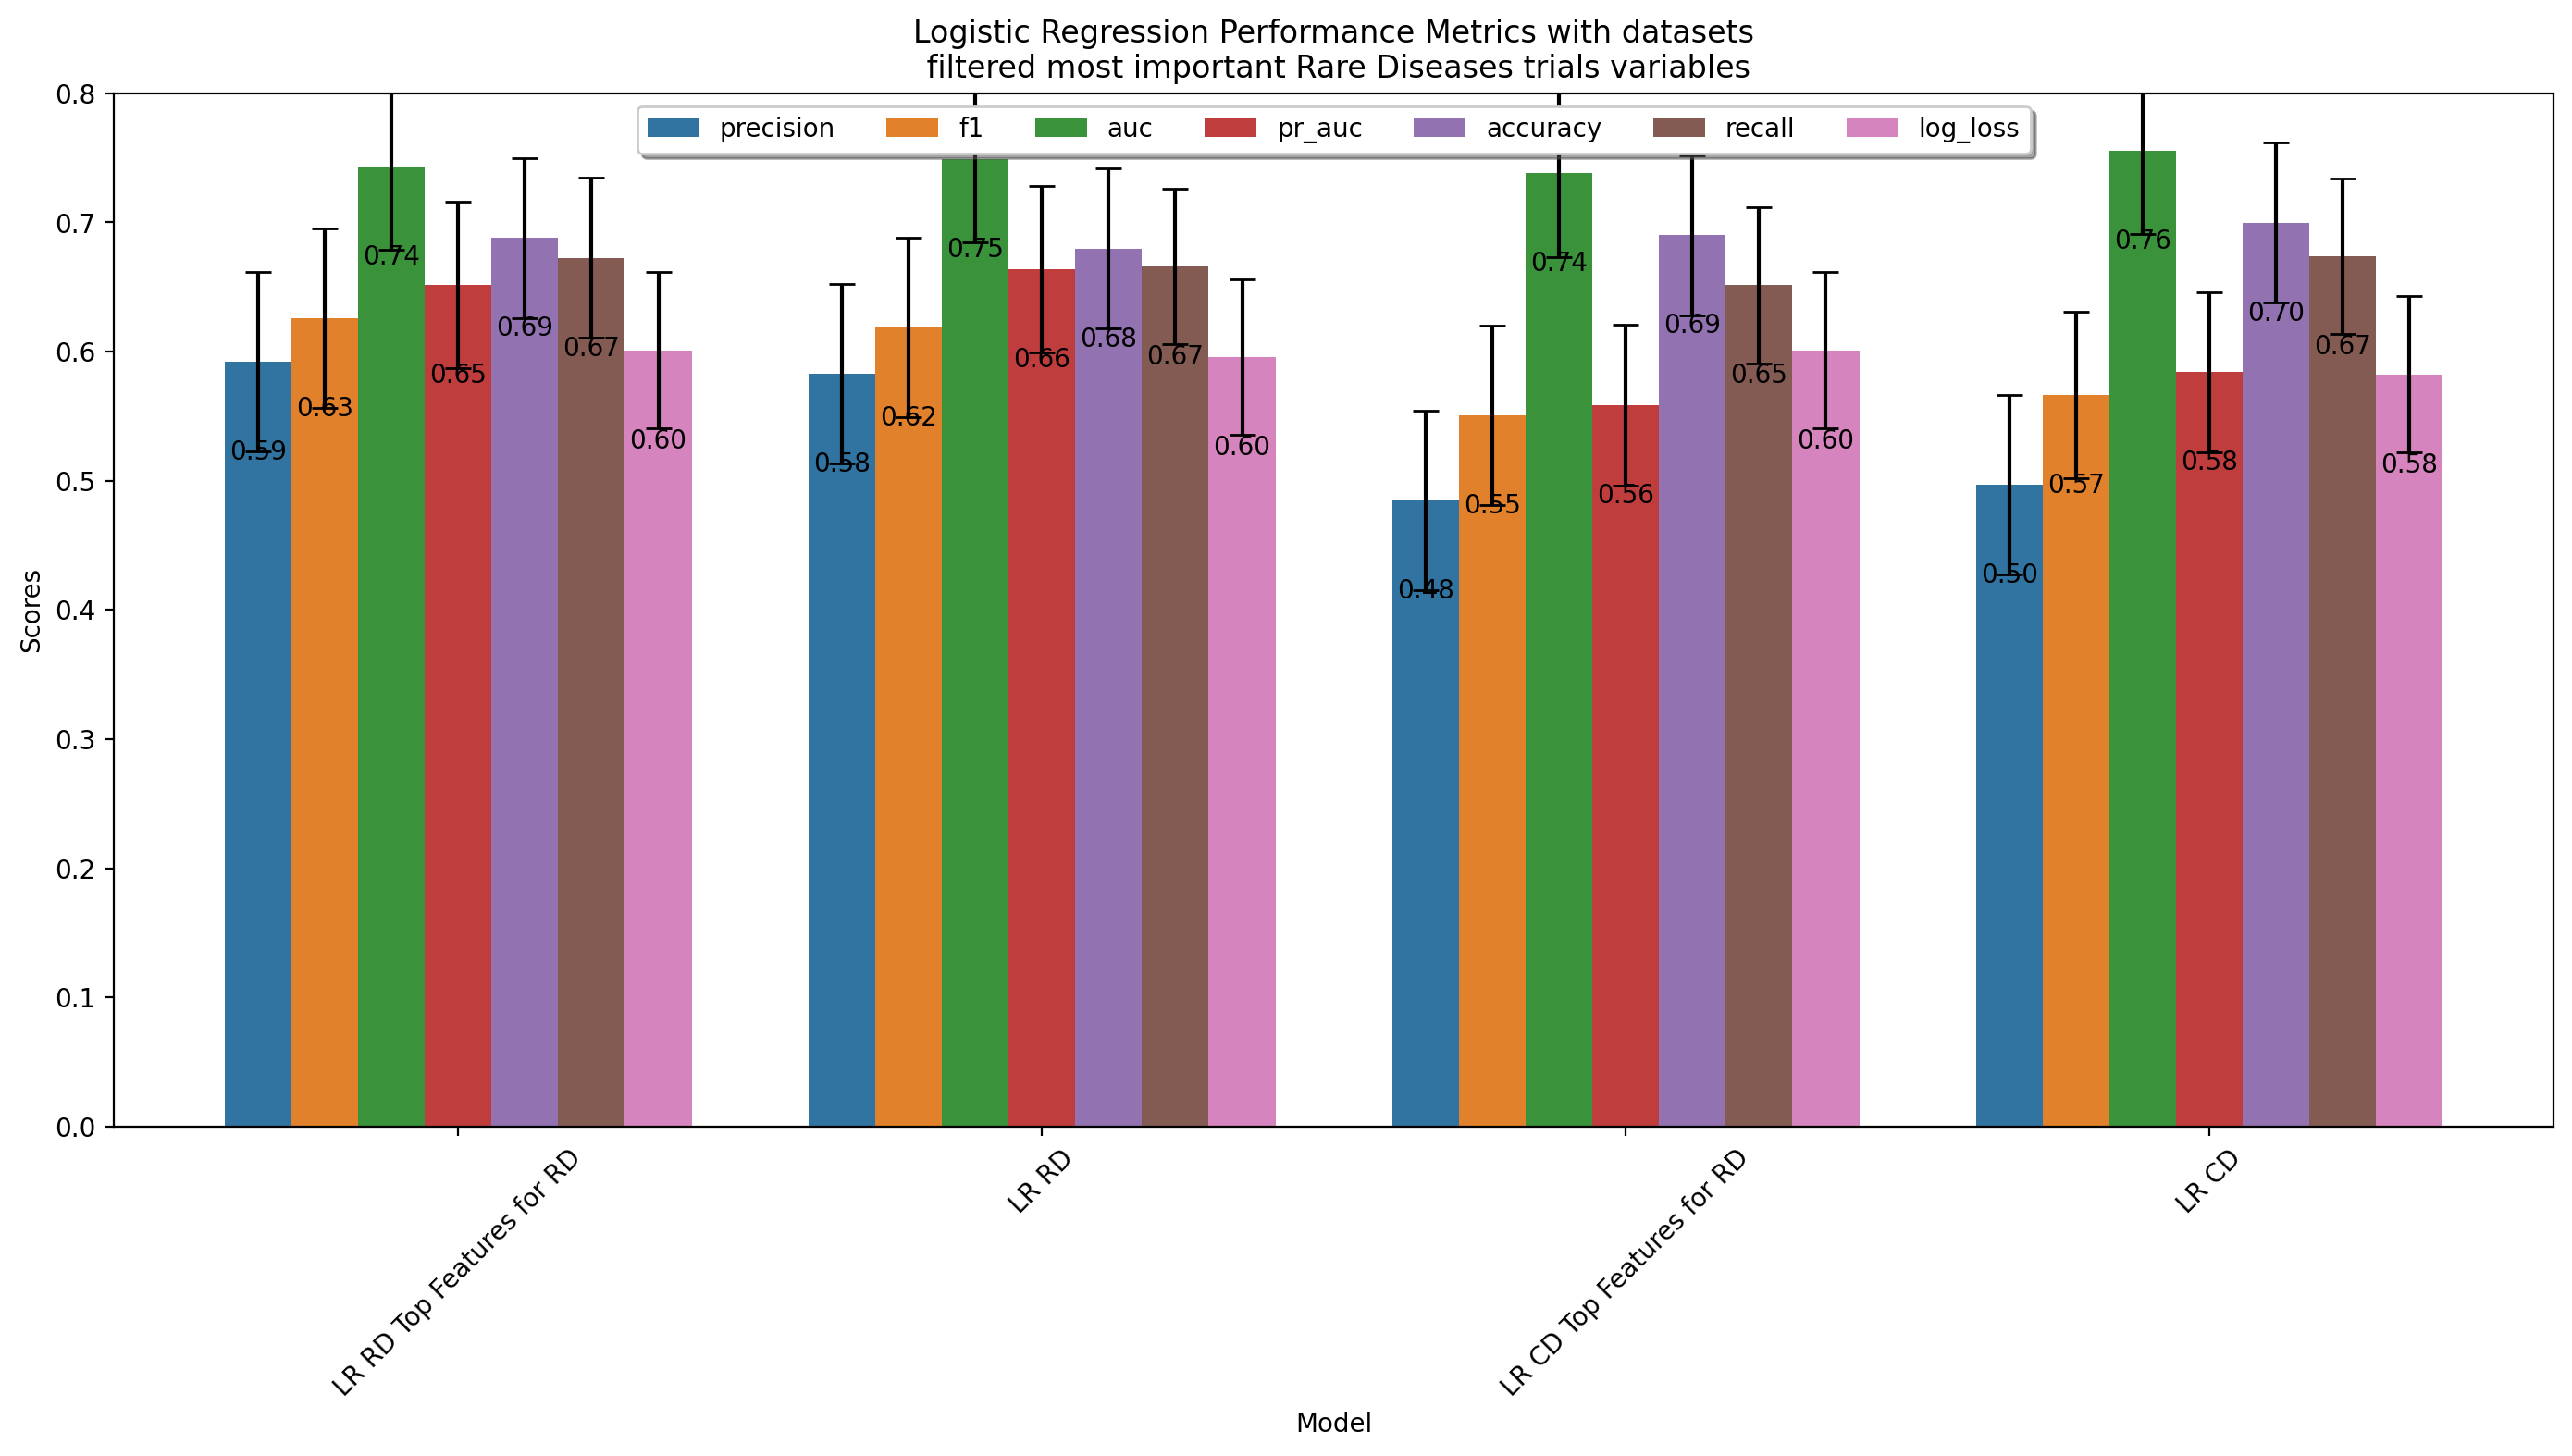

Model     precision            f1           auc  \
0  LR RD Top Features for RD  0.592 ± 0.07  0.626 ± 0.05  0.743 ± 0.06   
1                      LR RD  0.583 ± 0.06  0.618 ± 0.04  0.749 ± 0.06   
2  LR CD Top Features for RD  0.485 ± 0.06  0.550 ± 0.03  0.738 ± 0.04   
3                      LR CD  0.497 ± 0.06  0.566 ± 0.03  0.755 ± 0.04   

         pr_auc      accuracy        recall      log_loss  
0  0.651 ± 0.07  0.688 ± 0.05  0.672 ± 0.08  0.601 ± 0.05  
1  0.664 ± 0.07  0.680 ± 0.05  0.666 ± 0.06  0.596 ± 0.06  
2  0.558 ± 0.06  0.690 ± 0.05  0.651 ± 0.06  0.601 ± 0.05  
3  0.584 ± 0.06  0.700 ± 0.05  0.674 ± 0.07  0.582 ± 0.06

In [150]:

dictionaries = [logreg_rare['CV_scoring'], logreg_noise['CV_scoring'],logreg_n['CV_scoring'], logreg_noise1['CV_scoring']]
dictionary_name = ['LR RD Top Features for RD',  'LR RD','LR CD Top Features for RD',  'LR CD']
metrics = ['precision','f1','auc','pr_auc','accuracy', 'recall', 'log_loss']
cv_data = {
    'Model': dictionary_name  # ['logreg', 'xgb']
}
# Dynamically populate the DataFrame columns for each metric and its standard deviation
for metric in metrics:
    cv_data[metric] = [d[d['Metric'] == metric]['Mean Score'].values[0] for d in dictionaries]
    cv_data[f'{metric} Std'] = [d[d['Metric'] == metric]['Standard Deviation'].values[0] for d in dictionaries]

# Create the DataFrame from the constructed dictionary
df_models_cv = pd.DataFrame(cv_data)


# Step 2: Plot function to include all metrics with error bars
def plot_selected_scores_seaborn():
    # Define the metrics to plot
    metrics = ['precision','f1','auc','pr_auc','accuracy', 'recall', 'log_loss']
    
    # Create standard deviation metric names
    std_metrics = [f'{metric} Std' for metric in metrics]
    
    # Melt the DataFrame to make it suitable for Seaborn's barplot
    df_melted = df_models_cv.melt(id_vars="Model", value_vars=metrics, var_name="Score", value_name="Value")
    df_melted_std = df_models_cv.melt(id_vars="Model", value_vars=std_metrics, var_name="Score Std", value_name="Std")
    
    # Merge the melted DataFrames to have both Value and Std in the same DataFrame
    df_melted['Std'] = df_melted_std['Std']
    
    # Set the figure size
    plt.figure(figsize=(14, 8))
    
    # Create a bar plot with error bars
    barplot = sns.barplot(x='Model', y='Value', hue='Score', data=df_melted, ci=None)
    
    # Add error bars for each bar
    for i, bar in enumerate(barplot.patches):
        if bar.get_height() > 0:
            # Determine the corresponding model and metric (score)
            model = df_melted.iloc[i // len(metrics)]['Model']
            score = df_melted.iloc[i // len(metrics)]['Score']
            # Retrieve the corresponding standard deviation
            std = df_melted[(df_melted['Model'] == model) & (df_melted['Score'] == score)]['Std'].values[0]
            # Add the error bar
            barplot.errorbar(bar.get_x() + bar.get_width() / 2, bar.get_height(), yerr=std, fmt='none', c='black', capsize=5)

    # Annotate numerical values on top of each bar
    for p in barplot.patches:
        if p.get_height() > 0:
            barplot.annotate(format(p.get_height(), '.2f'), 
                            (p.get_x() + p.get_width() / 2., p.get_height() -.1), 
                            ha='center', va='bottom', 
                            xytext=(0, 10), 
                            textcoords='offset points')
    
    # Final touches for the plot
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.xlabel('Model')  # X-axis label
    plt.ylabel('Scores')  # Y-axis label
    plt.ylim(0, .8)  # Y-axis limit (assuming scores are normalized between 0 and 1)
    plt.title('Logistic Regression Performance Metrics with datasets\n filtered most important Rare Diseases trials variables')  # Title
    plt.tight_layout()  # Adjust layout to fit elements properly
    #legend at the bottom in one line
    plt.legend(loc='upper center', shadow=True, ncol=7)
    plt.show()  # Display the plot

# Call the function to generate and display the plot
plot_selected_scores_seaborn()
# Create a new DataFrame with formatted metrics
formatted_data = {
    'Model': df_models_cv['Model']
}
for metric in metrics:
    formatted_data[metric] = df_models_cv.apply(lambda row: format_metric_with_std(row, metric), axis=1)
df_formatted = pd.DataFrame(formatted_data)
df_formatted

In [134]:
shap_int = xgb_rare
shap_interpreter = ShapModelInterpreter(shap_int['model'])
feature_importance = shap_interpreter.fit_compute(shap_int['X_train'],shap_int['X_test'], shap_int['y_train'], shap_int['y_test'])
 


 93%|=================== | 1521/1644 [00:13<00:01]       

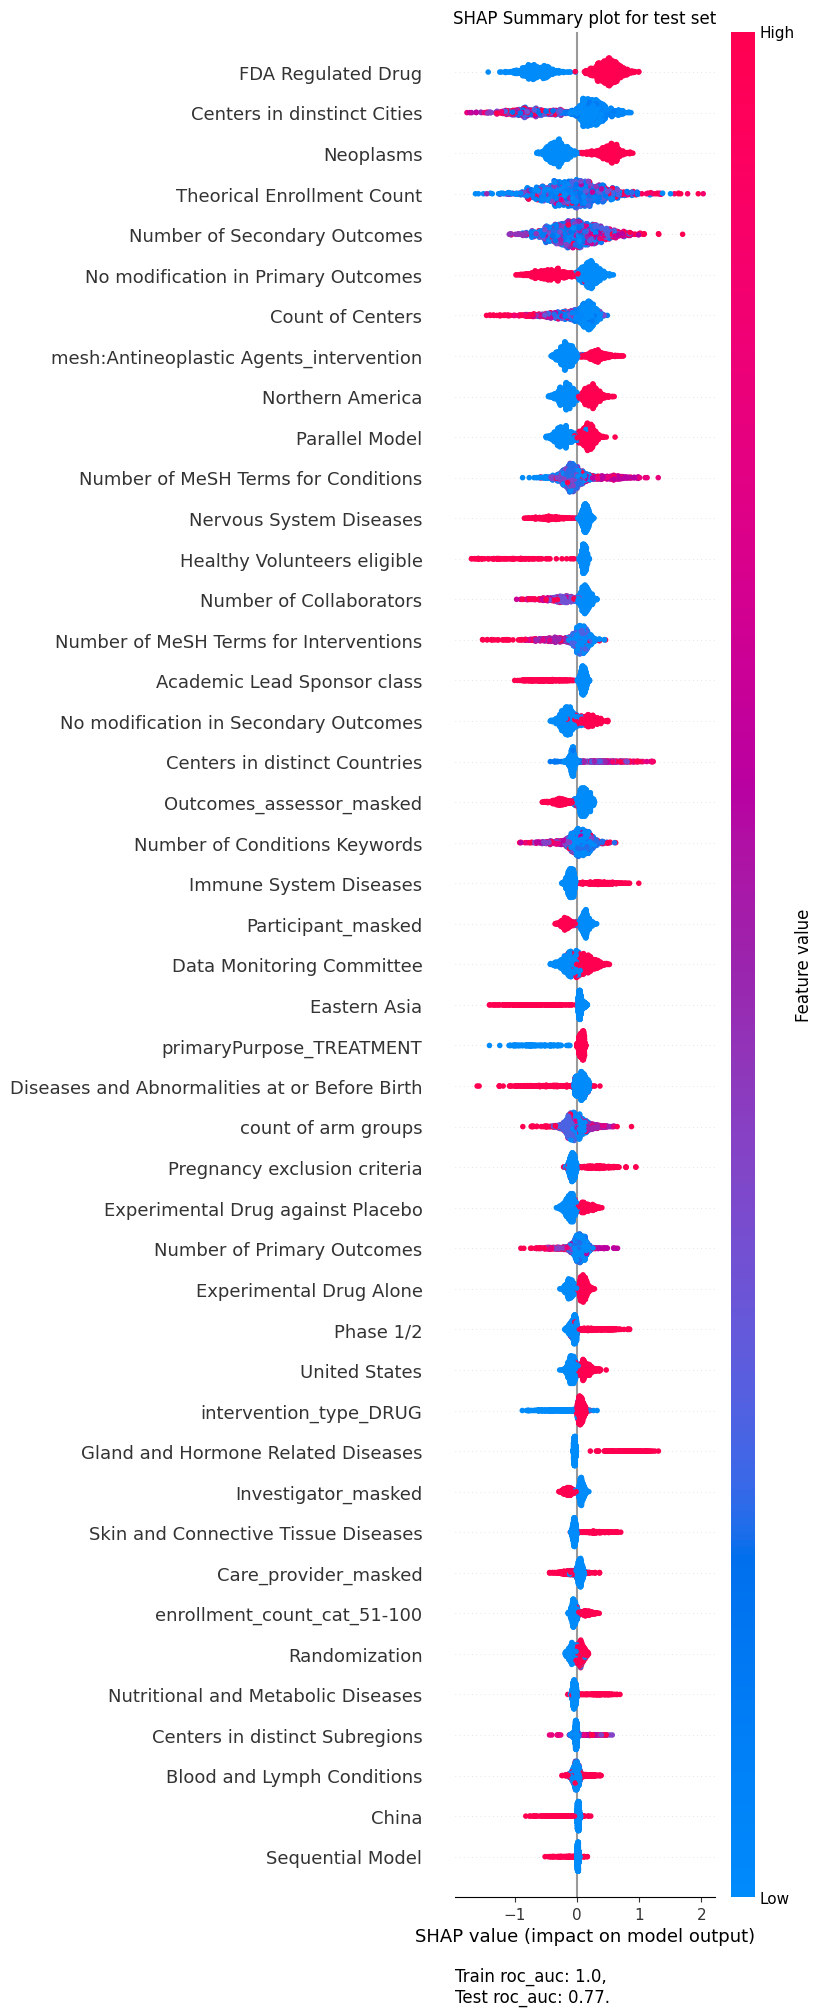

In [135]:

ax2 = shap_interpreter.plot('summary', max_display=60)

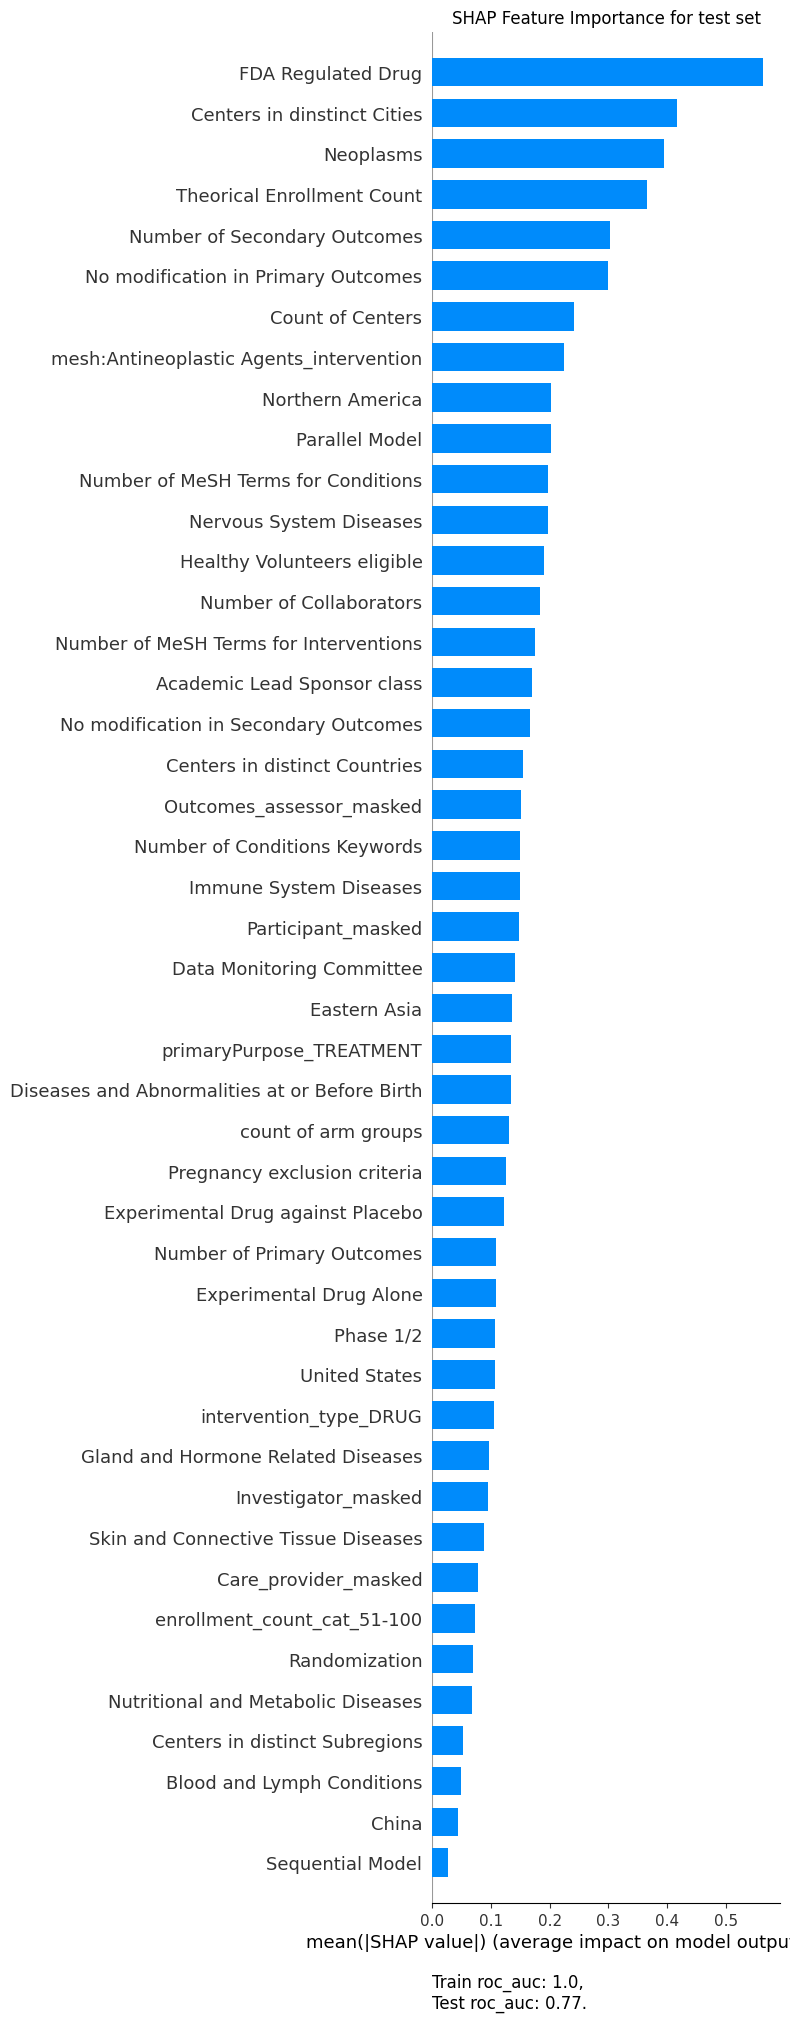

In [136]:

ax2 = shap_interpreter.plot('importance', max_display=60)

In [137]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(feature_importance, top_n=30, threshold=0.5):
    """
    Plots a horizontal bar plot of the mean_abs_shap_value_test column from the feature_importance DataFrame.
    
    Parameters:
    feature_importance (pd.DataFrame): DataFrame containing the feature importance values.
    """
    # Sort the DataFrame by mean_abs_shap_value_test in descending order
    feature_importance = feature_importance.sort_values(by='mean_abs_shap_value_test', ascending=False)
    feature_importance = feature_importance.head(top_n)
    
    # Create the plot
    plt.figure(figsize=(18, 16))
    plt.barh(feature_importance.index, feature_importance['mean_abs_shap_value_test'])
    
    # Add labels and title
    plt.xlabel('Mean Absolute SHAP Value')
    plt.ylabel('Feature')
    plt.title('Feature Importance based on Mean Absolute SHAP Values')
    
    # Set x-axis ticks every 0.05
    max_value = feature_importance['mean_abs_shap_value_test'].max()
    x_ticks = np.arange(0, max_value + 0.05, 0.05)
    plt.xticks(x_ticks)
    # Add vertical grid lines
    plt.grid(axis='x', alpha=0.7)
    # limit x range
    plt.xlim(0, threshold )
    
    # Invert y-axis to have the highest values at the top
    plt.gca().invert_yaxis()
    
    # Show the plot
    plt.show()

# Example usage:
# Assuming feature_importance is already defined
#plot_feature_importance(feature_importance,10,0.5)

In [138]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss, make_scorer
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
from IPython.display import Image


# Prepare the data
X = ct_rawr.drop('overallStatus', axis=1)
y = ct_rawr['overallStatus']
X = X[new_rare]



Best parameters found:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 30, 'splitter': 'best'}
10-fold cross-validation results:
Accuracy: 0.645 ± 0.005
Precision: 0.652 ± 0.025
Pr_auc: 0.652 ± 0.007
Roc_auc: 0.687 ± 0.001
Log_loss: 0.864 ± 0.057
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       857
           1       0.53      0.63      0.58       514

    accuracy                           0.65      1371
   macro avg       0.64      0.65      0.64      1371
weighted avg       0.67      0.65      0.66      1371



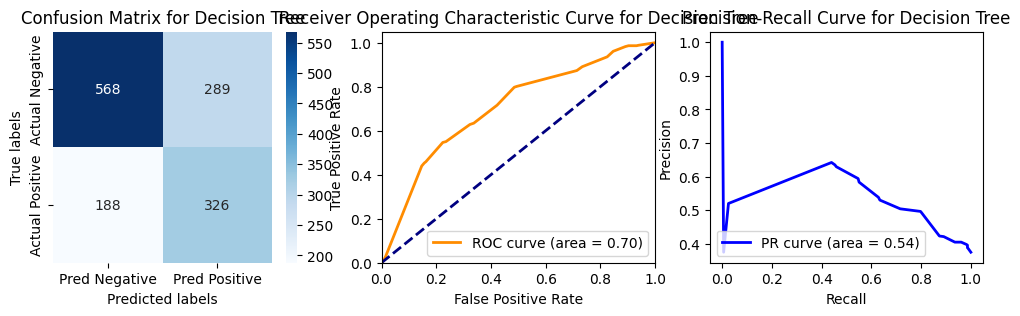

In [139]:

X_trainx, X_test, y_trainx, y_test = train_test_split(X, y, test_size=0.5, random_state=3)
# Apply RandomOverSampler to balance the training data
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_trainx, y_trainx)
# Apply RandomOverSampler to balance the training data
feature_names = X_train.columns

# Set up the parameter grid for GridSearchCV with simpler parameters
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'max_depth': [3, 4,5],  # Limit the depth of the tree
    'min_samples_split': [30, 20],  # Require more samples to split a node
    'min_samples_leaf': [10,20, 30],  # Require more samples in each leaf node
    'class_weight': ['balanced']
}

# Initialize the decision tree classifier with class_weight='balanced'
clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)
# Train the decision tree classifier with the best parameters
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)
# Perform 10-fold cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'pr_auc': 'average_precision',
    'roc_auc': 'roc_auc',
    'log_loss': 'neg_log_loss'
}
cv_results = cross_validate(best_clf, X_train, y_train, cv=2, scoring=scoring, return_train_score=False)
# Print cross-validation results
print("10-fold cross-validation results:")
for metric in scoring.keys():
    if metric == 'log_loss':
        scores = -cv_results[f'test_{metric}']
    else:
        scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize()}: {scores.mean():.3f} ± {scores.std():.3f}")

# Predict on the test set
y_pred_prob = best_clf.predict_proba(X_test)
threshold = 0.53
y_pred = (y_pred_prob[:, 1] >= threshold).astype(int)

# Evaluate the model
model_name = 'Decision Tree'
accuracy = accuracy_score(y_test, y_pred)
xprecision = precision_score(y_test, y_pred)
xrecall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for ' + model_name)

print("Classification Report:")
print(classification_report(y_test, y_pred))
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob[:, 1])
pr_auc = auc(recall, precision)

fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)



plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve for ' + model_name)
plt.legend(loc="lower right")

plt.subplot(1, 3, 3)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for ' + model_name)
plt.legend(loc="lower left")



plt.show()


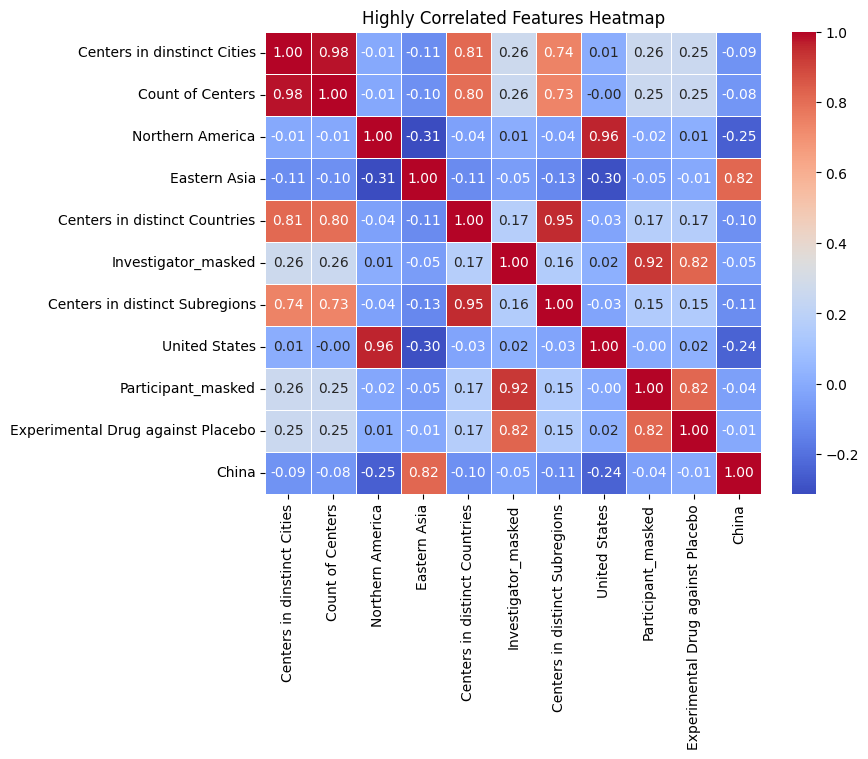

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train is your DataFrame with features
# Calculate the correlation matrix
corr_matrix = X_train.corr()

# Set a threshold for filtering highly correlated features
threshold = 0.8

# Create a mask to filter out low correlations
mask = np.abs(corr_matrix) < threshold
np.fill_diagonal(mask.values, True)  # Ignore self-correlations

# Filter the columns and rows to include only highly correlated features
filtered_cols = [col for col in corr_matrix.columns if any(np.abs(corr_matrix[col]) > threshold) and col not in mask.columns[mask.all()]]
filtered_corr_matrix = corr_matrix.loc[filtered_cols, filtered_cols]

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)

# Set the title
plt.title('Highly Correlated Features Heatmap')

# Show the plot
plt.show()

In [141]:
from sklearn.tree import export_graphviz

# Print the documentation for export_graphviz
help(export_graphviz)

Help on function export_graphviz in module sklearn.tree._export:

export_graphviz(decision_tree, out_file=None, *, max_depth=None, feature_names=None, class_names=None, label='all', filled=False, leaves_parallel=False, impurity=True, node_ids=False, proportion=False, rotate=False, rounded=False, special_characters=False, precision=3, fontname='helvetica')
    Export a decision tree in DOT format.

    This function generates a GraphViz representation of the decision tree,
    which is then written into `out_file`. Once exported, graphical renderings
    can be generated using, for example::

        $ dot -Tps tree.dot -o tree.ps      (PostScript format)
        $ dot -Tpng tree.dot -o tree.png    (PNG format)

    The sample counts that are shown are weighted with any sample_weights that
    might be present.

    Read more in the :ref:`User Guide <tree>`.

    Parameters
    ----------
    decision_tree : object
        The decision tree estimator to be exported to GraphViz.

    out

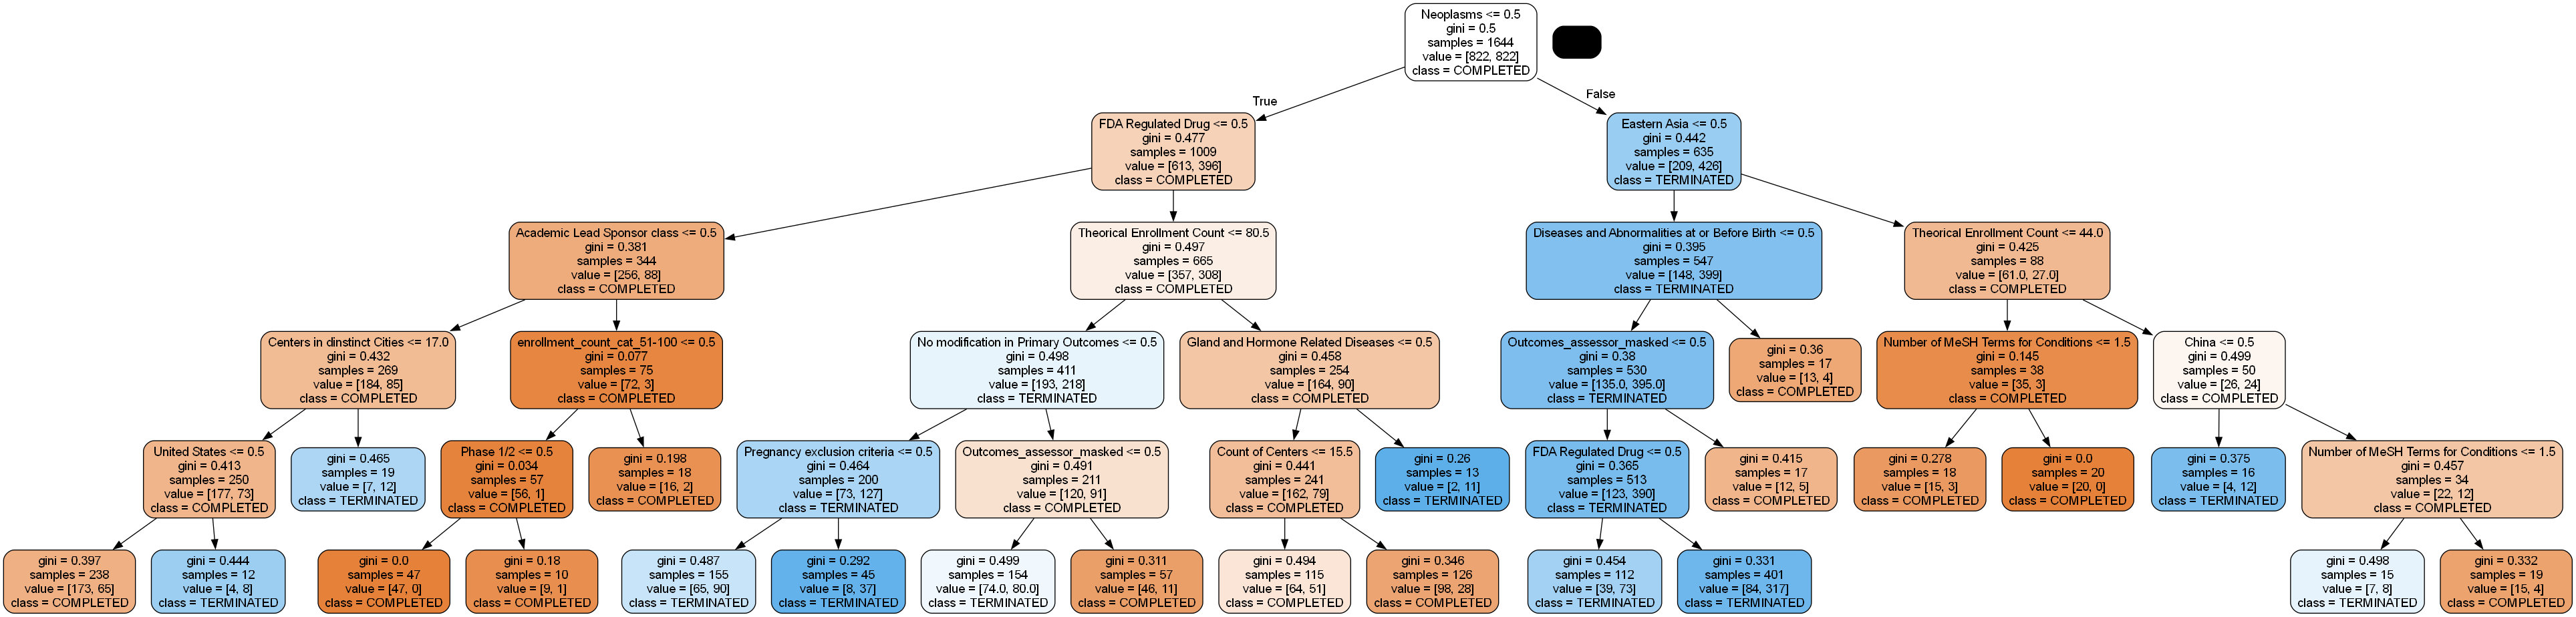

In [142]:

dot_data = export_graphviz(best_clf, out_file=None, 
                           feature_names=X.columns,  
                           class_names=['COMPLETED', 'TERMINATED'],  
                           filled=True, rounded=True,leaves_parallel=False,rotate=False,label='all')  
graph = pydotplus.graph_from_dot_data(dot_data)  
image = Image(graph.create_png(), width=800, height=600)  # Adjust width and height as needed
display(image)

In [143]:
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
import dtreeviz

# Assuming best_clf, X_train, y_train, and X are already defined
viz_model = dtreeviz.model(best_clf, 
               X_train=X,
               y_train=y,
               target_name='overallStatus',
               feature_names=X.columns,  
               class_names=['COMPLETED', 'TERMINATED'],
               )


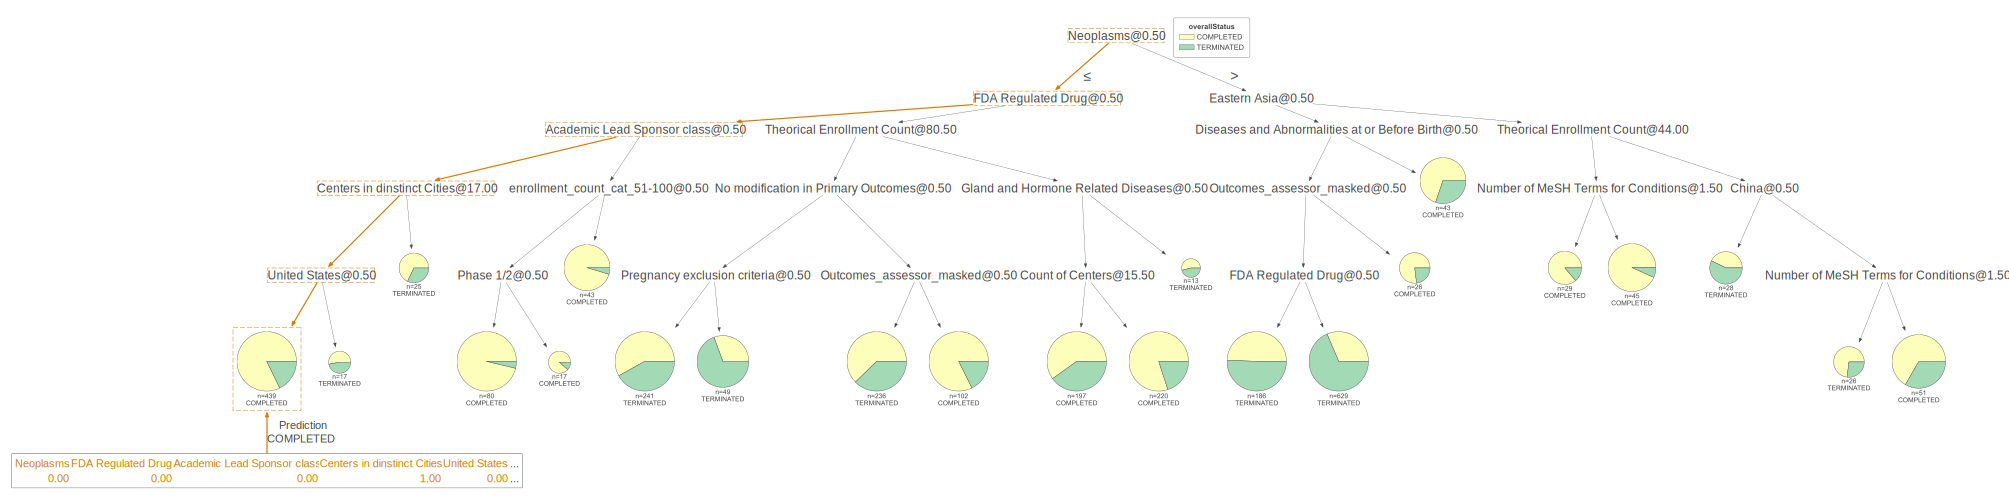

In [144]:

viz_model.view()
viz_model.view(fancy=False)
viz_model.view(x=X_test.loc['NCT01895075'],fancy=False)